## Import modules and environments

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import sys

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm

import random
import time
from collections import defaultdict
import operator
import pickle

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

EPS = float(np.finfo(np.float32).eps)

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

In [2]:
import gym
env_cartpole = gym.envs.make("CartPole-v0") # Has two actions, See doc for mor info, ??env_cartpole.env
env_car = gym.envs.make("MountainCar-v0")   # Has three actions
env_pen = gym.envs.make("Pendulum-v0")      # Has continious action values like array([-1.2552279] or array([1.7774895] 
env_acrobot = gym.envs.make("Acrobot-v1")   # Has Three actions, applying +1, 0 or -1 torque on the joint between #
                                            # the two pendulum links.   See doc for more info, ??env_acrobot.env

C:\Users\marvi\Anaconda3\envs\rl2019\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
#??env_acrobot.env
#env_acrobot.action_space.sample()
env = env_cartpole
#env = env_car
#env = env_acrobot

In [4]:
#device = "cuda:0" if torch.cuda.is_available() else "cpu"  
device = "cpu"
print(device)

cpu


### Test demo environment

In [5]:
import time
# The nice thing about the CARTPOLE is that it has very nice rendering functionality (if you are on a local environment). Let's have a look at an episode
obs = env.reset()
env.render()
done = False
while not done:
    obs, reward, done, _ = env.step(env.action_space.sample())
    env.render()
    time.sleep(0.05)
    
    #print(obs)
env.close()  # Close the environment or you will have a lot of render screens soon

### Our DQN model

In [6]:
class QNetwork(nn.Module):
    
    def __init__(self, device,num_input=4,num_hidden=128,num_output=2):
        nn.Module.__init__(self)
        self.device = device
        self.l1 = nn.Linear(num_input, num_hidden)
        self.l2 = nn.Linear(num_hidden, num_output)
        self.input_dim = num_input
        self.hidden_dim = num_hidden
        self.output_dim = num_output

    def forward(self, x):
        if not torch.is_tensor(x):
            x = torch.Tensor(x)
            
        x = x.to(self.device)
        
        forward_pass = nn.Sequential(
            self.l1,
            nn.ReLU(),
            self.l2
        )
        
        return forward_pass(x)

### Epsilon ($\epsilon$) greedy policy

In [7]:
def get_epsilon(it):
    # YOUR CODE HERE
    epsilon = 1 - (min(it,1000) * 0.00095) #After 1000 iterations epsilon should be 0.05
    
    return epsilon

In [8]:
def parameter_schedule(it,max_iter,initial_value,final_value):
    #Following general formula of get epislon
    parameter_value = initial_value - (min(it,max_iter) * ( (initial_value - final_value) / max_iter) )
                            
    return parameter_value

In [9]:
def select_action(model, state, epsilon):
    # YOUR CODE HERE
    with torch.no_grad():
        Q_approx = model(state)
        a = int(np.random.rand() * model.output_dim) if np.random.rand() < epsilon else torch.argmax(Q_approx).item()
        
    return a

### Experience replays types

#### Uniform

In [10]:
class ReplayMemory:
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.name = "uniform"

    def push(self, transition):
        
        if len(self.memory) == self.capacity:
            self.memory = self.memory[1:]   
        
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory,batch_size)

    def __len__(self):
        return len(self.memory)

#### Prioritized Replay

In [11]:
from segment_tree import SumSegmentTree, MinSegmentTree

#Source OpenAI: https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py

class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
        return np.array(obses_t), np.array(actions), np.array(rewards), np.array(obses_tp1), np.array(dones)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)


class PrioritizedReplayBuffer(ReplayBuffer):
    def __init__(self, size, alpha):
        """Create Prioritized Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        alpha: float
            how much prioritization is used
            (0 - no prioritization, 1 - full prioritization)
        See Also
        --------
        ReplayBuffer.__init__
        """
        super(PrioritizedReplayBuffer, self).__init__(size)
        assert alpha >= 0
        self._alpha = alpha

        it_capacity = 1
        while it_capacity < size:
            it_capacity *= 2

        self._it_sum = SumSegmentTree(it_capacity)
        self._it_min = MinSegmentTree(it_capacity)
        self._max_priority = 1.0
        self.name = "prioritized"

    def add(self, *args, **kwargs):
        """See ReplayBuffer.store_effect"""
        idx = self._next_idx
        super().add(*args, **kwargs)
        self._it_sum[idx] = self._max_priority ** self._alpha
        self._it_min[idx] = self._max_priority ** self._alpha

    def _sample_proportional(self, batch_size):
        res = []
        p_total = self._it_sum.sum(0, len(self._storage) - 1)
        every_range_len = p_total / batch_size
        for i in range(batch_size):
            mass = random.random() * every_range_len + i * every_range_len
            idx = self._it_sum.find_prefixsum_idx(mass)
            res.append(idx)
        return res

    def sample(self, batch_size, beta):
        """Sample a batch of experiences.
        compared to ReplayBuffer.sample
        it also returns importance weights and idxes
        of sampled experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        beta: float
            To what degree to use importance weights
            (0 - no corrections, 1 - full correction)
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        weights: np.array
            Array of shape (batch_size,) and dtype np.float32
            denoting importance weight of each sampled transition
        idxes: np.array
            Array of shape (batch_size,) and dtype np.int32
            idexes in buffer of sampled experiences
        """
        assert beta > 0

        idxes = self._sample_proportional(batch_size)

        weights = []
        p_min = self._it_min.min() / self._it_sum.sum()
        max_weight = (p_min * len(self._storage)) ** (-beta)

        for idx in idxes:
            p_sample = self._it_sum[idx] / self._it_sum.sum()
            weight = (p_sample * len(self._storage)) ** (-beta)
            weights.append(weight / max_weight)
        weights = np.array(weights)
        encoded_sample = self._encode_sample(idxes)
        return tuple(list(encoded_sample) + [weights, idxes])

    def update_priorities(self, idxes, priorities):
        """Update priorities of sampled transitions.
        sets priority of transition at index idxes[i] in buffer
        to priorities[i].
        Parameters
        ----------
        idxes: [int]
            List of idxes of sampled transitions
        priorities: [float]
            List of updated priorities corresponding to
            transitions at the sampled idxes denoted by
            variable `idxes`.
        """
        assert len(idxes) == len(priorities)
        for idx, priority in zip(idxes, priorities):
            assert priority > 0
            assert 0 <= idx < len(self._storage)
            self._it_sum[idx] = priority ** self._alpha
            self._it_min[idx] = priority ** self._alpha

            self._max_priority = max(self._max_priority, priority)
            
def train_prioritized(model, memory, optimizer, batch_size, discount_factor,beta,prioritized_replay_eps=1e-6):
    # DO NOT MODIFY THIS FUNCTION
    
    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None

    # random transition batch is taken from experience replay memory
    #----------------------------#Adjusted of normal train--------------------------------------------------------
    transitions = memory.sample(batch_size, beta=beta)
    (state, action, reward, next_state, done, weights, batch_idxes) = transitions#zip(*transitions)
    
    # convert to PyTorch and define types
    state = torch.tensor(state, dtype=torch.float, device = model.device)
    action = torch.tensor(action, dtype=torch.int64, device = model.device)  # Need 64 bit to use them as index
    next_state = torch.tensor(next_state, dtype=torch.float, device = model.device)
    reward = torch.tensor(reward, dtype=torch.float, device = model.device)
    done = torch.tensor(done, dtype=torch.uint8)  # Boolean
    weights = torch.tensor(weights, dtype=torch.float, device = model.device)
    #batch_idxes = torch.tensor(batch_idxes, dtype = torch.int64, device = model.device)
    
     #-------------------------------------------------------------------------------------------------------------
    
    # compute the q value
    q_val = compute_q_val(model, state, action)
    
    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_target(model, reward, next_state, done, discount_factor)
    
    #-------------------------------------------------------------------------------------------------------------


    # loss is measured from error between current and newly expected Q values
    #loss = F.smooth_l1_loss(q_val, target)
    td_errors = F.smooth_l1_loss(q_val, target,reduction="none") #TD errors, 

    weighted_td_errors = weights.reshape(-1,1) * td_errors 
    #weighted_td_errors = td_errors
    
    loss = torch.mean(weighted_td_errors) 

    # backpropagation of loss to Neural Network (PyTorch magic)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    mean_loss_value = loss.item() 
    
    if model.device == "cpu":
        #td_errors = td_errors.detach().numpy()
        weighted_td_errors = weighted_td_errors.detach().numpy()
    else:
        weighted_td_errors = weighted_td_errors.cpu().detach().numpy()
    new_priorities = np.abs(weighted_td_errors) + prioritized_replay_eps
    #new_priorities = np.abs(loss_value) + prioritized_replay_eps
    memory.update_priorities(batch_idxes, new_priorities)
    #-------------------------------------------------------------------------------------------------------------
    
    return mean_loss_value  # Returns a Python scalar, and releases history (similar to .detach())


#### Selective Experience Replay

In [12]:
class SelectiveReplayMemory:
    
    def __init__(self, fifo_capacity, episodic_memory_capacity):
        self.fifo_capacity = fifo_capacity
        self.episodic_capacity = episodic_memory_capacity
        self.fifo_memory = []
        self.episodic_memory = []
        self.name = "selective"
        #self.lowest_rank_value = 100

    def push(self, transition):
        
        if len(self.fifo_memory) == self.fifo_capacity:
            self.fifo_memory = self.fifo_memory[1:]   
        
        self.fifo_memory.append(transition)
    
        #Distribution matching selection
        rank_value = np.random.standard_normal(1)
        #if rank_value < self.lowest_rank_value:
        #    self.lowest_rank_value = rank_value
            
        self.episodic_memory.append( (transition,rank_value) )
        
        if len(self.episodic_memory) > self.episodic_capacity:
            sorted_episodic = sorted(self.episodic_memory, key=operator.itemgetter(1))
            self.episodic_memory = sorted_episodic[1:]    #Smallest value is index 0 to be removed
        
    def sample(self, batch_size):
        
        #concatenate and sample
        concat = self.fifo_memory + [i[0] for i in self.episodic_memory]
        samples = random.sample(concat,batch_size)
        
        return samples

    def __len__(self):
        return len(self.fifo_memory) #+ len(episodic_memory) #Do we count both memories as len? 

#### Hindsight Experience Replay

In [13]:
class HindsightReplayMemory:
    
    def __init__(self, capacity, k,env_name):
        self.capacity = capacity
        self.memory = []
        self.k = k
        self.name = "hindsight"
        self.goals = []
        self.env_name = env_name
        self.current_episode = []
            
        if env_name == "Acrobot-v1":
            self.true_goal_func = lambda s: bool(-np.cos(s[0]) - np.cos(s[1] + s[0]) > 1.)  #This is probably wrong from the doc?
            self.true_goal_example = np.array([-0.27671839,  0.96095106,  0.25269736,  0.96754537,  1.35394005, -0.99966234])
            self.goal_func = lambda s1,s2: (s1 == s2).all()
        elif env_name == "MountainCar-v0":
            self.true_goal_func = lambda s: s[0] >= 0.5 
            self.true_goal_example = np.array([0.5, 0.00336499])
            self.goal_func = lambda s1,s2: s1[0] == s2[0]
        
    def compute_reward(self,observed_state,goal):
        
        if self.goal_func(observed_state,goal):
            return 0
        
        return -1

    def push(self, transition):
                
        if len(self.memory) == self.capacity:
            self.memory = self.memory[1:]   
        
        self.memory.append(transition)
        self.current_episode.append(transition)
        #goals = 
            
    def add_future_goals(self):

        episode_len = len(self.current_episode)
        state_size = len(self.true_goal_example)
        sample_size = self.k 
        
        for i in range(episode_len):
            current_transition = self.current_episode[i]
            observed_state_goal = current_transition[3]
            observed_state = observed_state_goal[:state_size]
            
            amount_future = (episode_len - (i+1))
            if amount_future > 0:
                sampled_trans = random.choices(self.current_episode[i+1:],k = sample_size) #Sample with replacement 
                new_rewards = [self.compute_reward(observed_state,trans[0][:state_size]) for trans in sampled_trans]
            
                #print(new_rewards)
                #if 0 in new_rewards:
                #    print("-" *50)
                #    print(new_rewards)
            
                for new_r in new_rewards:
                    tmp_trans = list(current_transition)
                    tmp_trans[2] = new_r
                    tmp_trans = tuple(tmp_trans)
                    self.memory.append(tmp_trans)
                    #if 0 in new_rewards:
                    #    print(current_transition)
                    #    print(new_r)
                    #    print(tmp_trans)
            
        self.current_episode = []

    def sample(self, batch_size):
        samples = random.sample(self.memory,batch_size)
        
        return samples

    def __len__(self):
        return len(self.memory)

def train_hindsight(model, memory, optimizer, batch_size, discount_factor):
    # DO NOT MODIFY THIS FUNCTION
    
    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None

    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)
    
    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done = zip(*transitions)
    
    # convert to PyTorch and define types
    state = torch.tensor(state, dtype=torch.float, device = model.device)
    action = torch.tensor(action, dtype=torch.int64, device = model.device)  # Need 64 bit to use them as index
    next_state = torch.tensor(next_state, dtype=torch.float, device = model.device)
    reward = torch.tensor(reward, dtype=torch.float, device = model.device)
    done = torch.tensor(done, dtype=torch.uint8)  # Boolean
    
    # compute the q value
    q_val = compute_q_val(model, state, action)
    
    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_target(model, reward, next_state, done, discount_factor)
    
    # loss is measured from error between current and newly expected Q values
    loss = F.smooth_l1_loss(q_val, target)

    # backpropagation of loss to Neural Network (PyTorch magic)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()  # Returns a Python scalar, and releases history (similar to .detach())

### Training function

In [14]:
def compute_q_val(model, state, action):
    # YOUR CODE HERE
    Q_approx = model(state)
    action_values = torch.gather(Q_approx, dim=1, index=action.reshape(-1,1))
    
    return action_values
    
def compute_target(model, reward, next_state, done, discount_factor):
    # done is a boolean (vector) that indicates if next_state is terminal (episode is done)
    # YOUR CODE HERE

    Q_approx = model(next_state)
    max_Q = torch.max(Q_approx,dim=1)[0]
    target = reward + discount_factor * max_Q

    indices = torch.tensor(np.where(done),dtype=torch.long, device = model.device)
    target = target.scatter(0, indices.reshape(-1), 0)
    target = target.reshape(-1,1)
        
    return target

def train(model, memory, optimizer, batch_size, discount_factor):
    # DO NOT MODIFY THIS FUNCTION
    
    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None

    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)
    
    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done = zip(*transitions)
    
    # convert to PyTorch and define types
    state = torch.tensor(state, dtype=torch.float, device = model.device)
    action = torch.tensor(action, dtype=torch.int64, device = model.device)  # Need 64 bit to use them as index
    next_state = torch.tensor(next_state, dtype=torch.float, device = model.device)
    reward = torch.tensor(reward, dtype=torch.float, device = model.device)
    done = torch.tensor(done, dtype=torch.uint8)  # Boolean
    
    # compute the q value
    q_val = compute_q_val(model, state, action)
    
    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_target(model, reward, next_state, done, discount_factor)
    
    # loss is measured from error between current and newly expected Q values
    loss = F.smooth_l1_loss(q_val, target)

    # backpropagation of loss to Neural Network (PyTorch magic)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()  # Returns a Python scalar, and releases history (similar to .detach())

In [15]:
def run_episodes(train,select_action_func, model, memory, env, num_episodes, batch_size, discount_factor, learn_rate, 
                 beta_max_iter = 1000,beta_start = 0.4,beta_end = 1.0):
    
    optimizer = optim.Adam(model.parameters(), learn_rate)
    
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []  #
    
    for i in tqdm(range(num_episodes)):
        # YOUR CODE HERE
        s = env.reset()
        done = False
        local_steps = 0 
        
        while not done:
            epsilon = get_epsilon(global_steps)
            if memory.name == "hindsight":
                combined_s = np.concatenate( (s, memory.true_goal_example))
                a = select_action_func(model, combined_s, epsilon)
            else:
                a = select_action_func(model, s, epsilon)
            
            observation,reward,done,info = env.step(a)
            
            global_steps += 1
            local_steps += 1
            
            if memory.name == "prioritized":
                memory.add(s, a, reward, observation, float(done))
                beta = parameter_schedule(global_steps,beta_max_iter,beta_start,beta_end)
                loss = train(model, memory, optimizer, batch_size, discount_factor,beta)
            elif memory.name == "hindsight":
                combined_observation = np.concatenate( (observation, memory.true_goal_example) )
                memory.push((combined_s, a, reward, combined_observation, done)) 
                loss = train(model, memory, optimizer, batch_size, discount_factor)
            elif memory.name == "uniform" or memory.name == "selective":
                memory.push((s, a, reward, observation, done))
                loss = train(model, memory, optimizer, batch_size, discount_factor)

            s = observation
        
        episode_durations.append(local_steps)
        
        if memory.name == "hindsight":
            memory.add_future_goals()
        
        #Check for convergance to terminate perhaps?

    return episode_durations

### Utility save functions

In [43]:
def save_model(model,name="model"):
    torch.save({
        # You can add more here if you need, e.g. critic
        'model': model.state_dict()  # Always save weights rather than objects
    },
    name + ".pt")
    
def pickle_action(obj,name,action="w"):
    if action == 'r':
        return pickle.load( open( name, "rb" ) )          
    else:
        pickle.dump( obj, open( name, "wb" ) )
    

### Experiments

#### Set multiple seeds 

In [16]:
# We will seed the algorithm (before initializing QNetwork!) for reproducability

if "cuda" in device:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 42 
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)
np.random.seed(seed) #Added this seed for numpy, as used in selection action

#### Run it once 

In [17]:
#env = env_cartpole
env = env_car
#env = env_pen
#env = env_acrobot 

In [18]:
#Hyperparameters
num_episodes = 1000
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
buffer_size = 10000

#Parameters for network, e.g. hidden dim
num_input = len(env.observation_space.sample())
num_hidden = 128
num_output = env.action_space.n

#Parameters for schedule of beta and alpha for prioritized replay
beta_max_iter = 1000
beta_start = 0.4
beta_end = 1.0
prioritized_replay_alpha = 0.6
#prioritized_replay_eps=1e-6 Set default in the training function

#Parameters for selective
episodic_buffer_size = 12000

#Parameters for hindsight
k = 4
env_name = env.unwrapped.spec.id
bigger_buffer_size = 10000 * k

#Picking the memory type
memory_method = 4

if memory_method == 1:  #Uniform
    memory = ReplayMemory(buffer_size)
    train_func = train #Uniform
    select_action_func = select_action #epsilon greedy
    
elif memory_method == 2:   #Prioritzed
    memory = PrioritizedReplayBuffer(buffer_size, alpha=prioritized_replay_alpha)
    train_func = train_prioritized #Prioritized Replay
    select_action_func = select_action #epsilon greedy

elif memory_method == 3:   #Selective
    memory = SelectiveReplayMemory(buffer_size,episodic_buffer_size)
    train_func = train #same way as uniform
    select_action_func = select_action #epsilon greedy

elif memory_method == 4: #Hindsight
    num_input = 2 * num_input
    memory = HindsightReplayMemory(bigger_buffer_size,k,env_name)
    train_func = train #same way as uniform
    select_action_func = select_action #epsilon greedy

#Initialize model
model = QNetwork(device,num_input,num_hidden,num_output)
model = model.to(device)

#Running
start_time = time.time()
episode_durations = run_episodes(train_func,select_action_func, model, memory, env, num_episodes, batch_size, discount_factor, learn_rate,
                                beta_max_iter,beta_start,beta_end)
end_time = time.time()

print("Total duration time: ", str(end_time - start_time))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:50<00:00,  2.67it/s]


Total duration time:  350.75277161598206


### Plots and analysis

Text(0.5, 1.0, 'Episode durations per episode for MountainCar-v0')

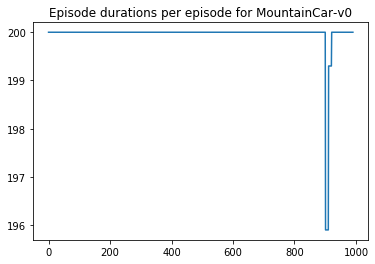

In [19]:
# And see the results
def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.plot(smooth(episode_durations, 10))
plt.title('Episode durations per episode for ' + env_name)

### Hyperparameter grid search

#### Prioritized


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 166.64it/s]

Total duration time:  0.01693129539489746


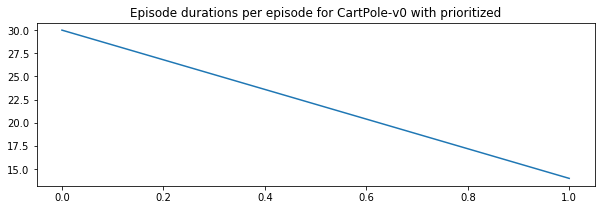


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 250.68it/s]

Total duration time:  0.012965917587280273


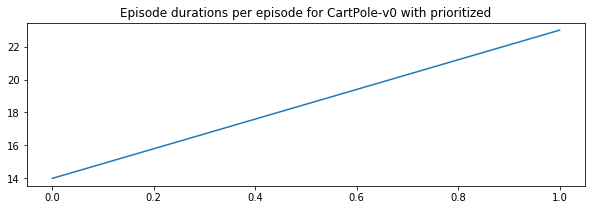


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 200.43it/s]

Total duration time:  0.013962030410766602


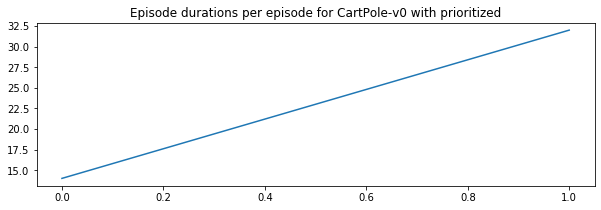


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 154.24it/s]

Total duration time:  0.017954349517822266


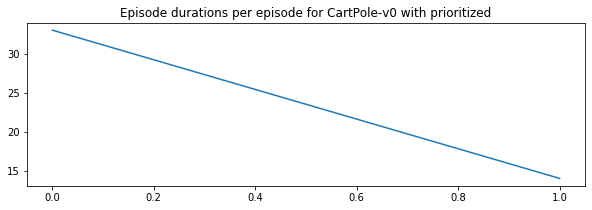


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 200.64it/s]

Total duration time:  0.013928890228271484


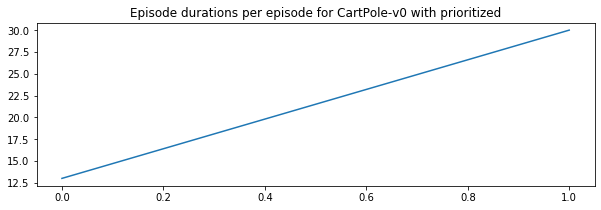


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 154.25it/s]

Total duration time:  0.01695418357849121


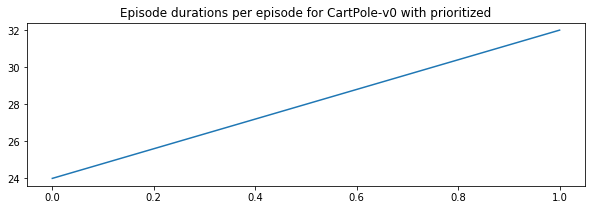


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 87.18it/s]

Total duration time:  0.026928424835205078


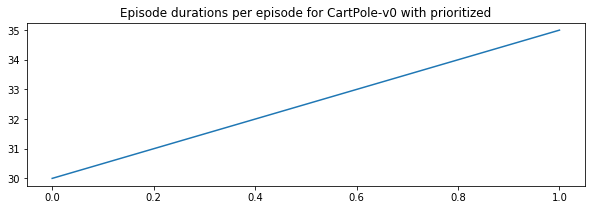


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 222.81it/s]

Total duration time:  0.013934850692749023


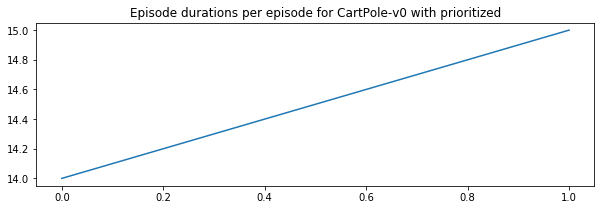


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 167.01it/s]

Total duration time:  0.015955686569213867


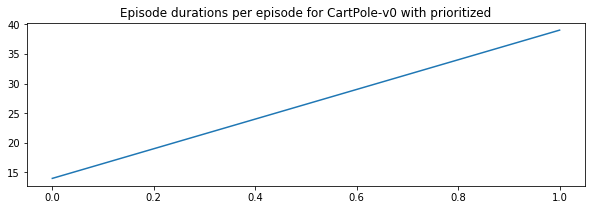


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 166.87it/s]

Total duration time:  0.016957998275756836


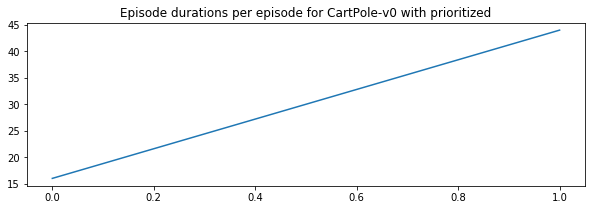


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 222.74it/s]

Total duration time:  0.012947559356689453


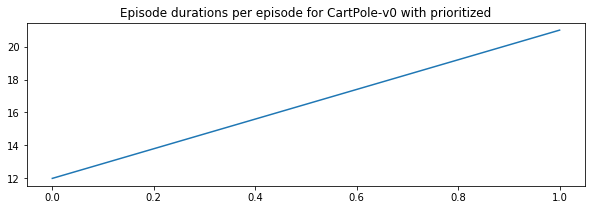


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 182.29it/s]

Total duration time:  0.013962984085083008


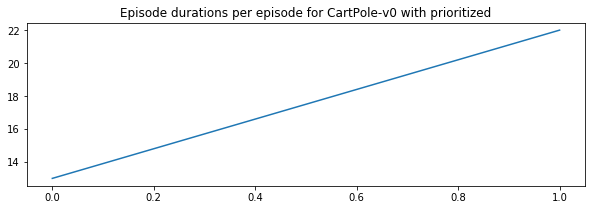


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 31.34it/s]

Total duration time:  0.0688161849975586


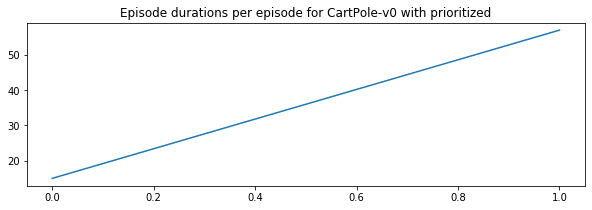


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 154.25it/s]

Total duration time:  0.015957355499267578


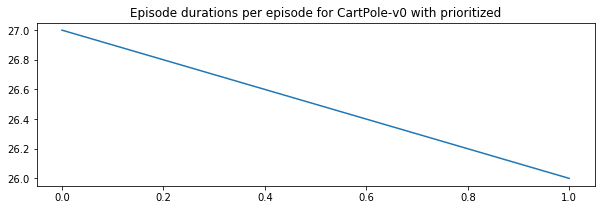


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 250.71it/s]

Total duration time:  0.010970830917358398


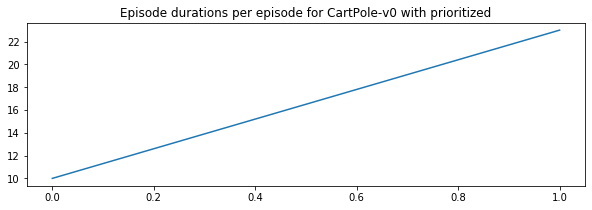


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 222.19it/s]

Total duration time:  0.013975143432617188


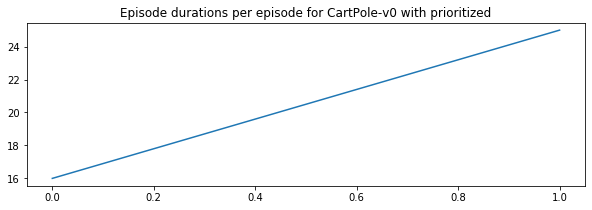


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 200.53it/s]

Total duration time:  0.012966632843017578


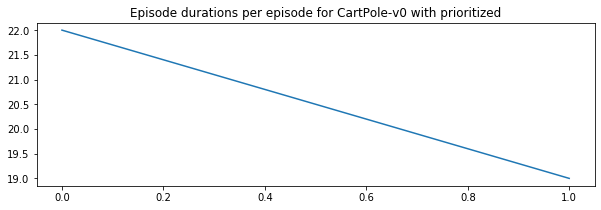


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 333.46it/s]

Total duration time:  0.010971546173095703


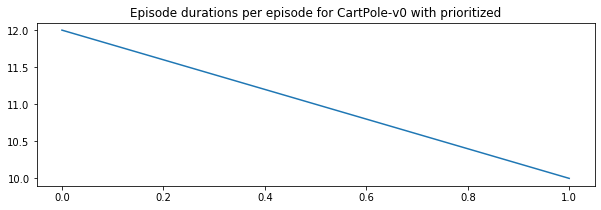


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 200.55it/s]

Total duration time:  0.014949798583984375


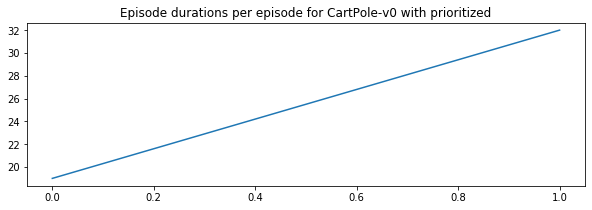


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 250.57it/s]

Total duration time:  0.01296544075012207


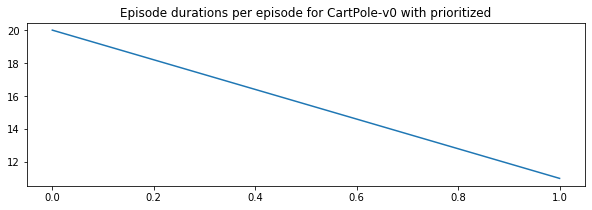


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 167.11it/s]

Total duration time:  0.016922712326049805


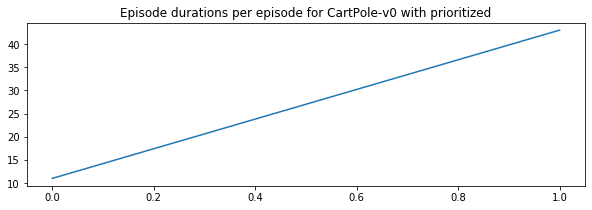


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 143.31it/s]

Total duration time:  0.017952680587768555


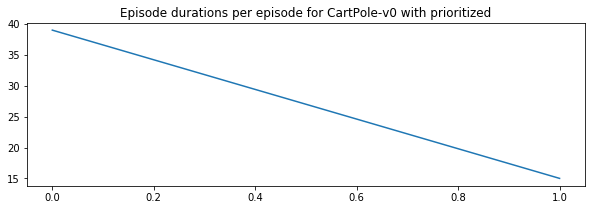


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 182.27it/s]

Total duration time:  0.01496124267578125


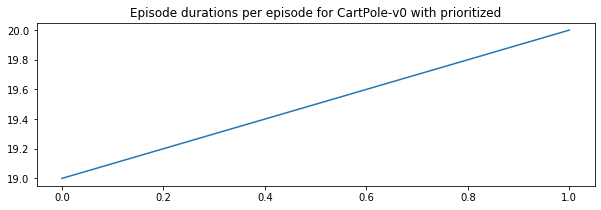


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.28it/s]

Total duration time:  0.22037696838378906


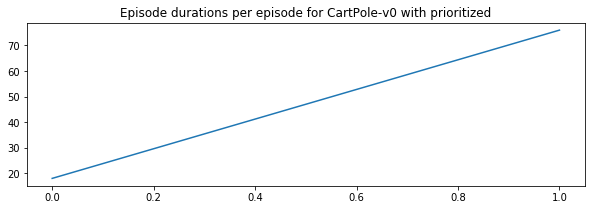


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 286.53it/s]

Total duration time:  0.009946823120117188


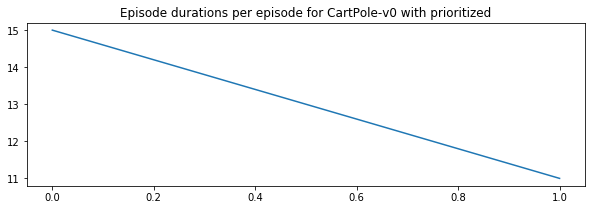


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.53it/s]

Total duration time:  0.17752718925476074


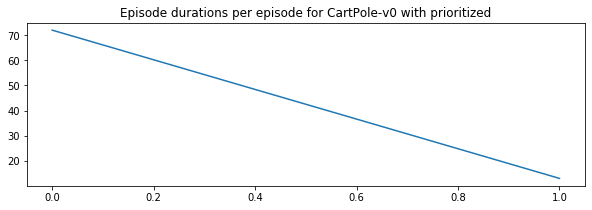


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 222.64it/s]

Total duration time:  0.012965679168701172


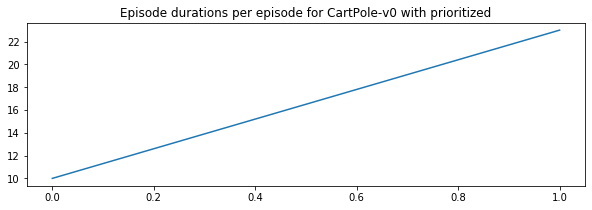


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 286.51it/s]

Total duration time:  0.010970830917358398


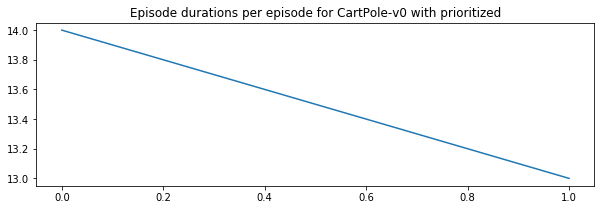


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 182.30it/s]

Total duration time:  0.015958786010742188


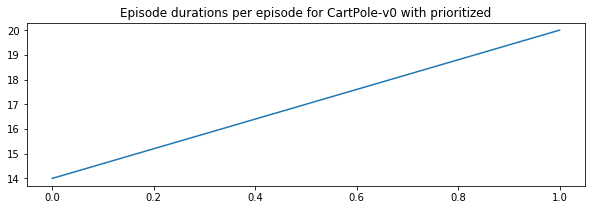


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 334.27it/s]

Total duration time:  0.010928153991699219


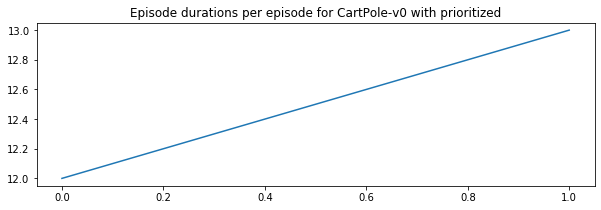


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 182.30it/s]

Total duration time:  0.01593184471130371


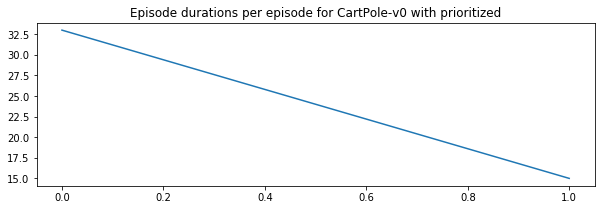


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 250.65it/s]

Total duration time:  0.012966632843017578


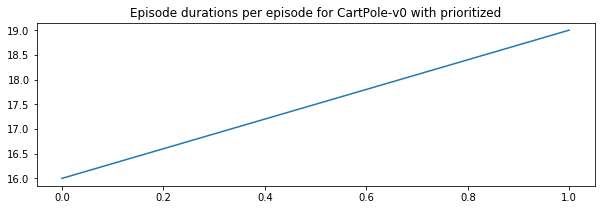


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 250.09it/s]

Total duration time:  0.012936830520629883


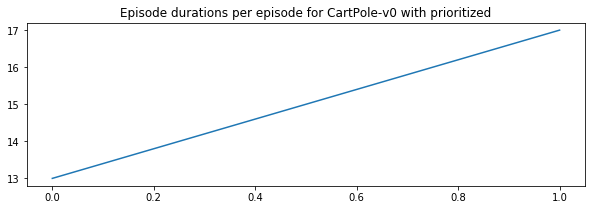


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 182.30it/s]

Total duration time:  0.014921188354492188


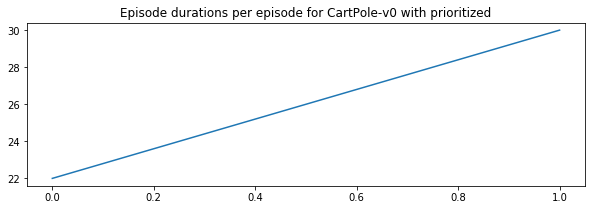


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 200.51it/s]

Total duration time:  0.013964414596557617


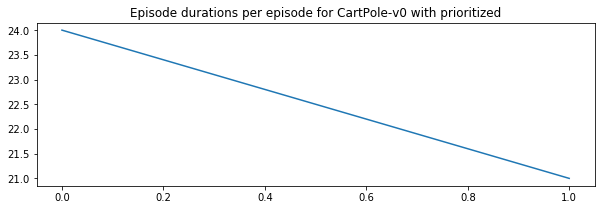


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 27.85it/s]

Total duration time:  0.07579708099365234


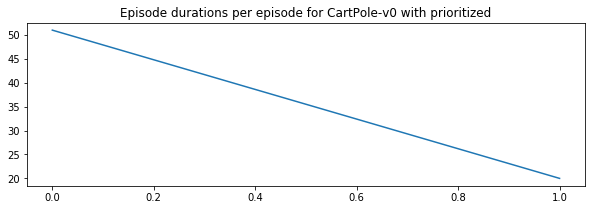


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 181.87it/s]

Total duration time:  0.01595759391784668


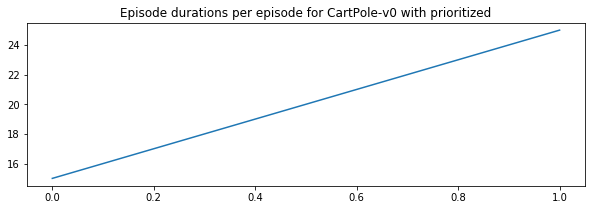


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 181.88it/s]

Total duration time:  0.01595330238342285


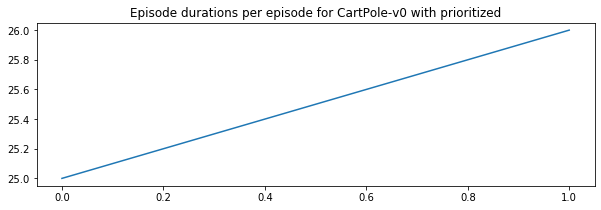


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 154.25it/s]

Total duration time:  0.01695537567138672


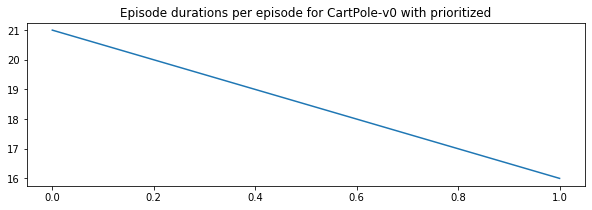


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 222.80it/s]

Total duration time:  0.01194310188293457


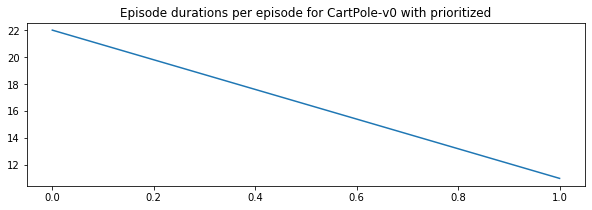


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 286.93it/s]

Total duration time:  0.010970830917358398


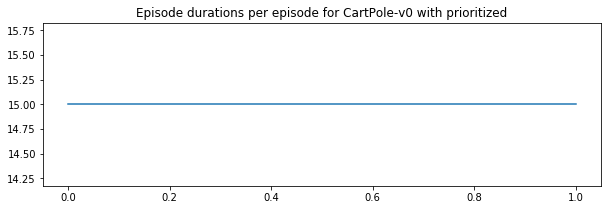


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 166.74it/s]

Total duration time:  0.01590728759765625


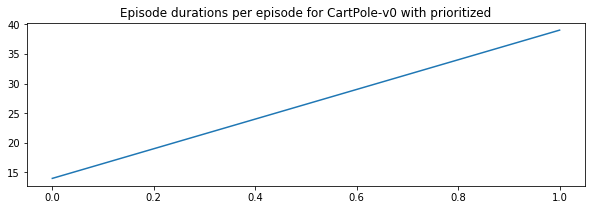


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.67it/s]

Total duration time:  0.19146180152893066


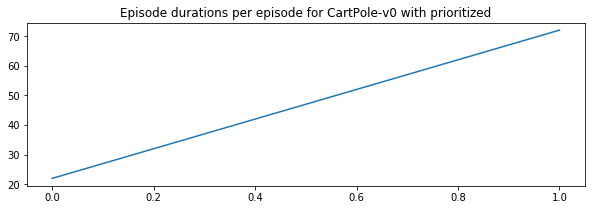


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 182.31it/s]

Total duration time:  0.014960050582885742


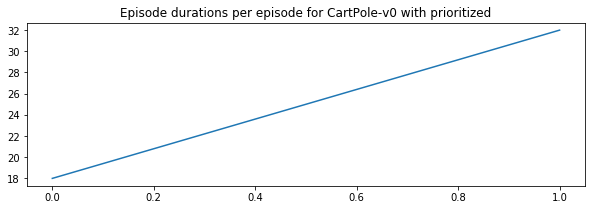


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 166.66it/s]

Total duration time:  0.01695418357849121


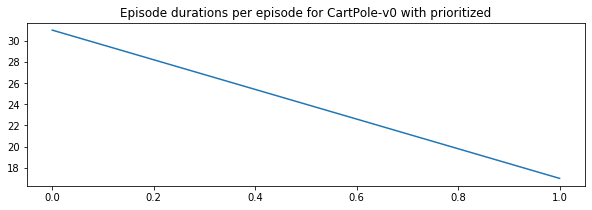


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.46it/s]

Total duration time:  0.10272550582885742


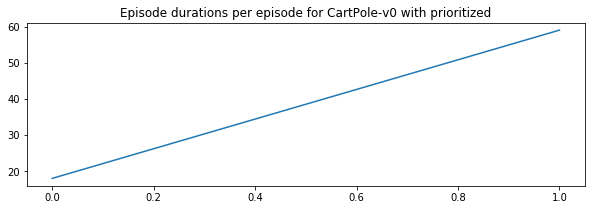


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 143.24it/s]

Total duration time:  0.01695561408996582


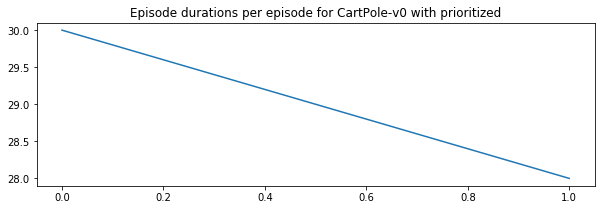


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 143.23it/s]

Total duration time:  0.018918991088867188


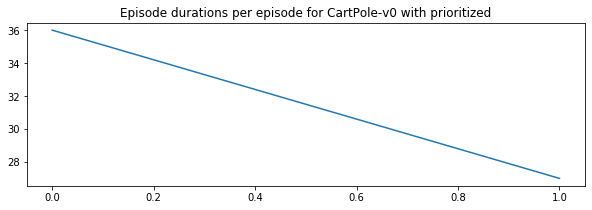


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 121.52it/s]

Total duration time:  0.021451711654663086


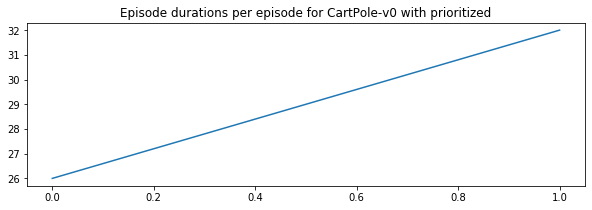


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 167.09it/s]

Total duration time:  0.014959335327148438


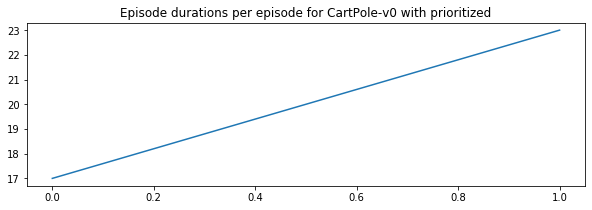


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 222.88it/s]

Total duration time:  0.012959957122802734


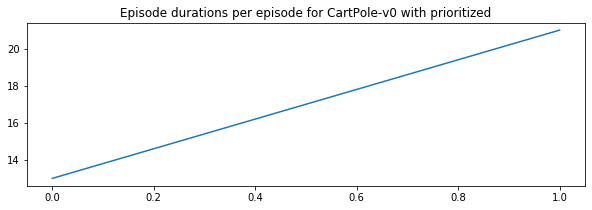


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 250.20it/s]

Total duration time:  0.012965917587280273


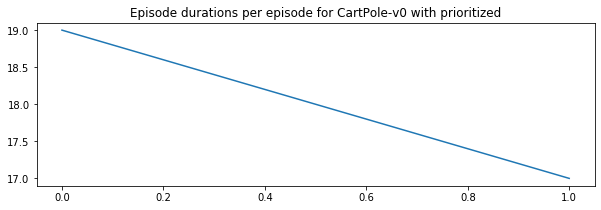


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 222.54it/s]

Total duration time:  0.012938499450683594


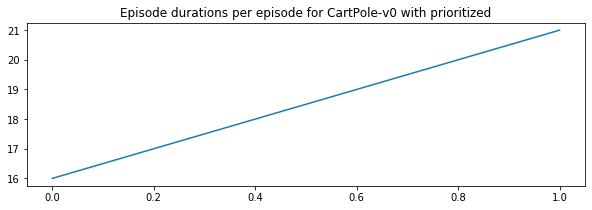


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 23.87it/s]

Total duration time:  0.08873105049133301


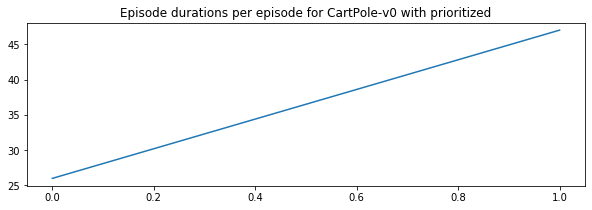


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 154.26it/s]

Total duration time:  0.015957355499267578


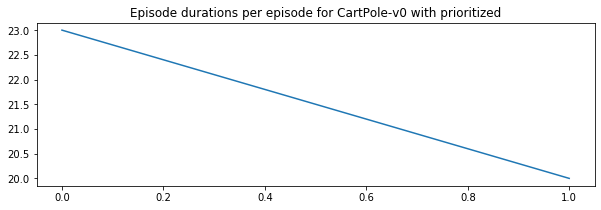


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 154.25it/s]

Total duration time:  0.016927480697631836


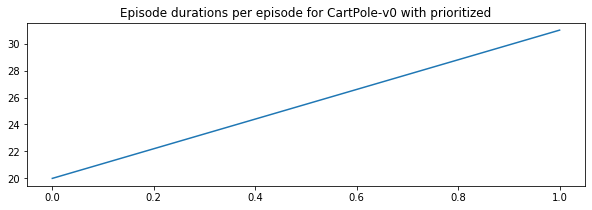


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 182.31it/s]

Total duration time:  0.014960765838623047


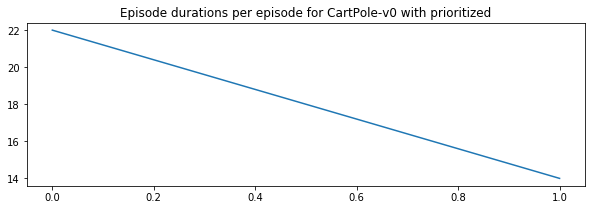


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 286.44it/s]

Total duration time:  0.009975194931030273


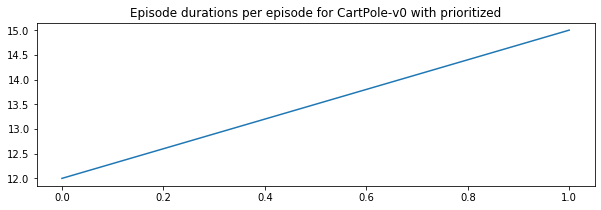


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.83it/s]

Total duration time:  0.15059804916381836


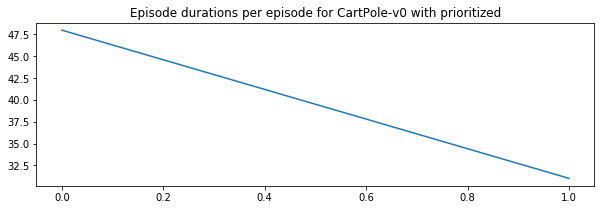


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 182.31it/s]

Total duration time:  0.014961719512939453


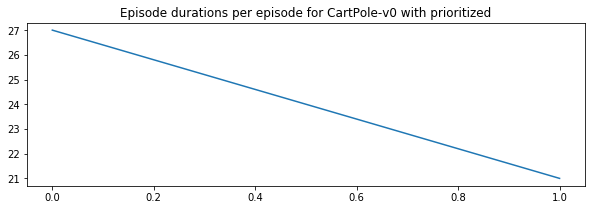


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 182.31it/s]

Total duration time:  0.015925884246826172


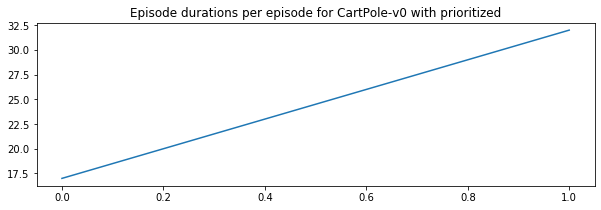


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 125.35it/s]

Total duration time:  0.020944833755493164


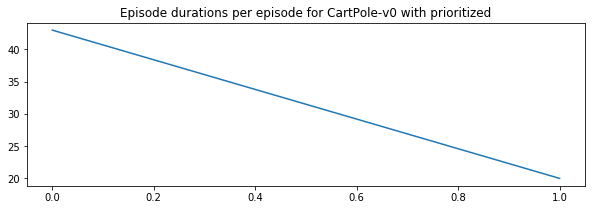


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 182.32it/s]

Total duration time:  0.015958309173583984


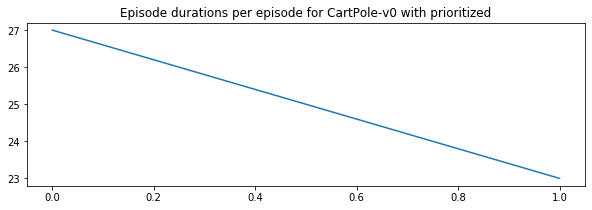


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 200.53it/s]

Total duration time:  0.014961719512939453


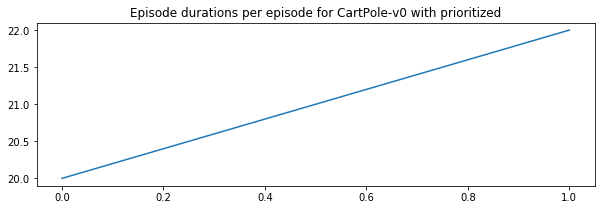


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.03it/s]

Total duration time:  0.2044539451599121


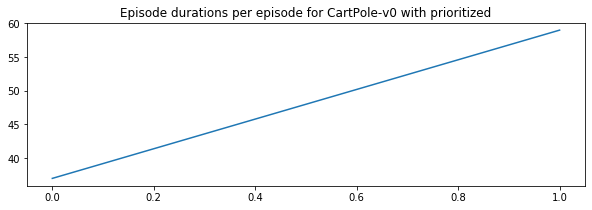


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 182.29it/s]

Total duration time:  0.014961481094360352


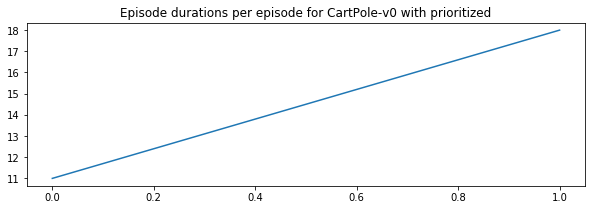


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 250.66it/s]

Total duration time:  0.010971307754516602


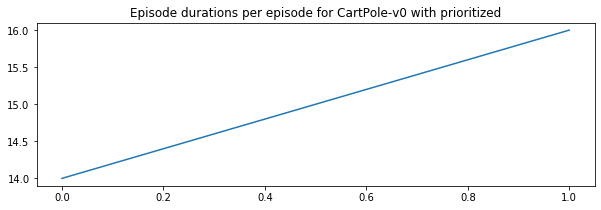


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 222.82it/s]

Total duration time:  0.012966394424438477


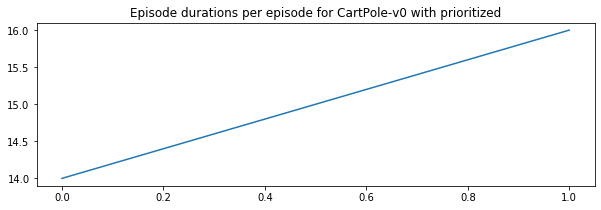


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 125.34it/s]

Total duration time:  0.01994633674621582


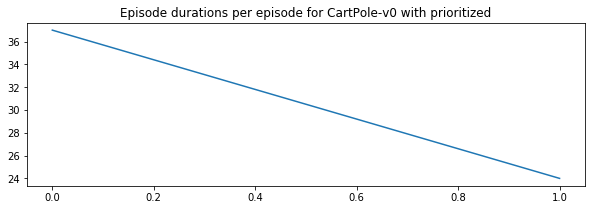


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.30it/s]

Total duration time:  0.16755247116088867


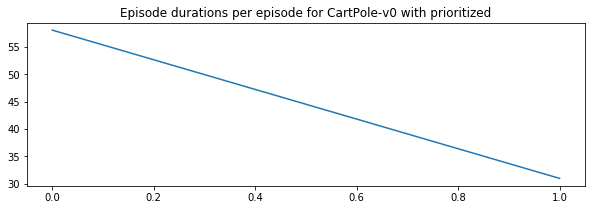


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 167.12it/s]

Total duration time:  0.014960765838623047


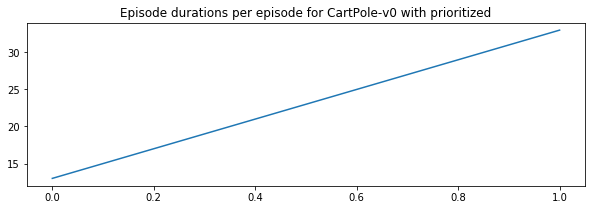


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 143.37it/s]

Total duration time:  0.01793050765991211


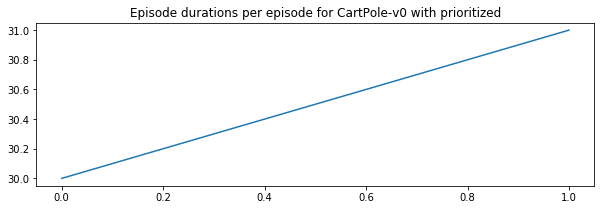


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 182.29it/s]

Total duration time:  0.014985084533691406


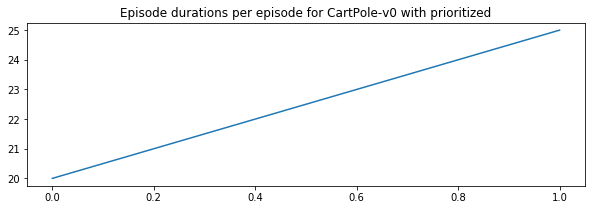


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 332.79it/s]

Total duration time:  0.01096963882446289


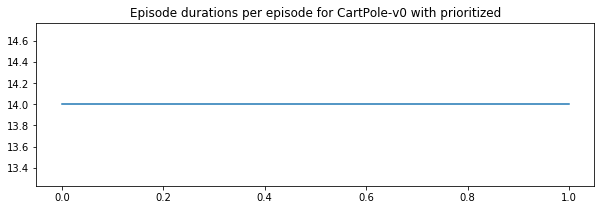


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 250.29it/s]

Total duration time:  0.01296544075012207


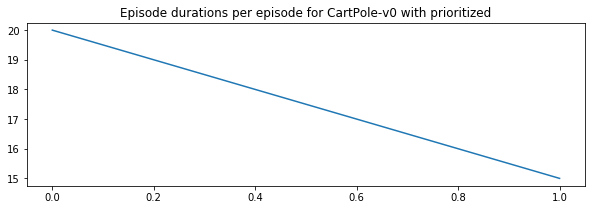


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 250.64it/s]

Total duration time:  0.012966394424438477


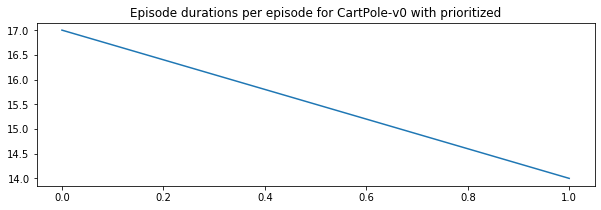


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 182.30it/s]

Total duration time:  0.013962745666503906


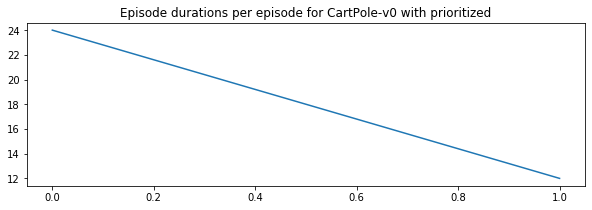


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 223.08it/s]

Total duration time:  0.013958930969238281


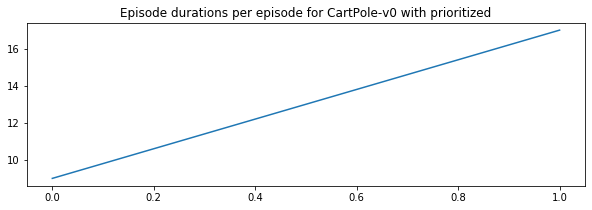


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.92it/s]

Total duration time:  0.1306438446044922


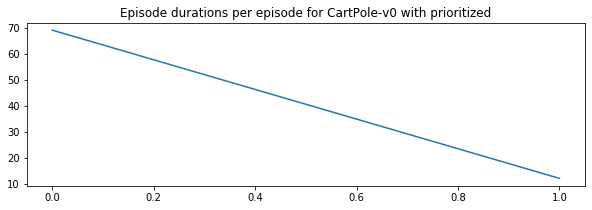


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 200.55it/s]

Total duration time:  0.013962984085083008


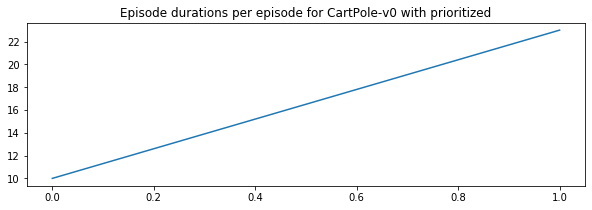


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.55it/s]

Total duration time:  0.3091394901275635


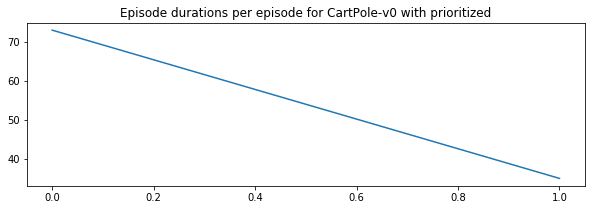


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 154.27it/s]

Total duration time:  0.016955852508544922


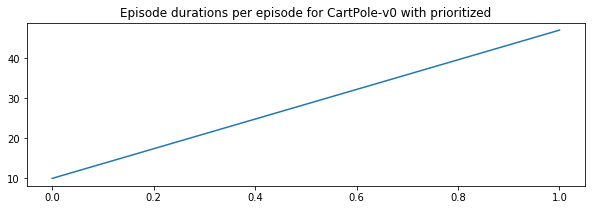


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 55.68it/s]

Total duration time:  0.04089069366455078


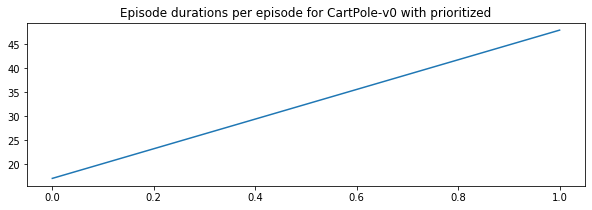


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 222.83it/s]

Total duration time:  0.011966943740844727


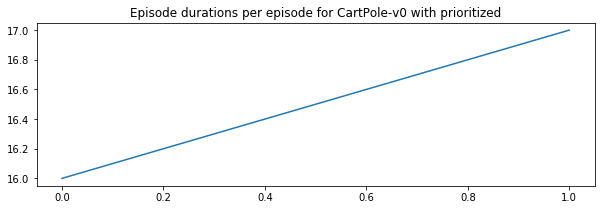


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 167.11it/s]

Total duration time:  0.013930320739746094


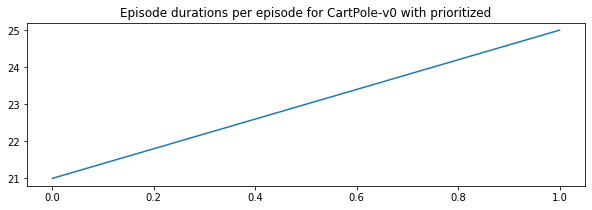


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 332.30it/s]

Total duration time:  0.010933399200439453


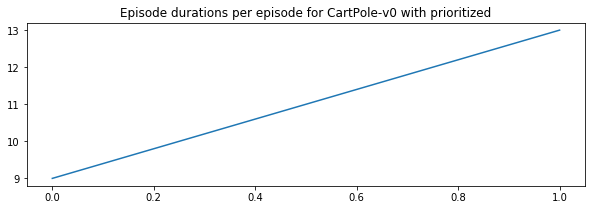


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 166.55it/s]

Total duration time:  0.01692676544189453


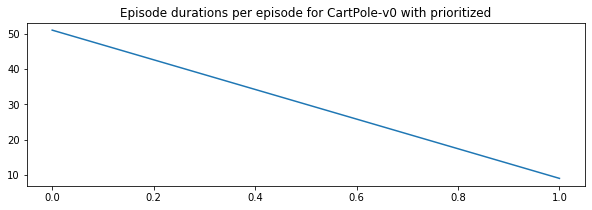


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 182.32it/s]

Total duration time:  0.01595783233642578


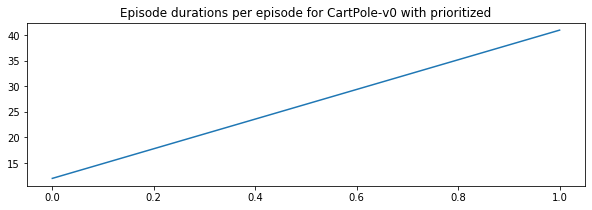


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 200.55it/s]

Total duration time:  0.013962507247924805


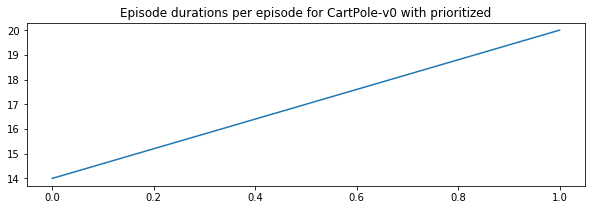


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 286.57it/s]

Total duration time:  0.011935234069824219


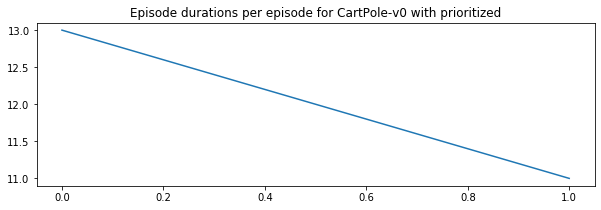


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 285.97it/s]

Total duration time:  0.010939359664916992


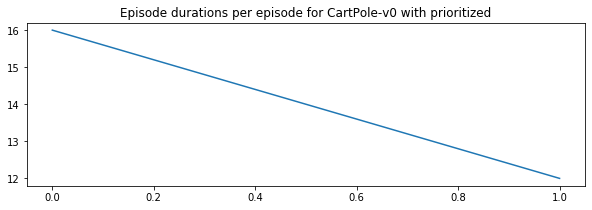


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 125.34it/s]

Total duration time:  0.019948244094848633


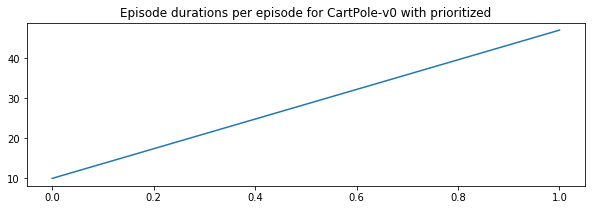


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 222.78it/s]

Total duration time:  0.01291966438293457


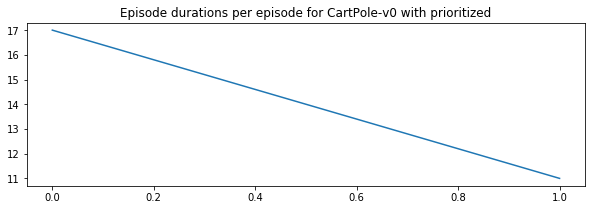


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 167.12it/s]

Total duration time:  0.014926671981811523


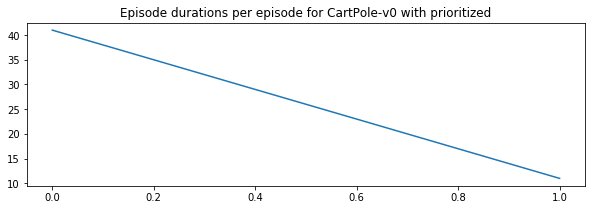


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 222.87it/s]

Total duration time:  0.011966705322265625


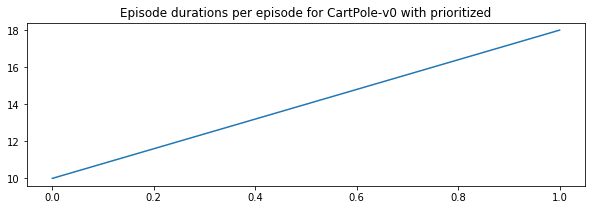


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 17.14it/s]

Total duration time:  0.12164855003356934


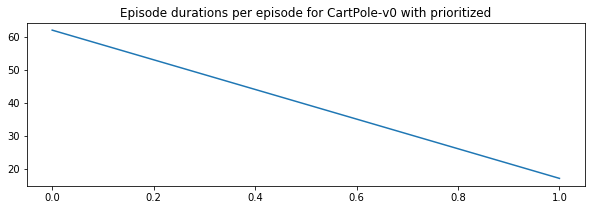


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 153.90it/s]

Total duration time:  0.016954898834228516


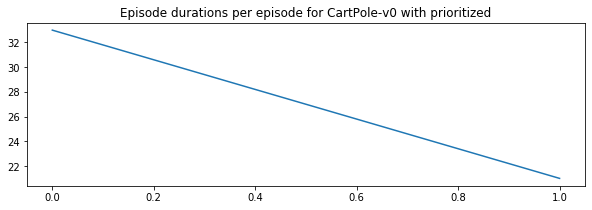


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 154.27it/s]

Total duration time:  0.01694035530090332


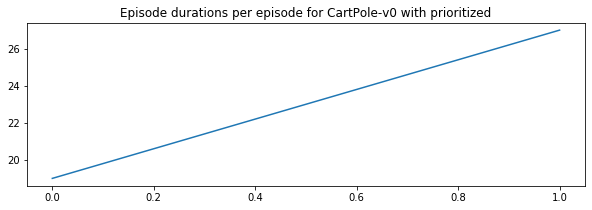


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 223.45it/s]

Total duration time:  0.012940645217895508


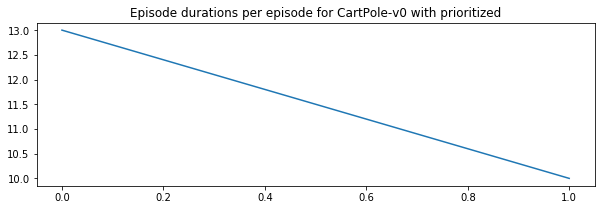


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 182.29it/s]

Total duration time:  0.014960765838623047


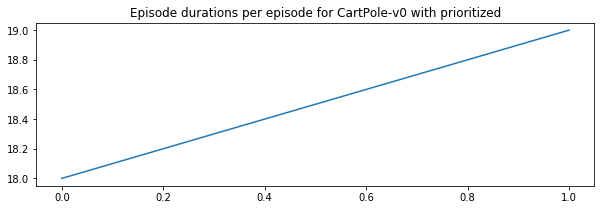


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 335.71it/s]

Total duration time:  0.008976936340332031


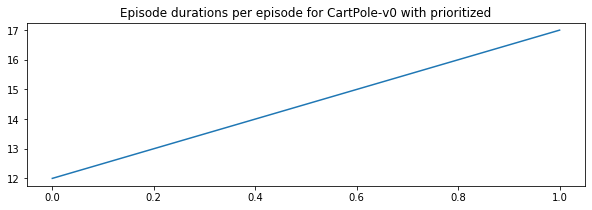


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 167.08it/s]

Total duration time:  0.01692342758178711


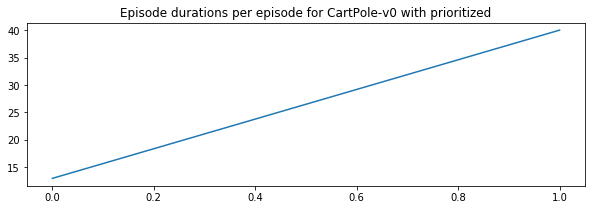


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 125.38it/s]

Total duration time:  0.01994943618774414


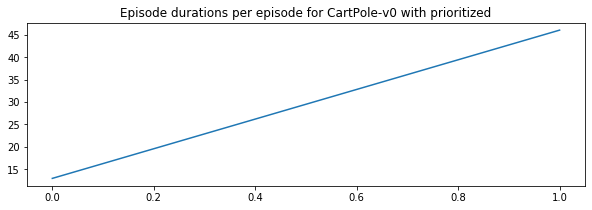


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 286.48it/s]

Total duration time:  0.009972810745239258


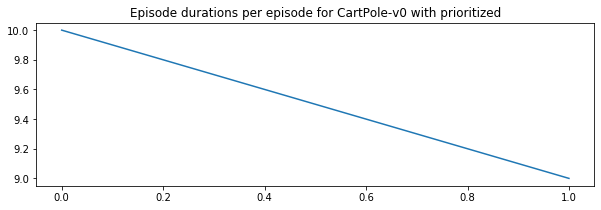


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 222.81it/s]

Total duration time:  0.012937545776367188


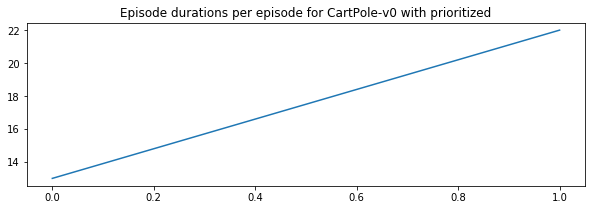


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 200.54it/s]

Total duration time:  0.013962030410766602


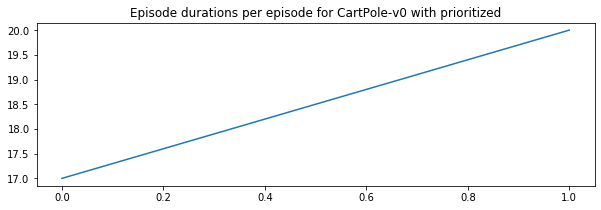


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 167.13it/s]

Total duration time:  0.014960289001464844


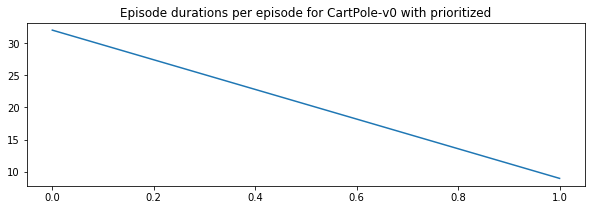


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 154.26it/s]

Total duration time:  0.016954898834228516


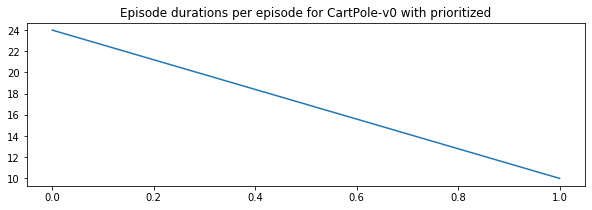


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 222.82it/s]

Total duration time:  0.012941360473632812


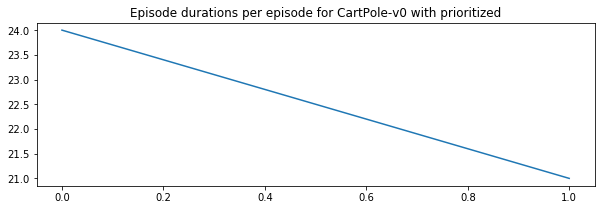


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 250.33it/s]

Total duration time:  0.012934446334838867


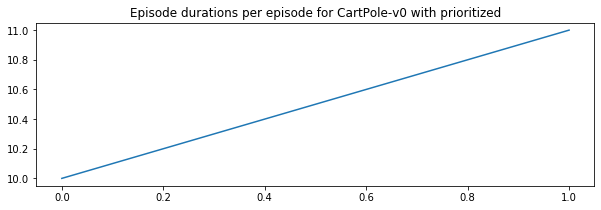


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 31.33it/s]

Total duration time:  0.06781840324401855


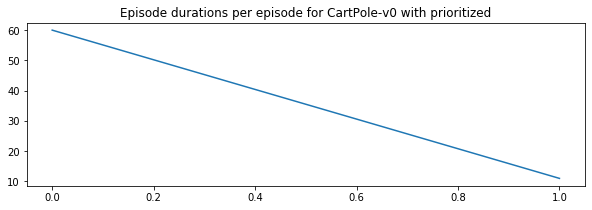


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 286.51it/s]

Total duration time:  0.009973526000976562


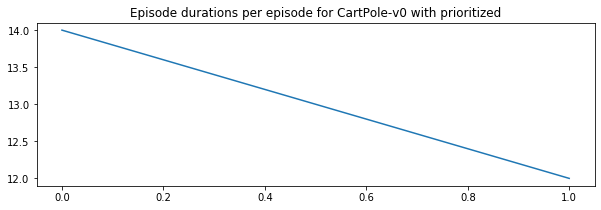


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 334.30it/s]

Total duration time:  0.009972333908081055


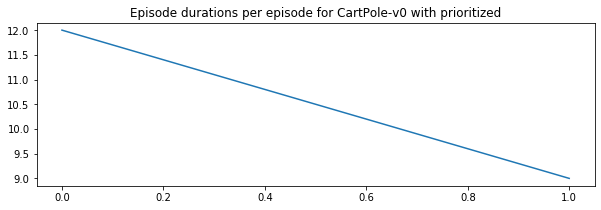


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 182.17it/s]

Total duration time:  0.016921520233154297


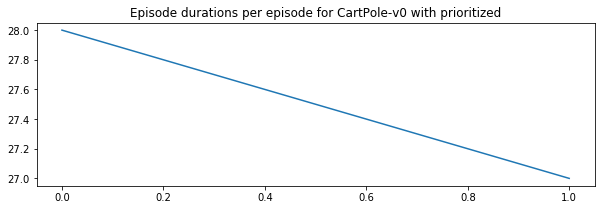


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 143.24it/s]

Total duration time:  0.017956018447875977


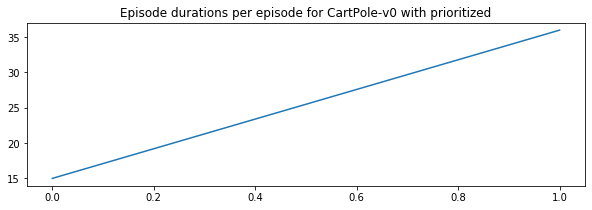


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 250.83it/s]

Total duration time:  0.011968135833740234


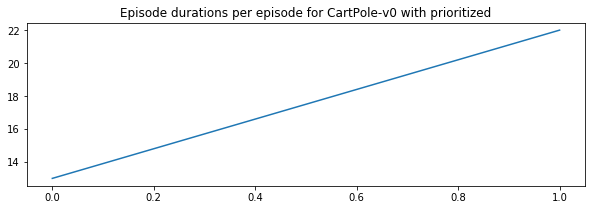


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 62.67it/s]

Total duration time:  0.0358729362487793


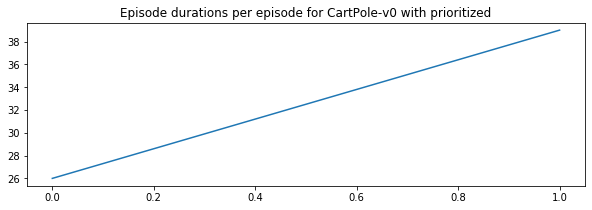


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 222.80it/s]

Total duration time:  0.014972209930419922


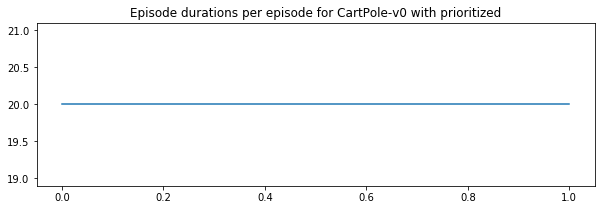


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 182.32it/s]

Total duration time:  0.012964725494384766


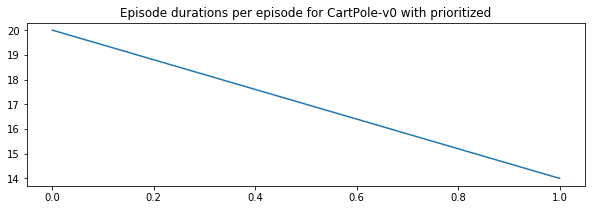


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 182.33it/s]

Total duration time:  0.014958620071411133


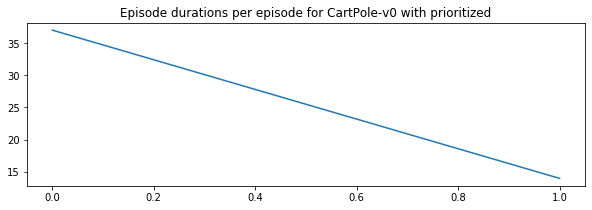


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.53it/s]

Total duration time:  0.17752623558044434


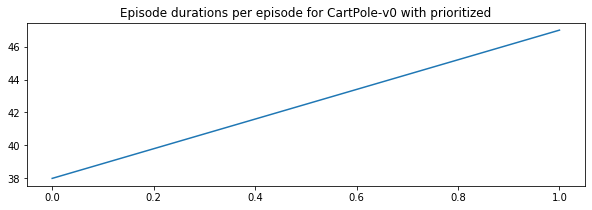


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.92it/s]

Total duration time:  0.12865567207336426


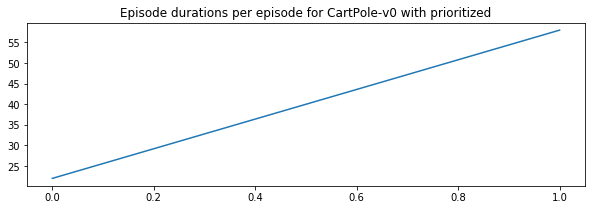


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.33it/s]

Total duration time:  0.09873652458190918


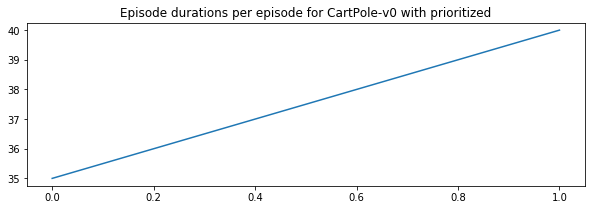


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 334.15it/s]

Total duration time:  0.009974479675292969


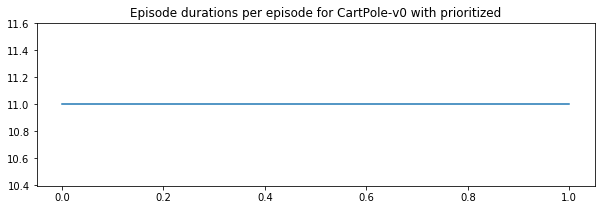


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 334.29it/s]

Total duration time:  0.010946273803710938


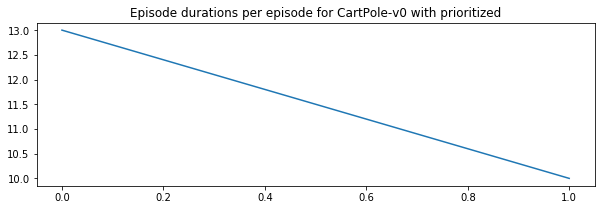


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 200.54it/s]

Total duration time:  0.014961004257202148


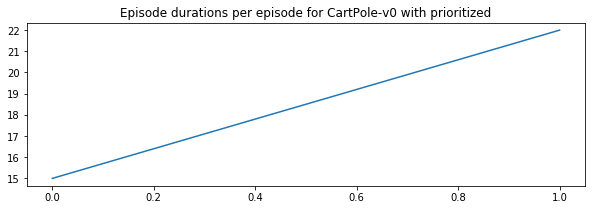


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 143.31it/s]

Total duration time:  0.017923355102539062


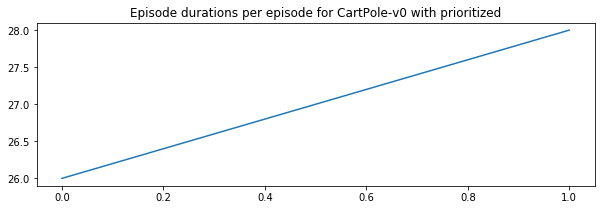


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 250.65it/s]

Total duration time:  0.011971235275268555


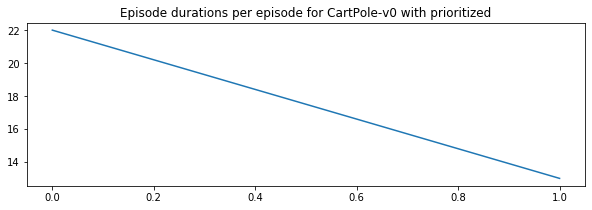


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 167.11it/s]

Total duration time:  0.016956090927124023


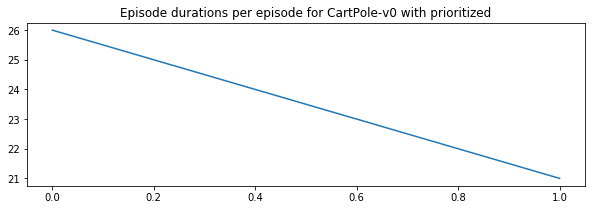


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.34it/s]

Total duration time:  0.2765007019042969


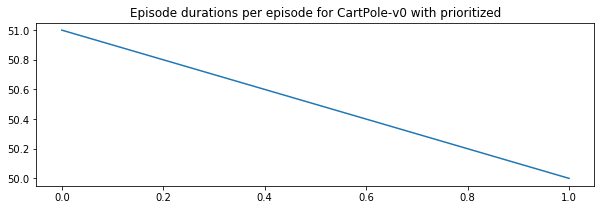


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 200.53it/s]

Total duration time:  0.014935016632080078


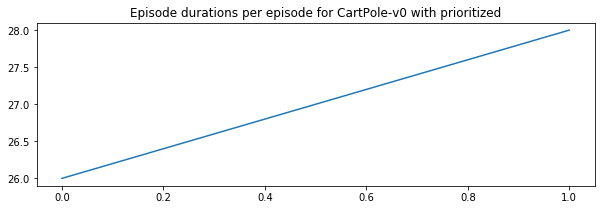


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 42.68it/s]

Total duration time:  0.05083131790161133


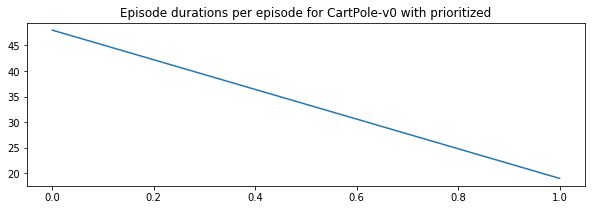


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 200.54it/s]

Total duration time:  0.011968612670898438


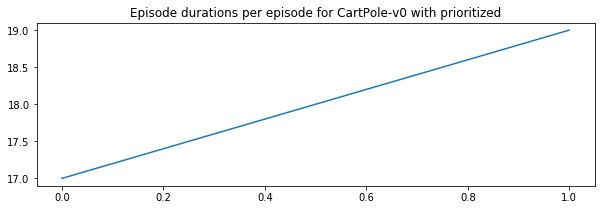


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 401.12it/s]

Total duration time:  0.00897526741027832


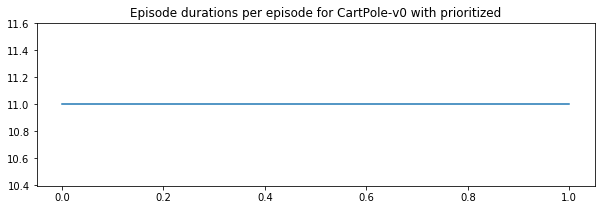


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 399.27it/s]

Total duration time:  0.010967016220092773


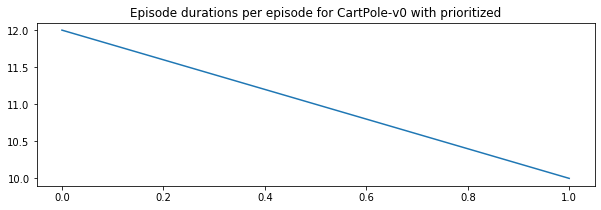


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 222.76it/s]

Total duration time:  0.014934539794921875


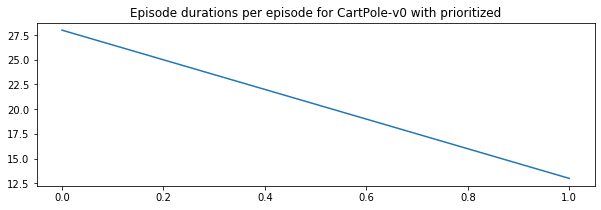


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 167.07it/s]

Total duration time:  0.015959501266479492


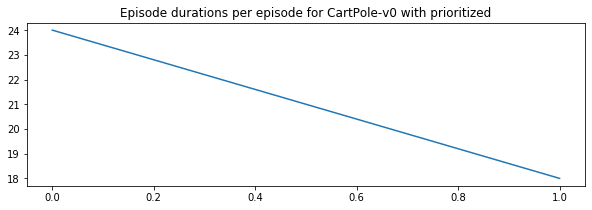


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 250.68it/s]

Total duration time:  0.011969327926635742


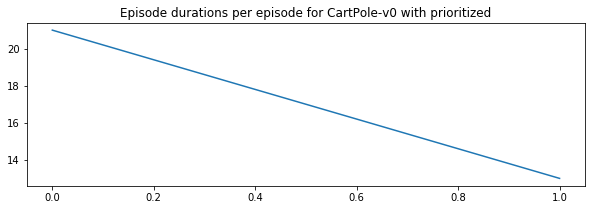


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 143.24it/s]

Total duration time:  0.017953872680664062


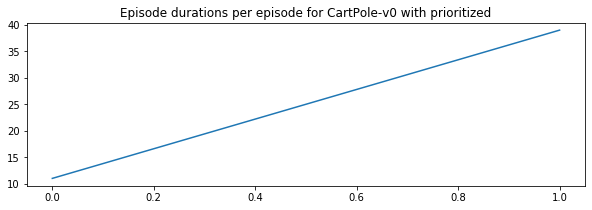


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 250.64it/s]

Total duration time:  0.01095724105834961


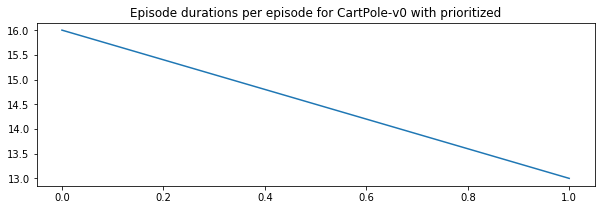


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 167.13it/s]

Total duration time:  0.014959335327148438


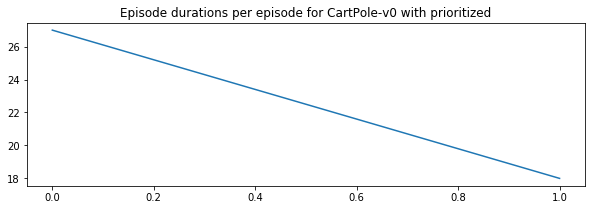


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 133.70it/s]

Total duration time:  0.018950462341308594


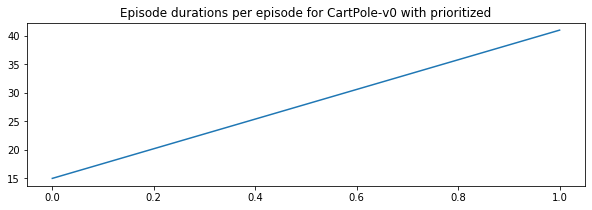


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 182.29it/s]

Total duration time:  0.014960527420043945


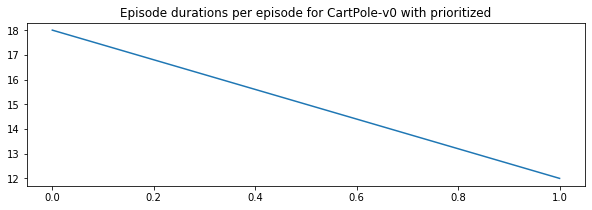


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 286.48it/s]

Total duration time:  0.009939432144165039


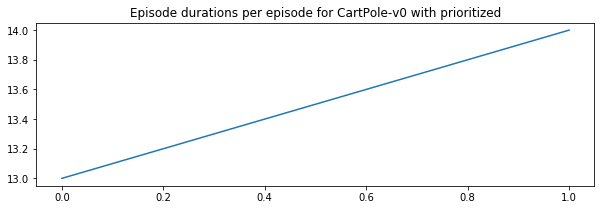


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 200.53it/s]

Total duration time:  0.014933347702026367


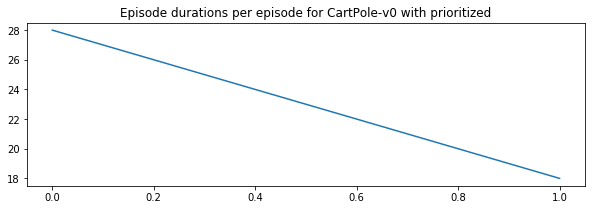


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 200.52it/s]

Total duration time:  0.014931440353393555


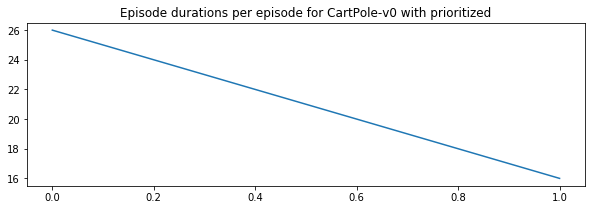


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 222.80it/s]

Total duration time:  0.013931751251220703


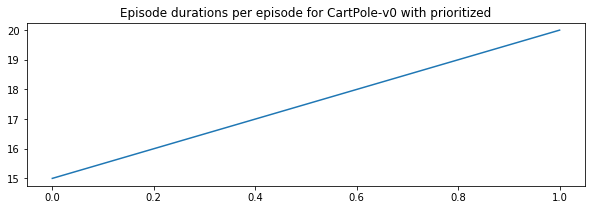


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 222.09it/s]

Total duration time:  0.013962984085083008


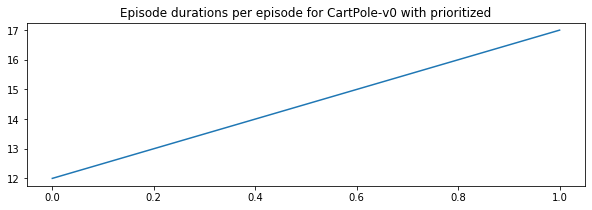


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 286.50it/s]

Total duration time:  0.011936664581298828


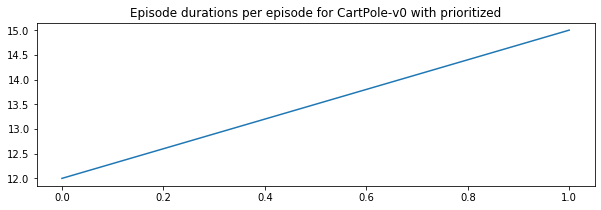


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 167.11it/s]

Total duration time:  0.015923023223876953


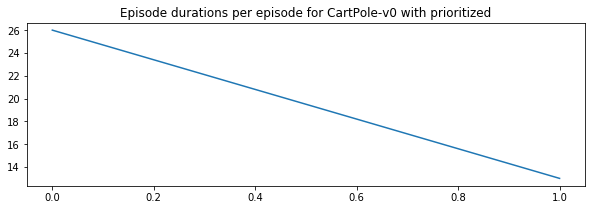


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 222.83it/s]

Total duration time:  0.011952638626098633


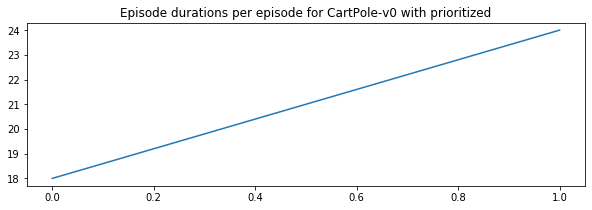


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 222.85it/s]

Total duration time:  0.014926910400390625


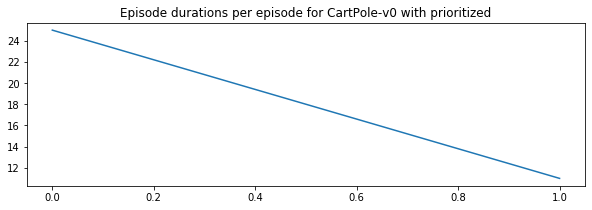


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 143.25it/s]

Total duration time:  0.016954421997070312


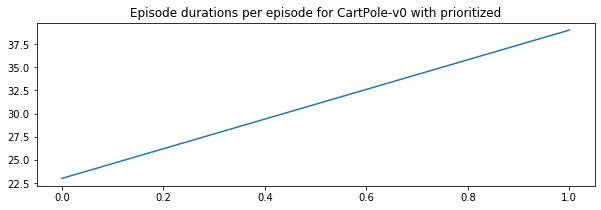


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 286.51it/s]

Total duration time:  0.010972023010253906


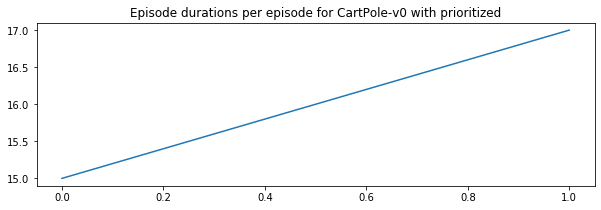


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 250.68it/s]

Total duration time:  0.010970830917358398


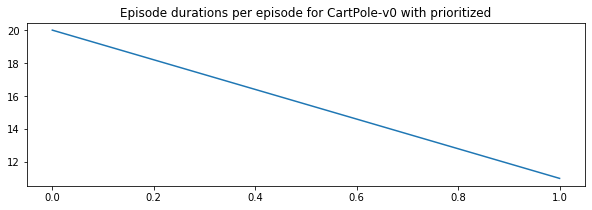


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 286.44it/s]

Total duration time:  0.010940074920654297


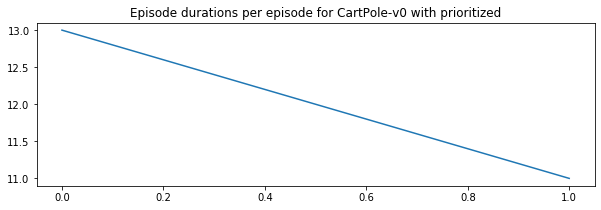


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 200.52it/s]

Total duration time:  0.01391911506652832


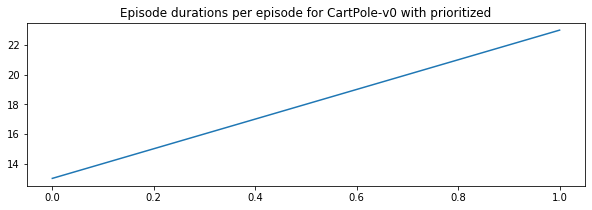


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 250.65it/s]

Total duration time:  0.011988162994384766


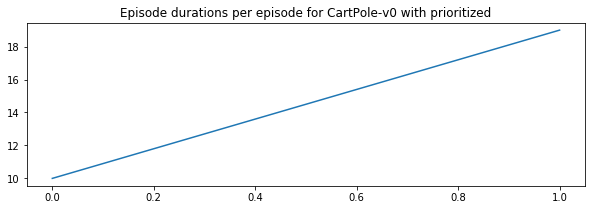


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 332.27it/s]

Total duration time:  0.009941339492797852


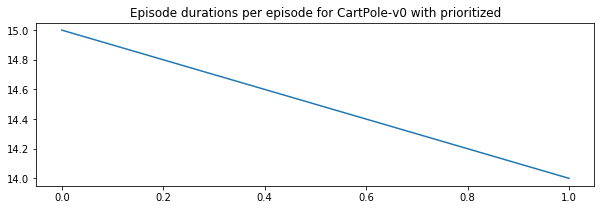


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 287.05it/s]

Total duration time:  0.011923789978027344


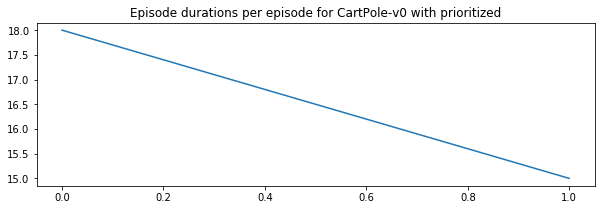


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.27it/s]

Total duration time:  0.32413530349731445


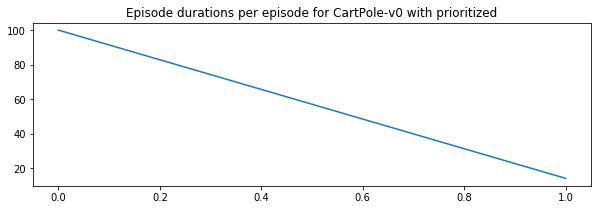


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 167.09it/s]

Total duration time:  0.015925168991088867


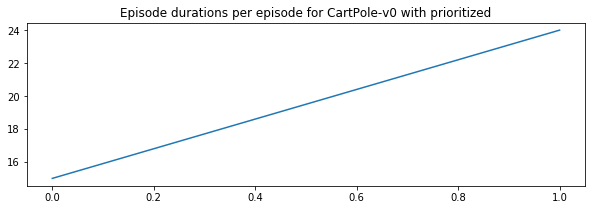


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 182.31it/s]

Total duration time:  0.01594686508178711


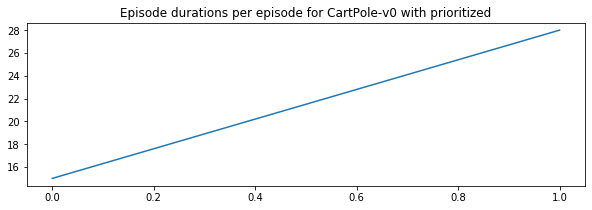


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 182.30it/s]

Total duration time:  0.014960289001464844


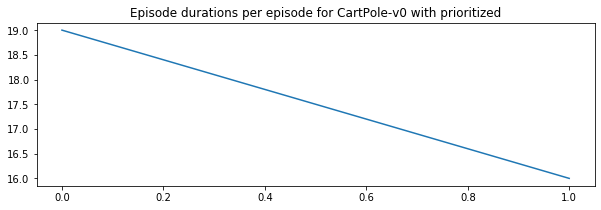


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.36it/s]

Total duration time:  0.46224236488342285


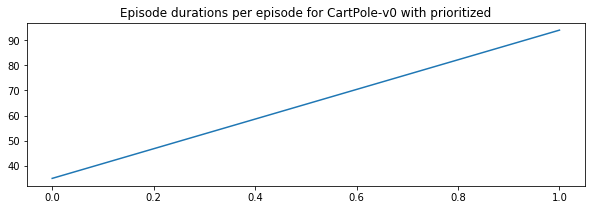


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 167.11it/s]

Total duration time:  0.015957355499267578


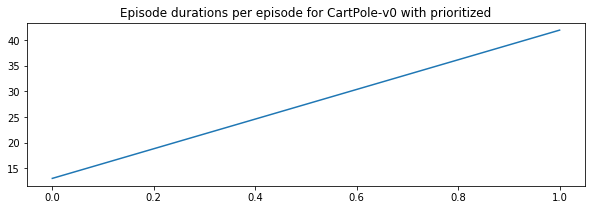


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 167.13it/s]

Total duration time:  0.01692795753479004


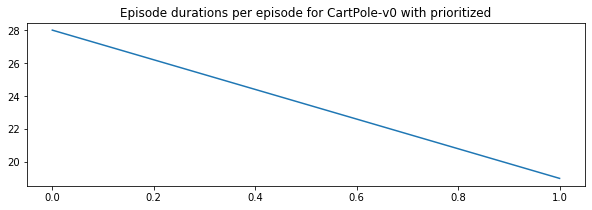


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 199.97it/s]

Total duration time:  0.015959978103637695


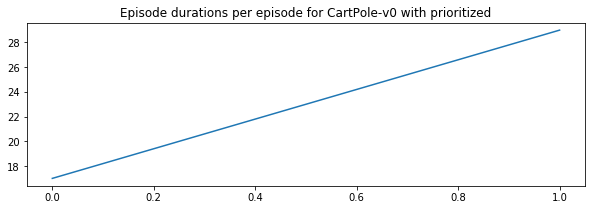


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 200.55it/s]

Total duration time:  0.013965368270874023


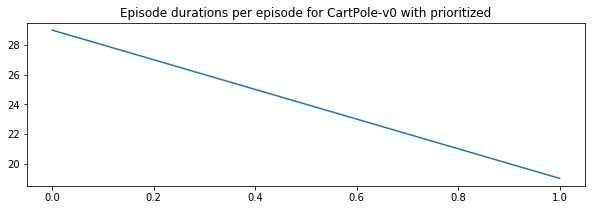


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 286.48it/s]

Total duration time:  0.011966705322265625


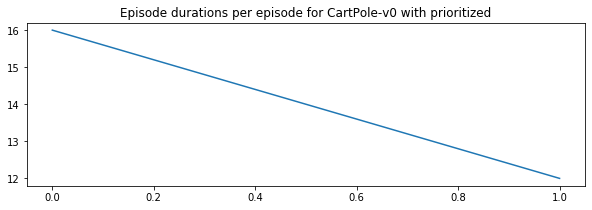


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 48.29it/s]

Total duration time:  0.044406890869140625


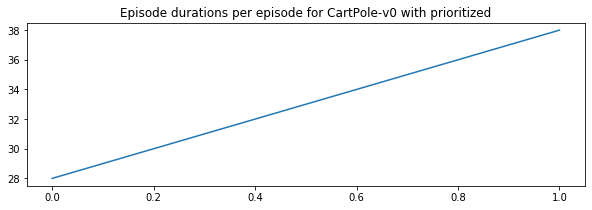


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 148.61it/s]

Total duration time:  0.017952680587768555


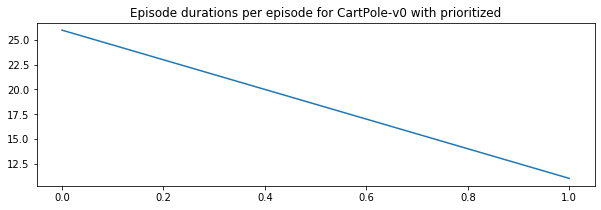


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.89it/s]

Total duration time:  0.10073113441467285


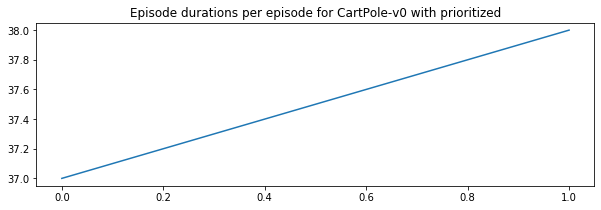


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 250.67it/s]

Total duration time:  0.010970115661621094


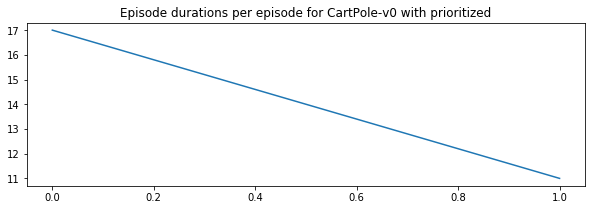


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 222.83it/s]

Total duration time:  0.013964176177978516


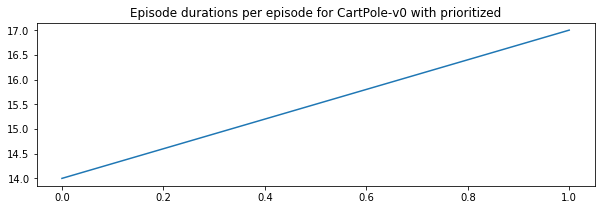


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 167.05it/s]

Total duration time:  0.015958547592163086


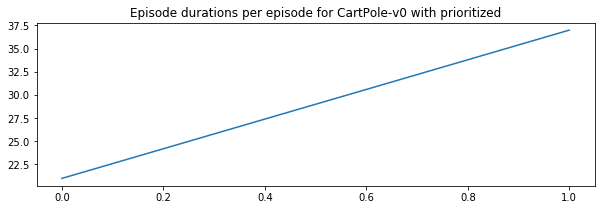


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 133.68it/s]

Total duration time:  0.019947528839111328


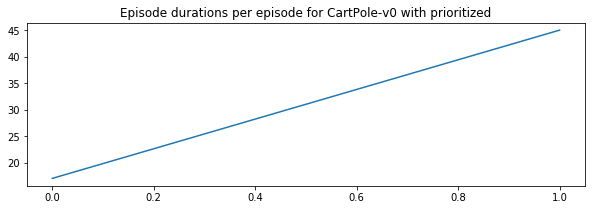


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 250.08it/s]

Total duration time:  0.011949300765991211


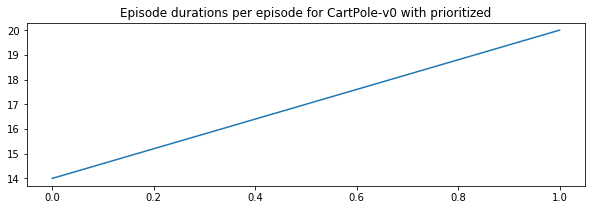


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 286.47it/s]

Total duration time:  0.010971307754516602


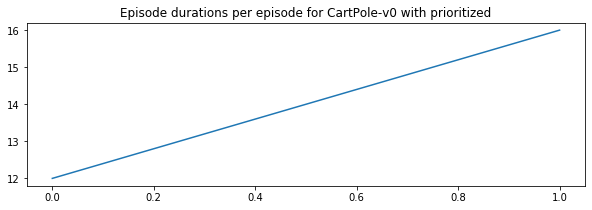


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 167.18it/s]

Total duration time:  0.016957521438598633


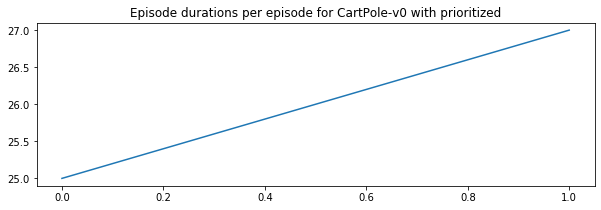


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 117.95it/s]

Total duration time:  0.020943880081176758


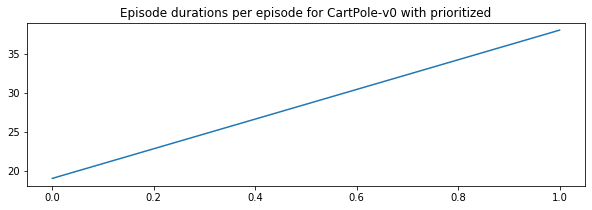


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 222.82it/s]

Total duration time:  0.012966394424438477


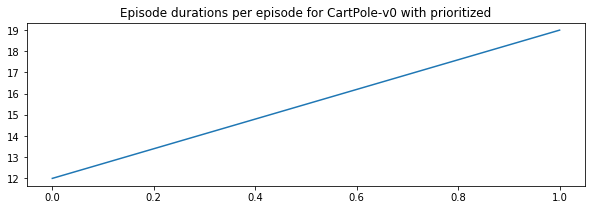


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 223.01it/s]

Total duration time:  0.013962984085083008


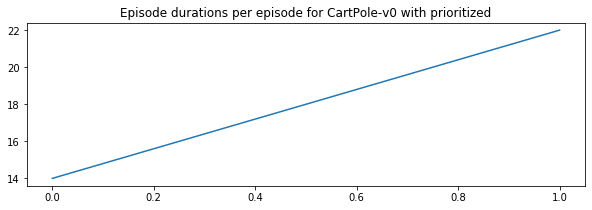


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 154.25it/s]

Total duration time:  0.01795482635498047


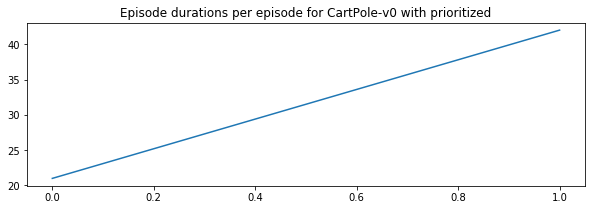


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 223.10it/s]

Total duration time:  0.013962268829345703


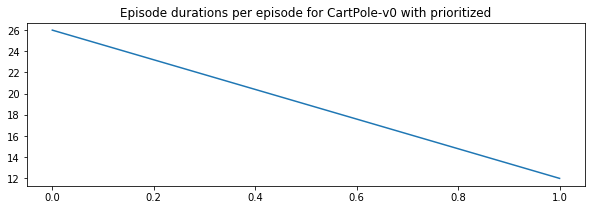


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.65it/s]

Total duration time:  0.16456031799316406


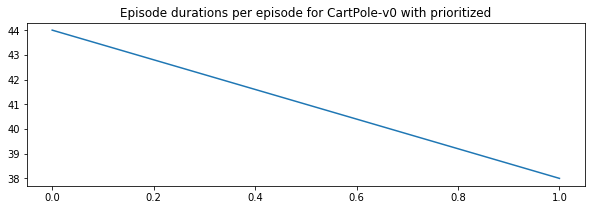


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 222.82it/s]

Total duration time:  0.013964653015136719


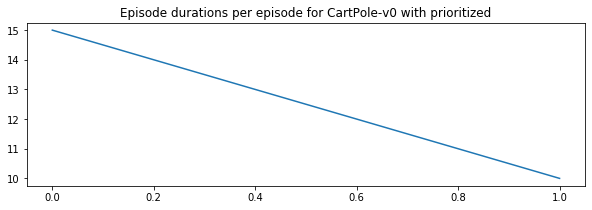


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 182.28it/s]

Total duration time:  0.014946937561035156


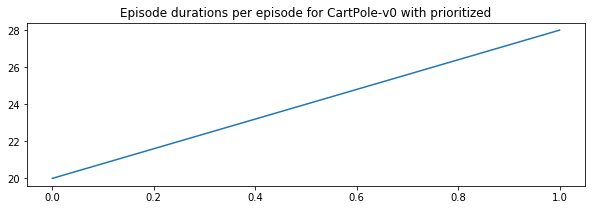


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 17.90it/s]

Total duration time:  0.11569833755493164


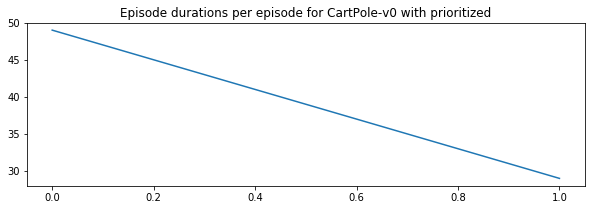


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 222.83it/s]

Total duration time:  0.01196146011352539


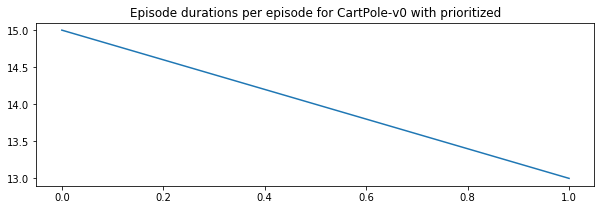


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 182.40it/s]

Total duration time:  0.015132427215576172


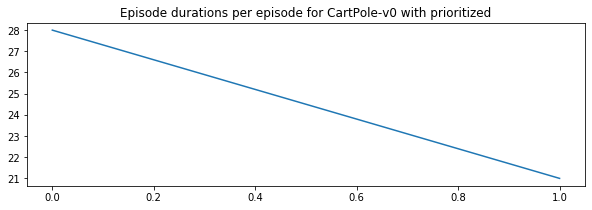


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 222.36it/s]

Total duration time:  0.011957168579101562


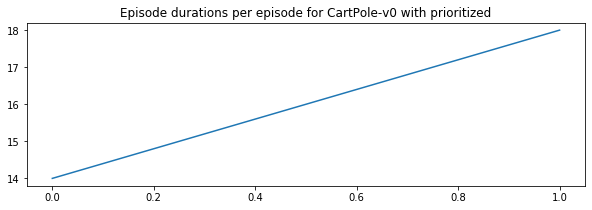


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 39.32it/s]

Total duration time:  0.05383014678955078


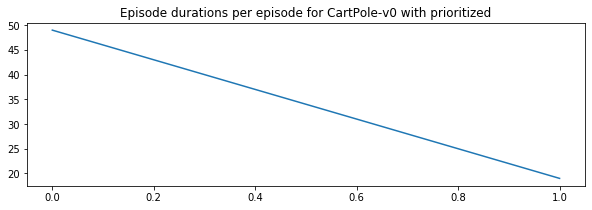


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 154.25it/s]

Total duration time:  0.01593017578125


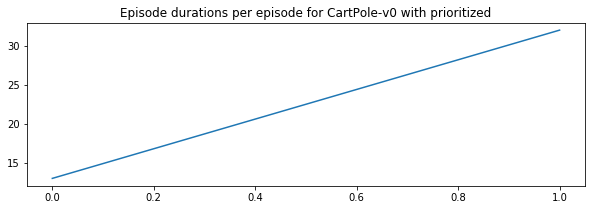


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 222.83it/s]

Total duration time:  0.013912677764892578


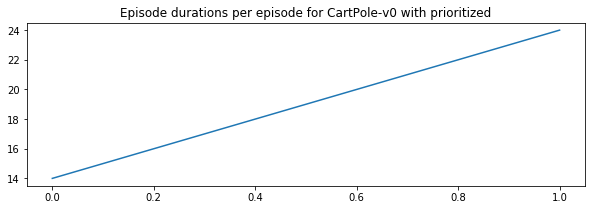


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 286.19it/s]

Total duration time:  0.011933565139770508


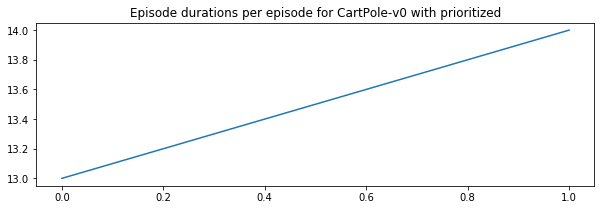


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 199.98it/s]

Total duration time:  0.012966394424438477


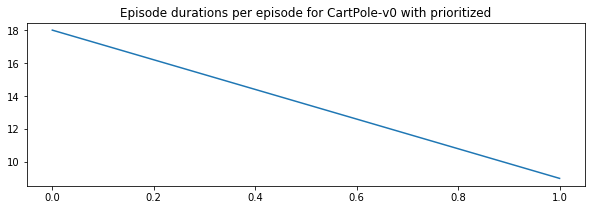


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 223.81it/s]

Total duration time:  0.012933015823364258


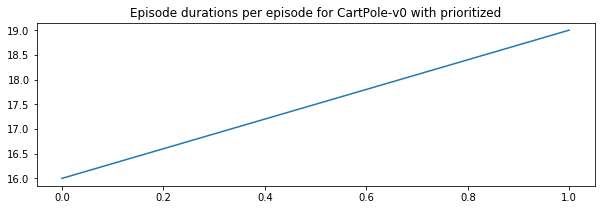


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 154.26it/s]

Total duration time:  0.017953157424926758


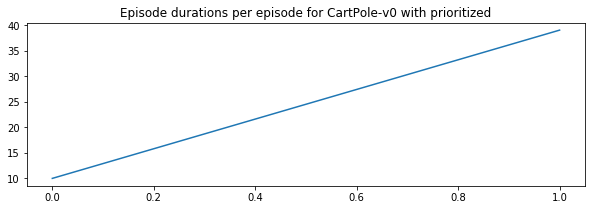


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 200.15it/s]

Total duration time:  0.013944864273071289


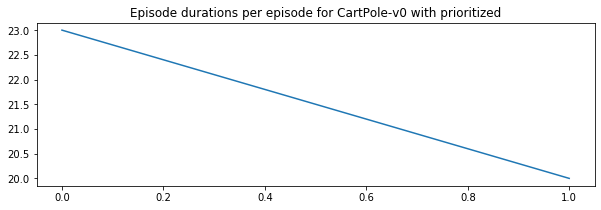


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 252.02it/s]

Total duration time:  0.011936664581298828


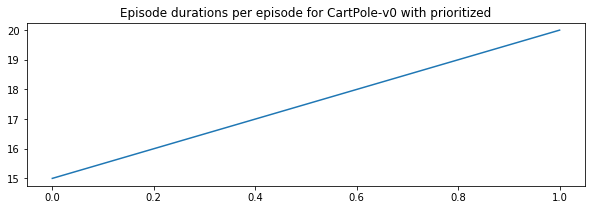


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.89it/s]

Total duration time:  0.10070300102233887


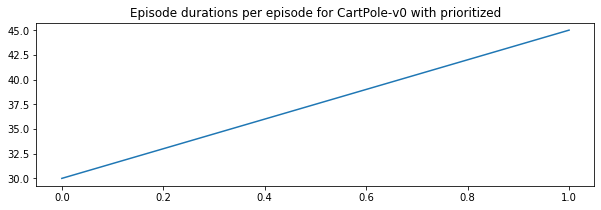


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 143.24it/s]

Total duration time:  0.017952919006347656


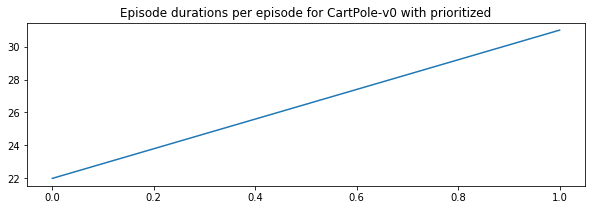


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 333.85it/s]

Total duration time:  0.009972095489501953


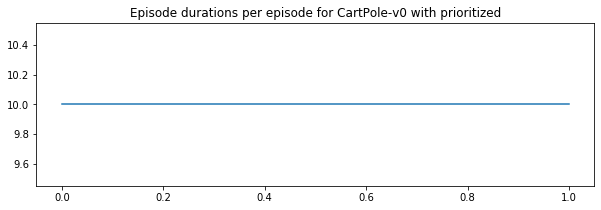


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 250.65it/s]

Total duration time:  0.011929988861083984


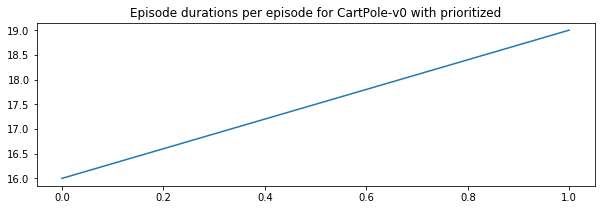


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 223.14it/s]

Total duration time:  0.013929605484008789


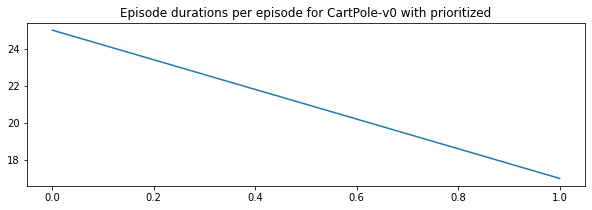


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 286.34it/s]

Total duration time:  0.01294255256652832


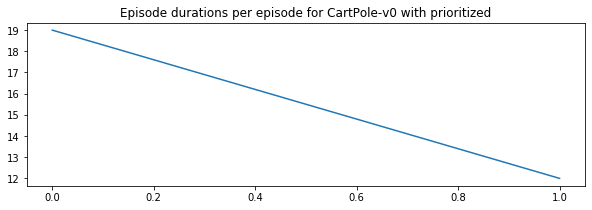


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 250.65it/s]

Total duration time:  0.01193857192993164


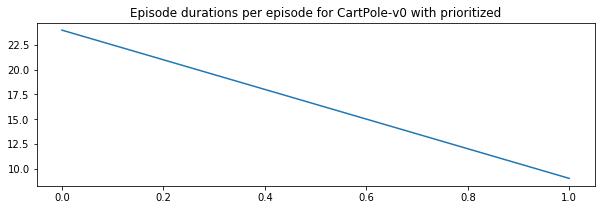


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 286.44it/s]

Total duration time:  0.011942863464355469


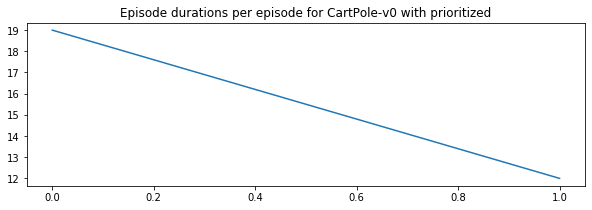


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 182.33it/s]

Total duration time:  0.014961719512939453


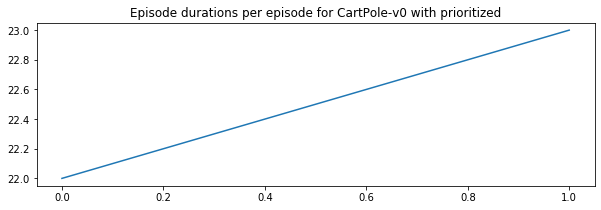


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 286.50it/s]

Total duration time:  0.011969566345214844


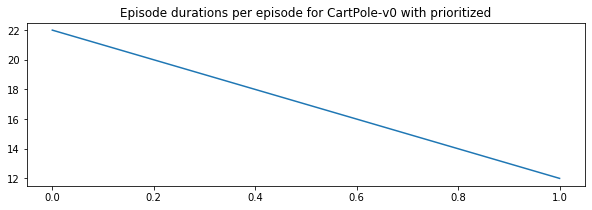


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 37.14it/s]

Total duration time:  0.05881643295288086


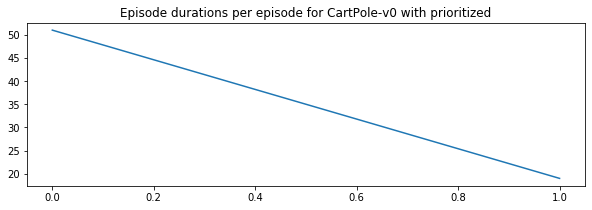


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 182.32it/s]

Total duration time:  0.015958309173583984


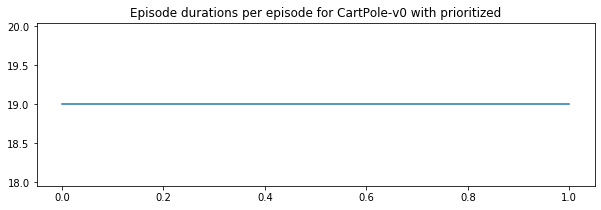


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 251.25it/s]

Total duration time:  0.01194310188293457


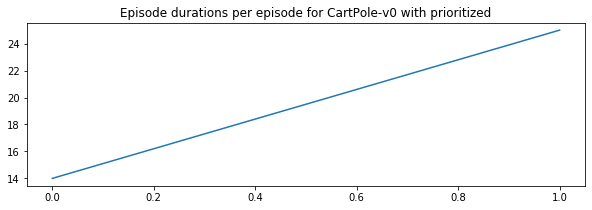


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 200.25it/s]

Total duration time:  0.01496267318725586


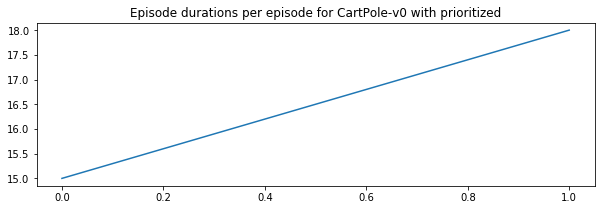


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 167.10it/s]

Total duration time:  0.014986515045166016


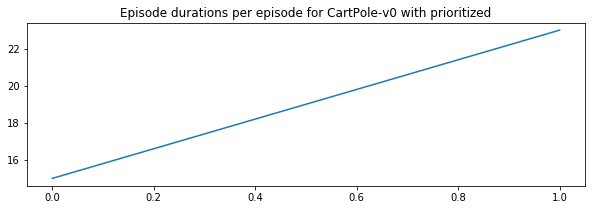


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.87it/s]

Total duration time:  0.22935819625854492


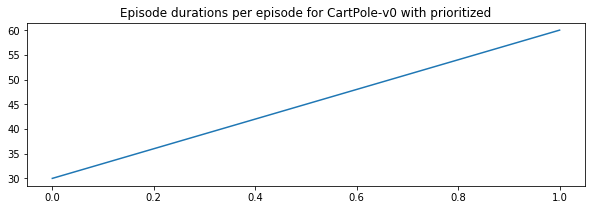


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 200.11it/s]

Total duration time:  0.015982866287231445


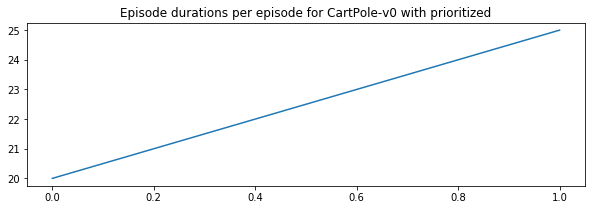


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 200.44it/s]

Total duration time:  0.013929605484008789


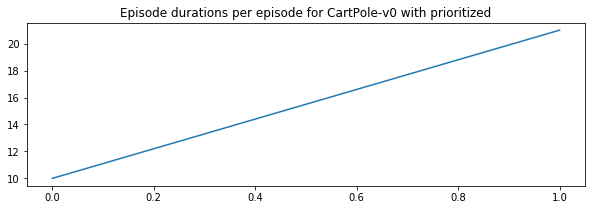


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 397.64it/s]

Total duration time:  0.009940862655639648


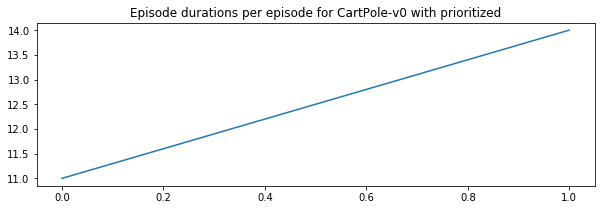


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 223.57it/s]

Total duration time:  0.012937068939208984


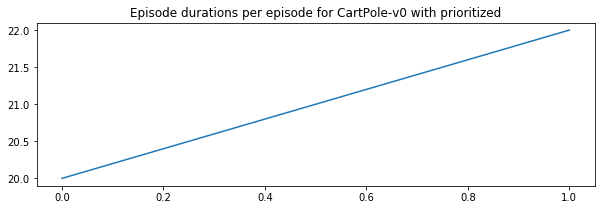


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 182.30it/s]

Total duration time:  0.014916181564331055


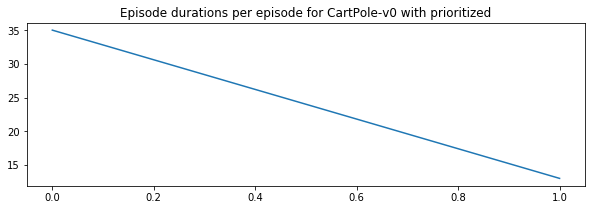


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 200.52it/s]

Total duration time:  0.013936996459960938


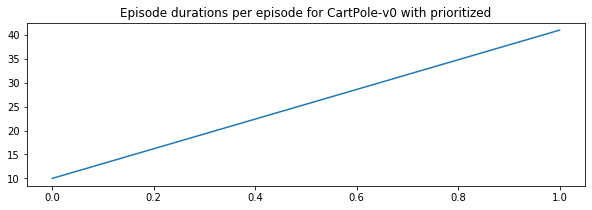


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 222.85it/s]

Total duration time:  0.011968612670898438


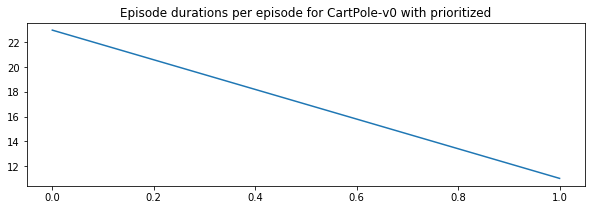


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 286.16it/s]

Total duration time:  0.011965036392211914


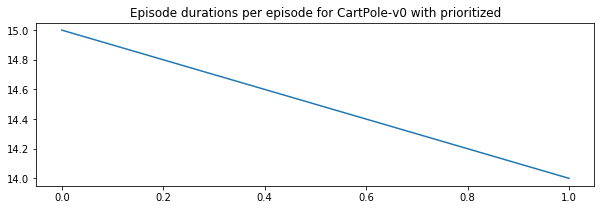


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 222.85it/s]

Total duration time:  0.013931512832641602


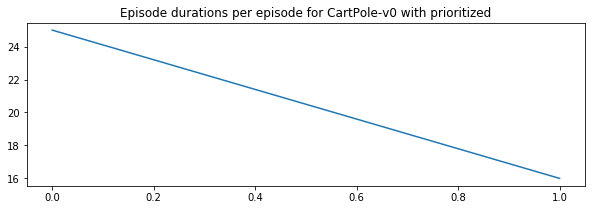


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.79it/s]

Total duration time:  0.0957181453704834


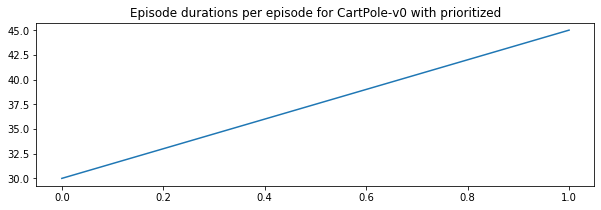


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 111.32it/s]

Total duration time:  0.02191019058227539


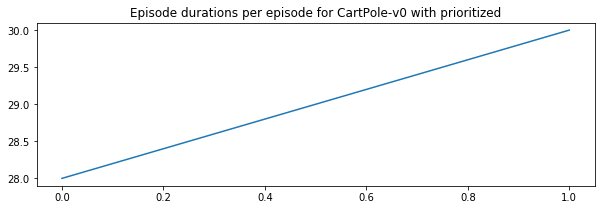


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 401.14it/s]

Total duration time:  0.007989168167114258


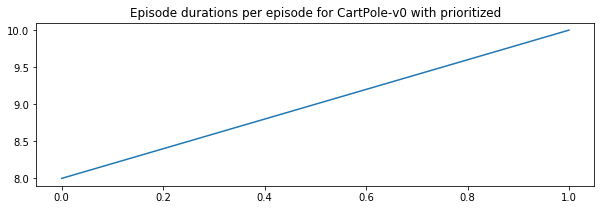


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 287.34it/s]

Total duration time:  0.01093745231628418


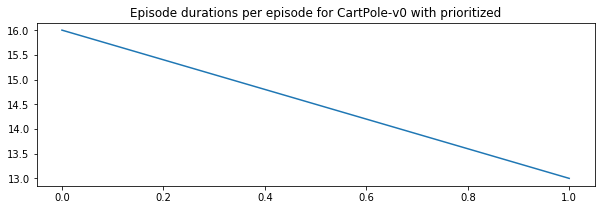


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 221.99it/s]

Total duration time:  0.012941122055053711


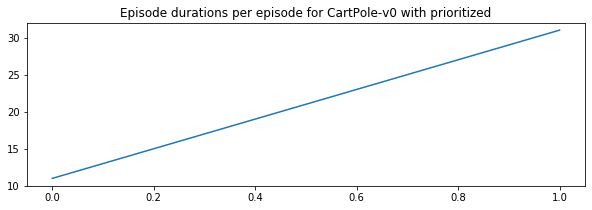


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 118.16it/s]

Total duration time:  0.019925594329833984


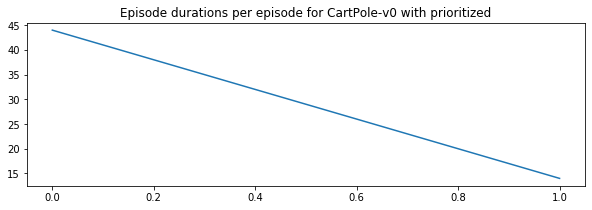


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 200.55it/s]

Total duration time:  0.013947486877441406


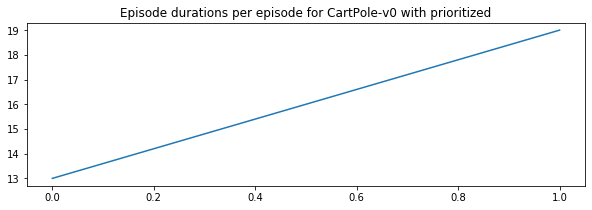


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 223.11it/s]

Total duration time:  0.015925884246826172


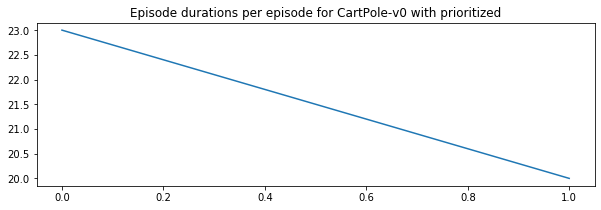


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 95.50it/s]

Total duration time:  0.02393627166748047


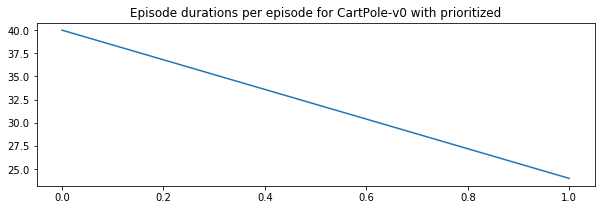


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 182.31it/s]

Total duration time:  0.015990018844604492


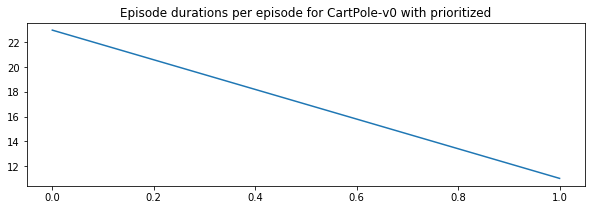


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 182.32it/s]

Total duration time:  0.015926599502563477


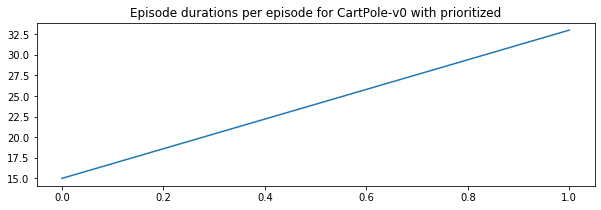


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 60.75it/s]

Total duration time:  0.03684282302856445


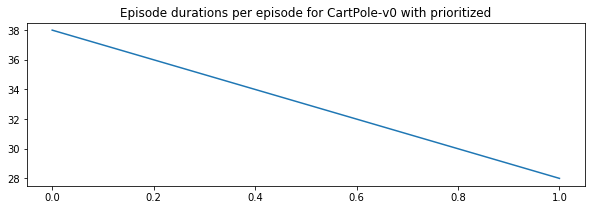


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 24.15it/s]

Total duration time:  0.08776473999023438


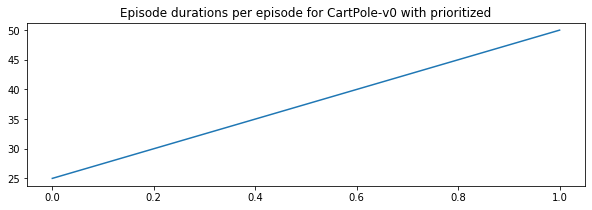


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 167.12it/s]

Total duration time:  0.015955209732055664


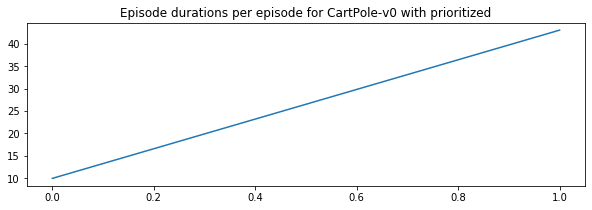


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/it]

Total duration time:  2.144268751144409


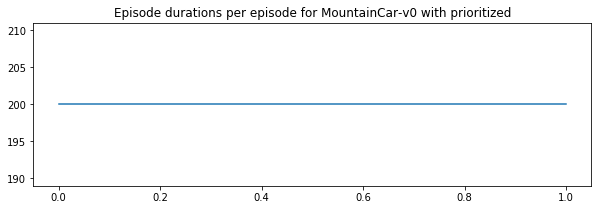


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.05s/it]

Total duration time:  2.1135034561157227


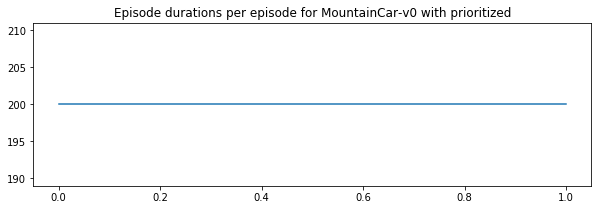


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.04s/it]

Total duration time:  2.0874063968658447


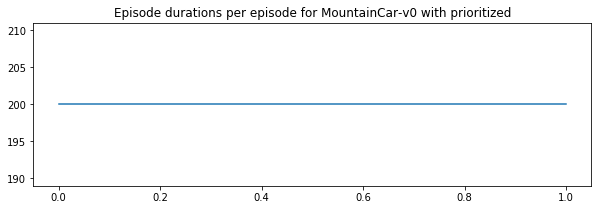


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/it]

Total duration time:  2.136263132095337


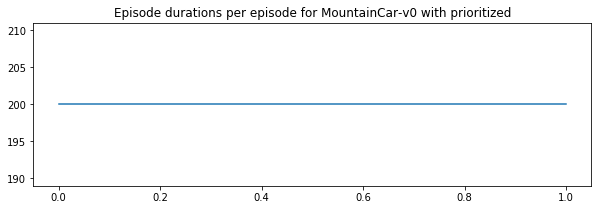


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.05s/it]

Total duration time:  2.0984013080596924


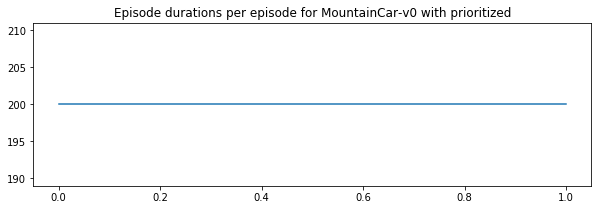


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.05s/it]

Total duration time:  2.1020278930664062


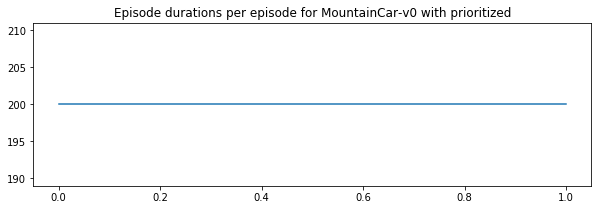


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.00it/s]

Total duration time:  1.9961731433868408


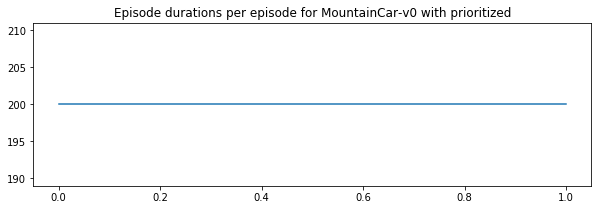


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]

Total duration time:  2.060011148452759


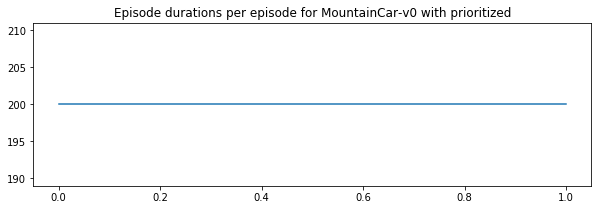


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.02s/it]

Total duration time:  2.0505175590515137


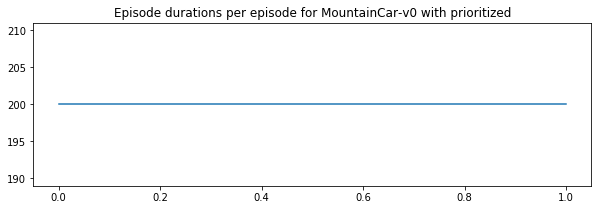


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/it]

Total duration time:  2.167720317840576


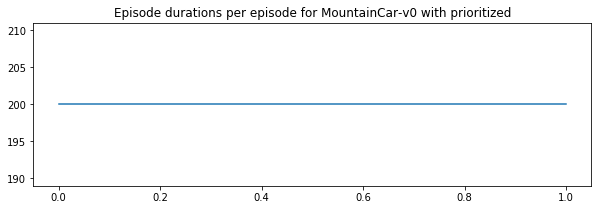


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.02s/it]

Total duration time:  2.0410518646240234


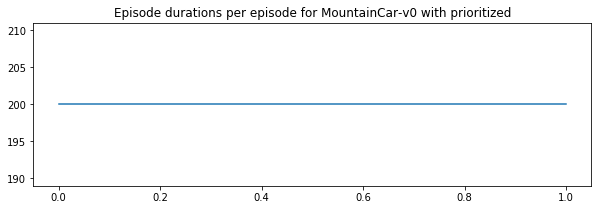


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]

Total duration time:  2.0624876022338867


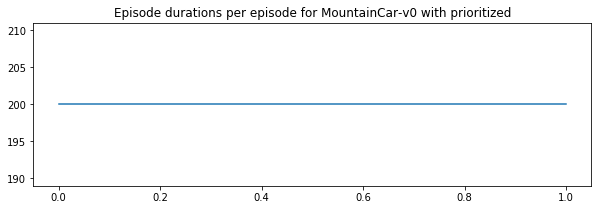


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.05s/it]

Total duration time:  2.097393751144409


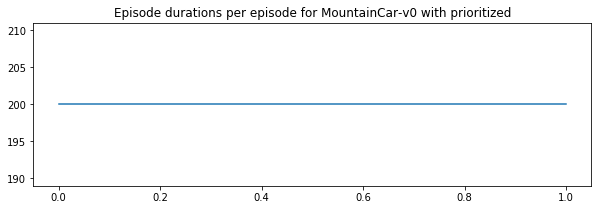


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.02it/s]

Total duration time:  1.964266061782837


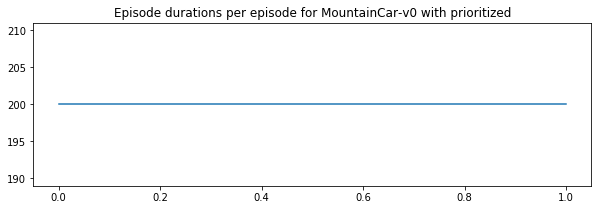


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.01it/s]

Total duration time:  1.9846951961517334


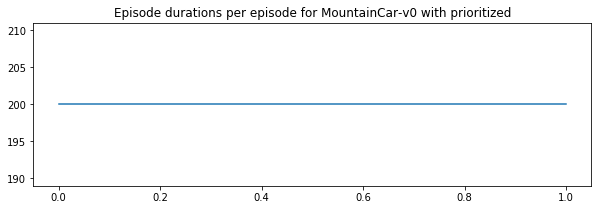


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.01s/it]

Total duration time:  2.0230979919433594


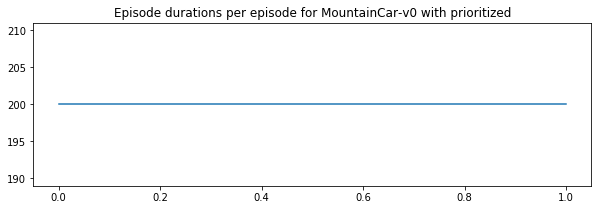


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.03it/s]

Total duration time:  1.941328525543213


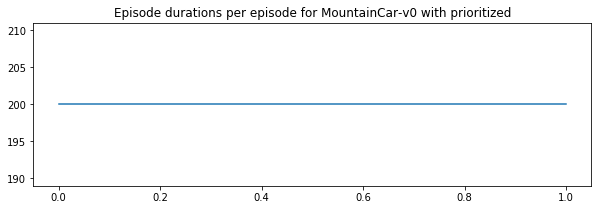


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.02s/it]

Total duration time:  2.043041706085205


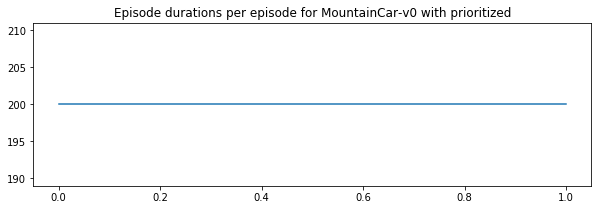


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.03it/s]

Total duration time:  1.942807912826538


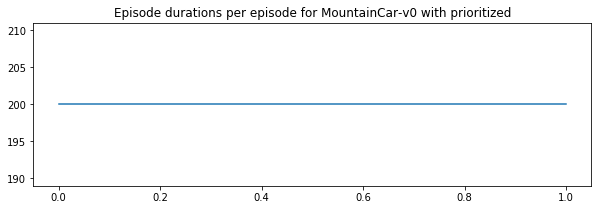


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/it]

Total duration time:  2.1833760738372803


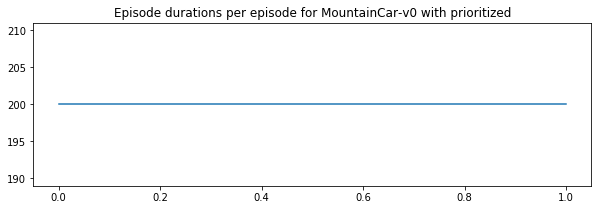


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]

Total duration time:  2.072035551071167


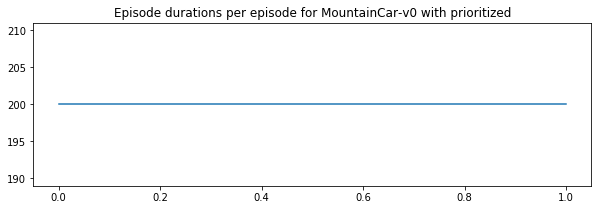


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.04it/s]

Total duration time:  1.9348297119140625


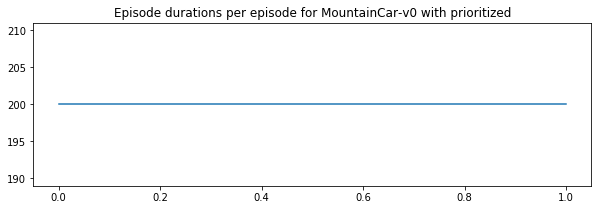


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.05s/it]

Total duration time:  2.1088733673095703


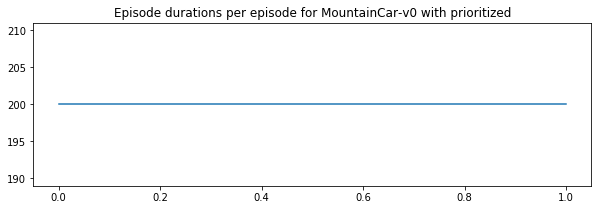


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.02s/it]

Total duration time:  2.0529448986053467


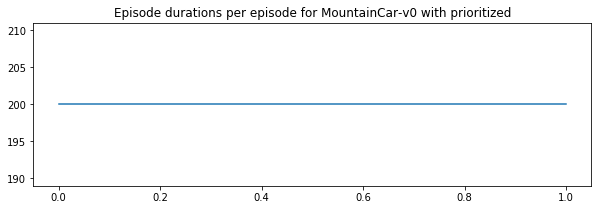


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.06s/it]

Total duration time:  2.117361307144165


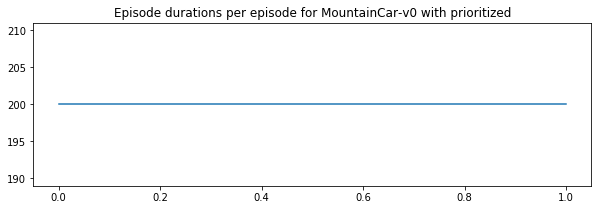


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.05s/it]

Total duration time:  2.108870506286621


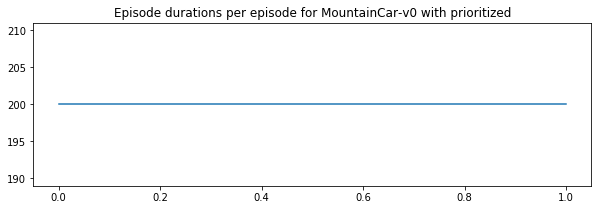


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.06s/it]

Total duration time:  2.1150128841400146


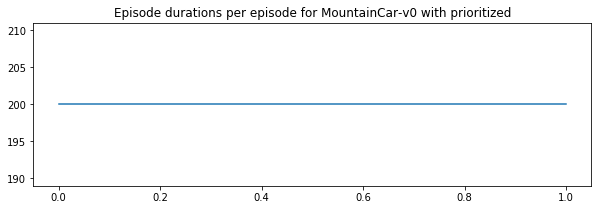


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.05s/it]

Total duration time:  2.106370449066162


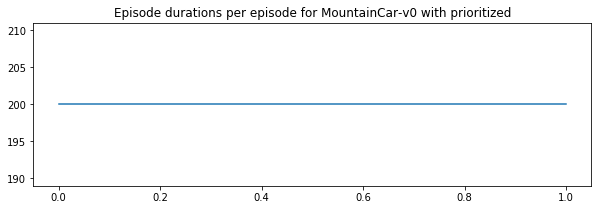


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/it]

Total duration time:  2.237539052963257


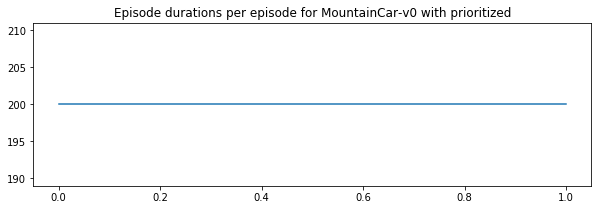


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.01it/s]

Total duration time:  1.9762251377105713


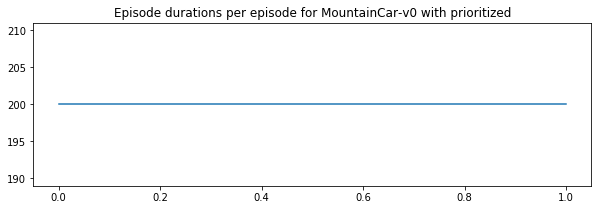


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.02s/it]

Total duration time:  2.053499221801758


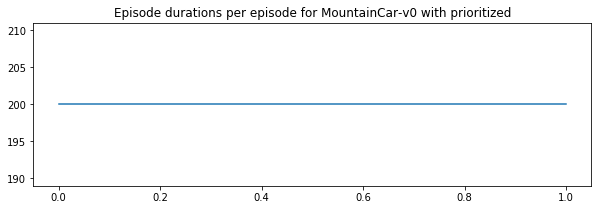


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.05it/s]

Total duration time:  1.9178988933563232


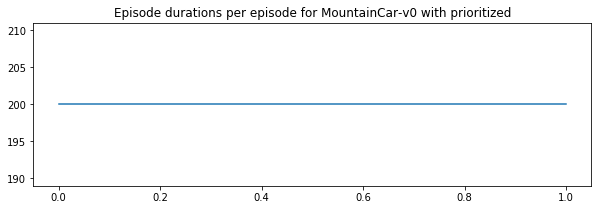


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.03it/s]

Total duration time:  1.9457979202270508


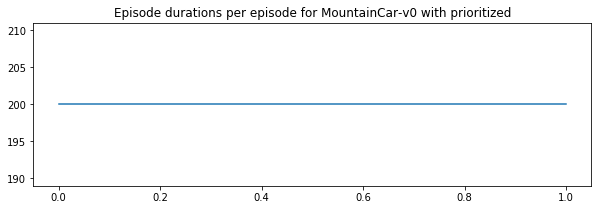


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.08it/s]

Total duration time:  1.856039047241211


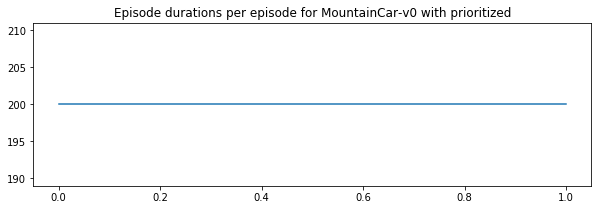


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.08it/s]

Total duration time:  1.8630192279815674


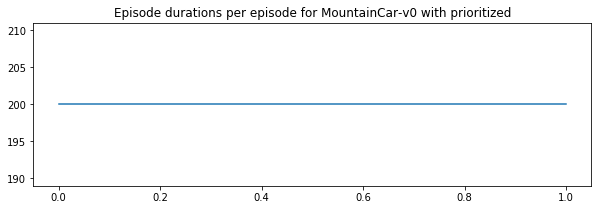


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.02s/it]

Total duration time:  2.0360755920410156


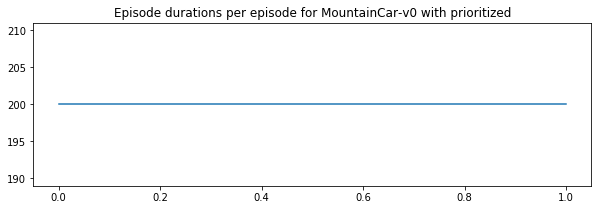


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]

Total duration time:  2.070465564727783


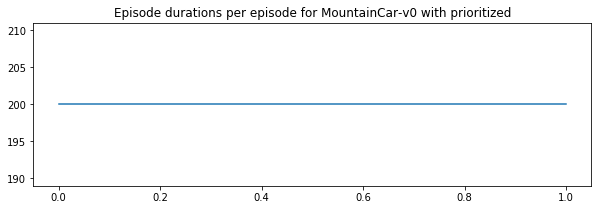


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]

Total duration time:  2.069972515106201


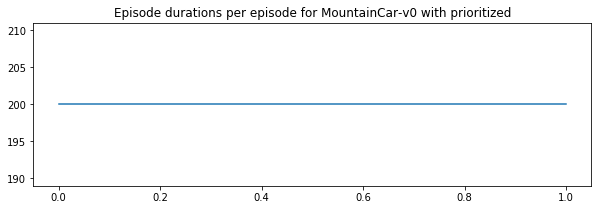


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.05s/it]

Total duration time:  2.1078875064849854


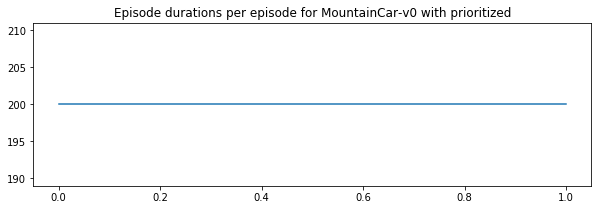


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/it]

Total duration time:  2.166210174560547


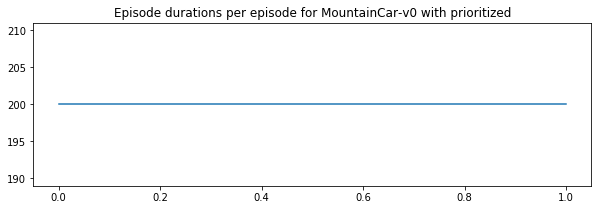


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]

Total duration time:  2.0614914894104004


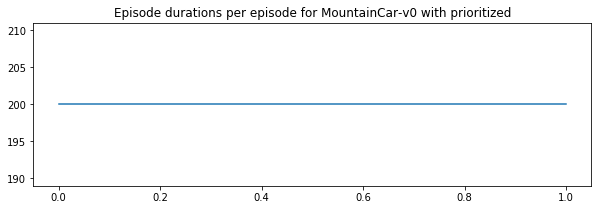


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/it]

Total duration time:  2.172194480895996


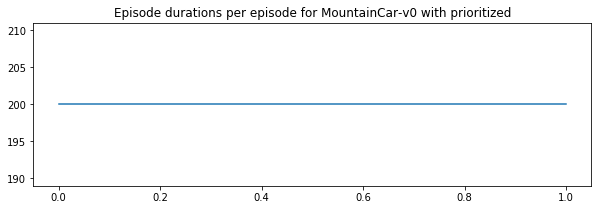


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/it]

Total duration time:  2.191143035888672


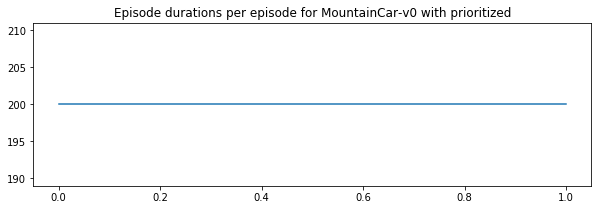


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.04s/it]

Total duration time:  2.0904130935668945


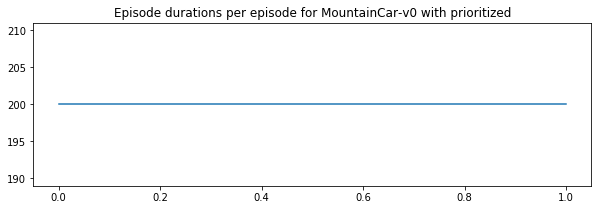


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.05s/it]

Total duration time:  2.1028897762298584


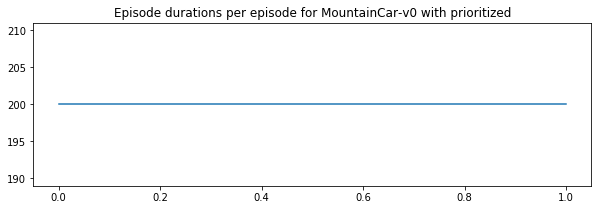


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.04s/it]

Total duration time:  2.0745012760162354


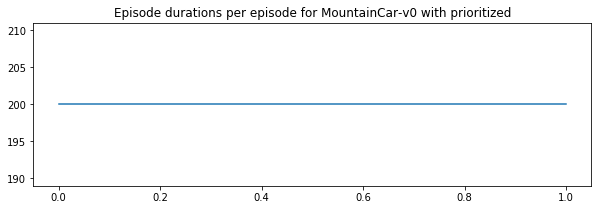


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.02s/it]

Total duration time:  2.0445618629455566


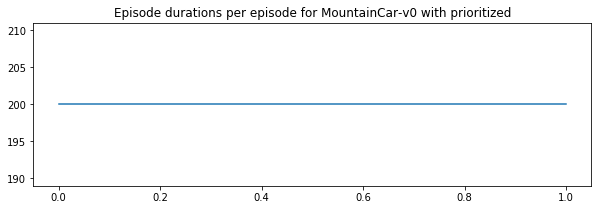


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.06it/s]

Total duration time:  1.8889505863189697


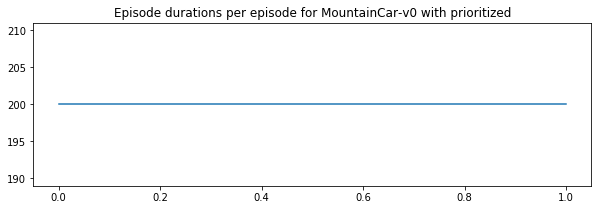


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.05it/s]

Total duration time:  1.917382001876831


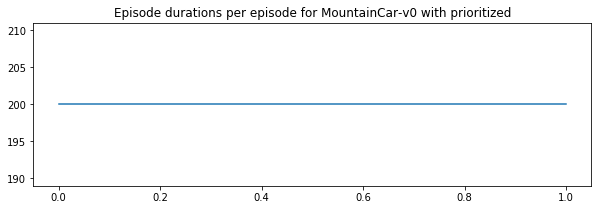


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.05it/s]

Total duration time:  1.9088966846466064


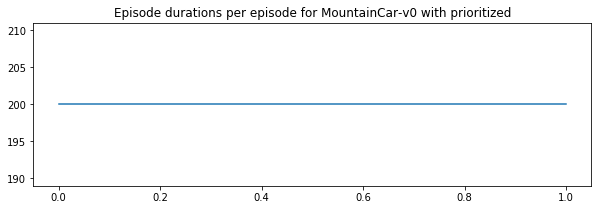


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.03it/s]

Total duration time:  1.947321891784668


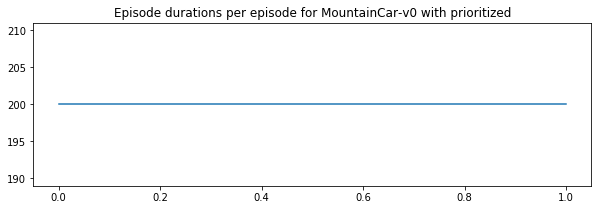


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.03it/s]

Total duration time:  1.9438056945800781


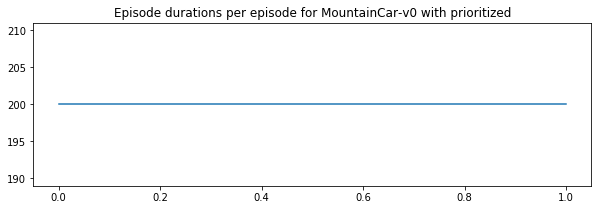


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.05it/s]

Total duration time:  1.904461145401001


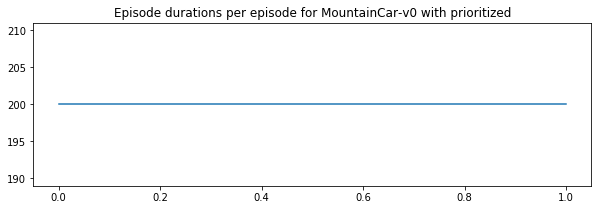


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.03it/s]

Total duration time:  1.939321517944336


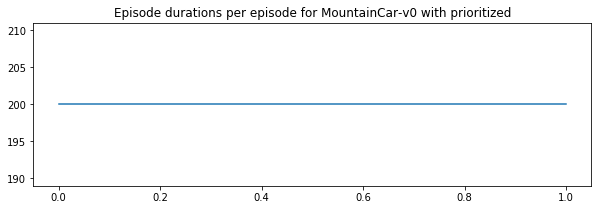


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.07it/s]

Total duration time:  1.8755152225494385


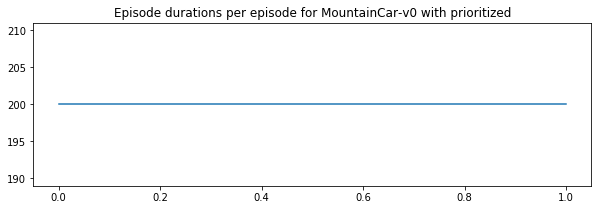


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]

Total duration time:  2.068976640701294


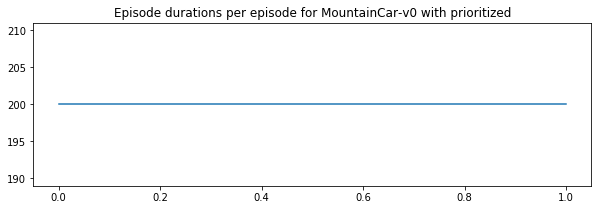


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.06s/it]

Total duration time:  2.123337984085083


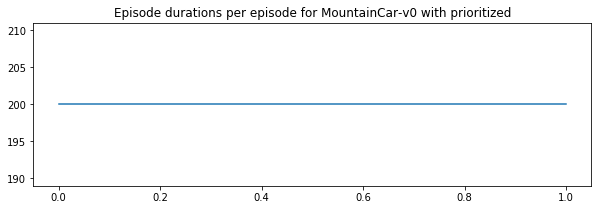


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.05s/it]

Total duration time:  2.103884220123291


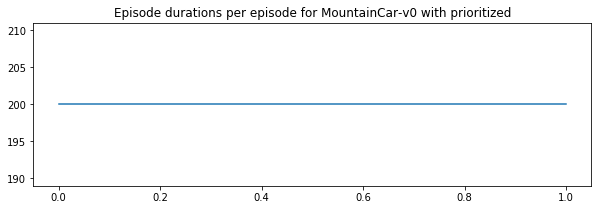


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.01it/s]

Total duration time:  1.9896819591522217


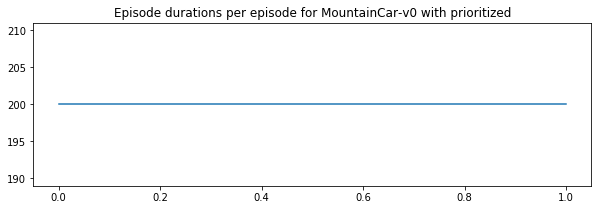


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.01it/s]

Total duration time:  1.985408067703247


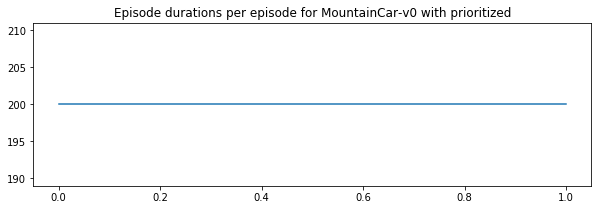


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.00s/it]

Total duration time:  2.0101327896118164


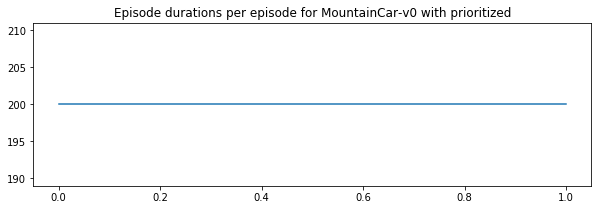


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.03it/s]

Total duration time:  1.9445228576660156


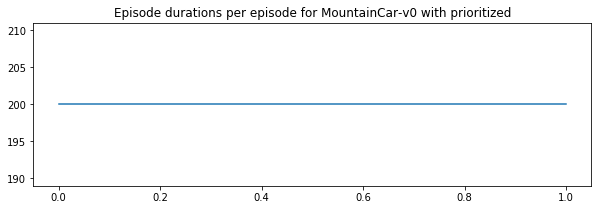


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.00s/it]

Total duration time:  2.0076327323913574


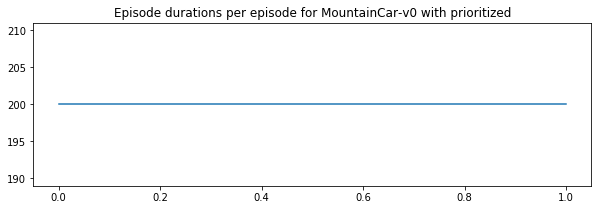


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.01it/s]

Total duration time:  1.9772241115570068


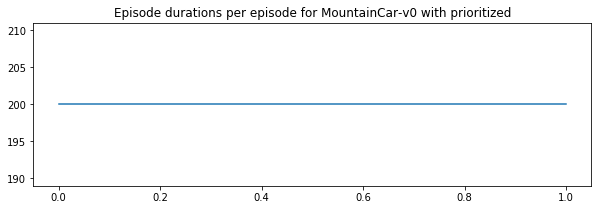


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.02it/s]

Total duration time:  1.968259572982788


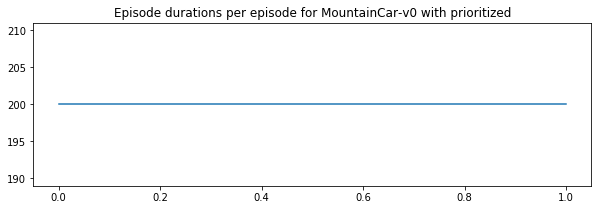


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.01s/it]

Total duration time:  2.0340702533721924


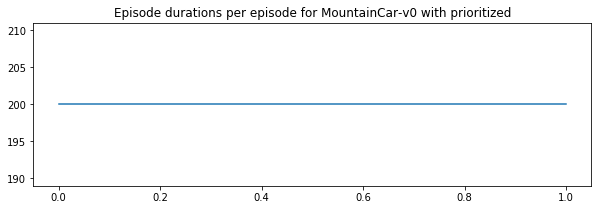


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.01it/s]

Total duration time:  1.9788572788238525


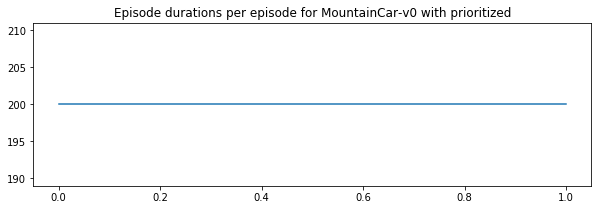


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.02it/s]

Total duration time:  1.9652538299560547


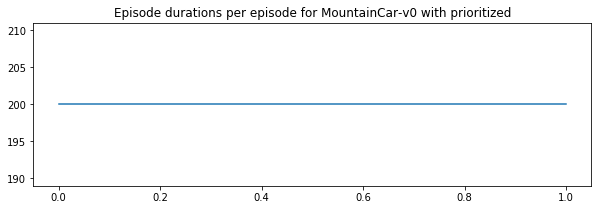


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/it]

Total duration time:  2.1418039798736572


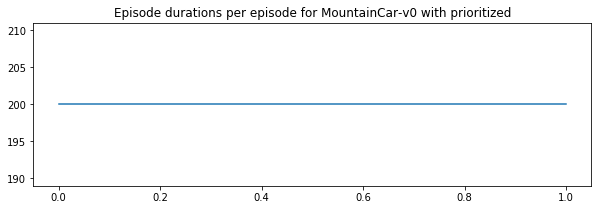


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.02s/it]

Total duration time:  2.0495493412017822


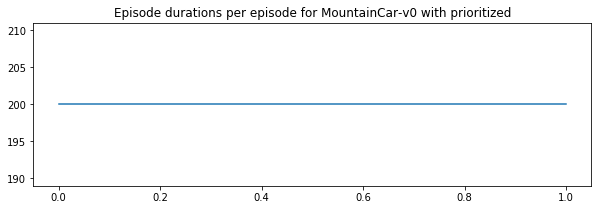


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/it]

Total duration time:  2.194136619567871


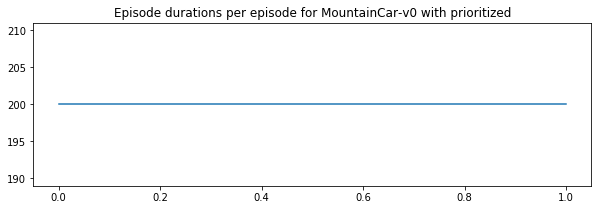


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/it]

Total duration time:  2.2295479774475098


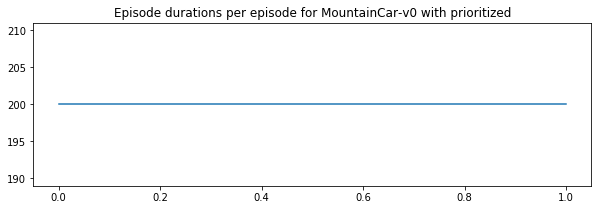


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]

Total duration time:  2.0650033950805664


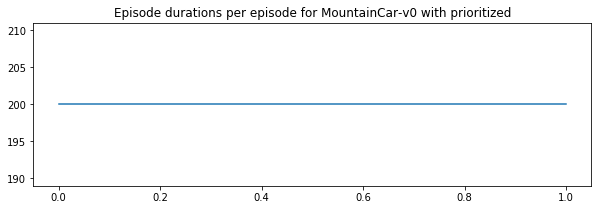


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.06s/it]

Total duration time:  2.1328213214874268


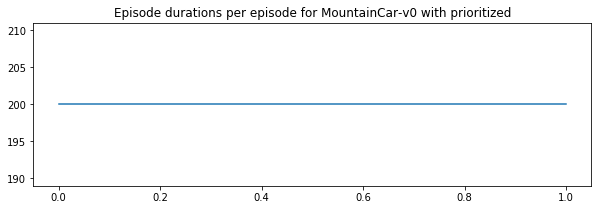


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/it]

Total duration time:  2.142289876937866


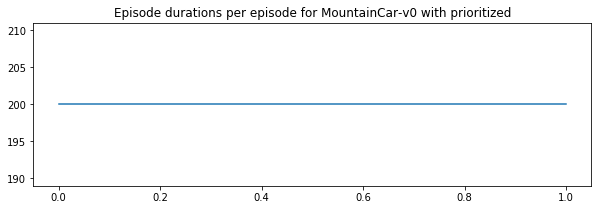


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.02s/it]

Total duration time:  2.0530202388763428


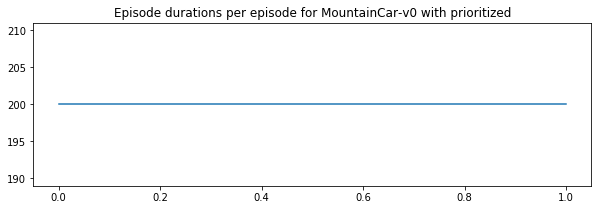


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.00s/it]

Total duration time:  2.0096356868743896


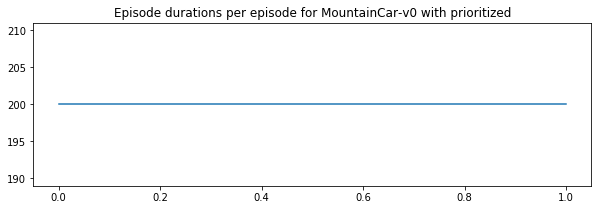


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.06s/it]

Total duration time:  2.123324394226074


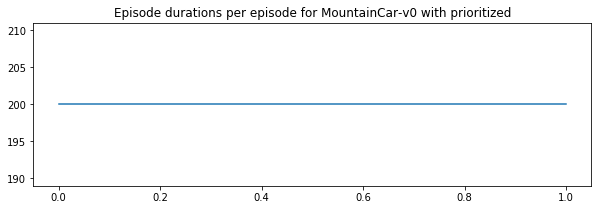


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.02s/it]

Total duration time:  2.0425243377685547


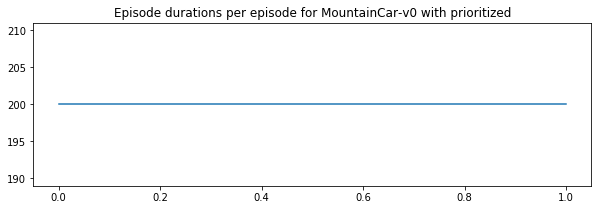


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.06s/it]

Total duration time:  2.1283111572265625


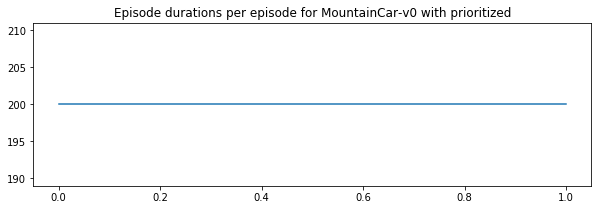


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.00it/s]

Total duration time:  2.0026204586029053


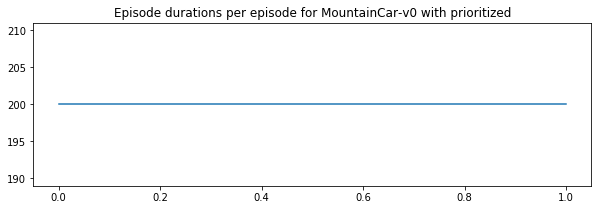


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]

Total duration time:  2.0644822120666504


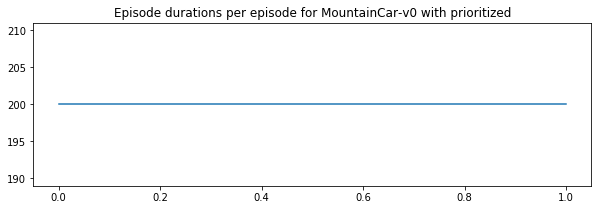


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.01it/s]

Total duration time:  1.9936714172363281


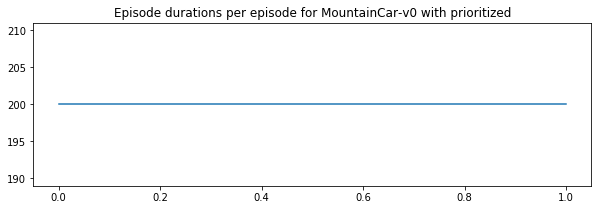


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.00s/it]

Total duration time:  2.0066380500793457


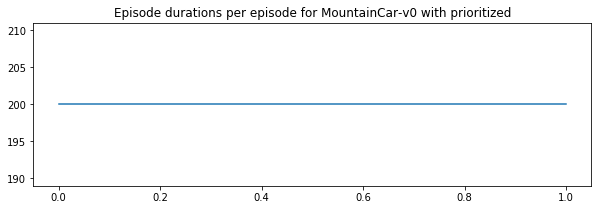


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.06s/it]

Total duration time:  2.1338186264038086


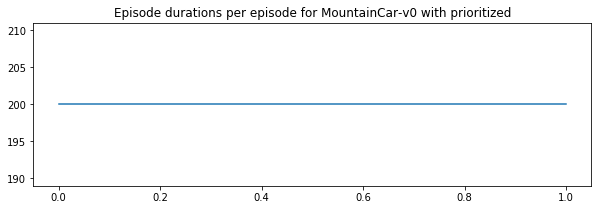


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.02s/it]

Total duration time:  2.0545079708099365


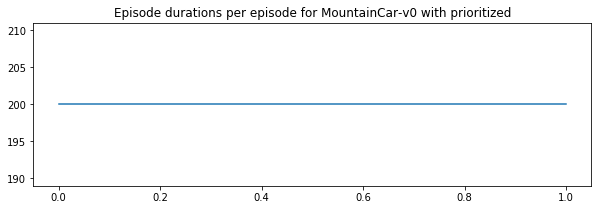


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/it]

Total duration time:  2.212087392807007


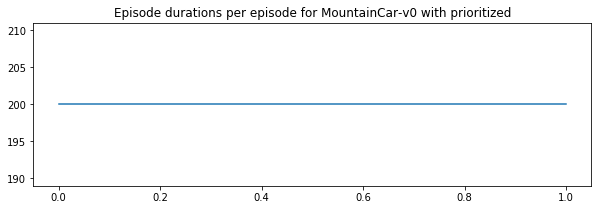


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.02s/it]

Total duration time:  2.0410563945770264


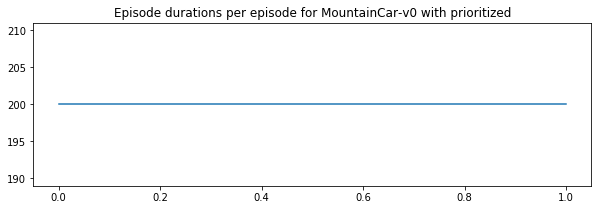


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.06s/it]

Total duration time:  2.120849370956421


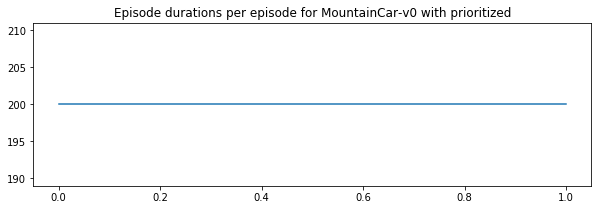


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/it]

Total duration time:  2.2399866580963135


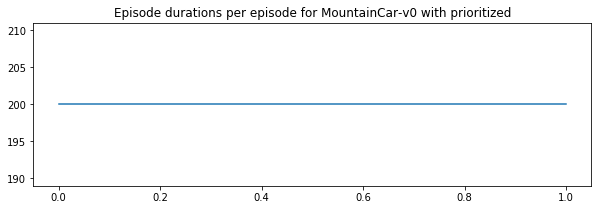


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.02s/it]

Total duration time:  2.046503782272339


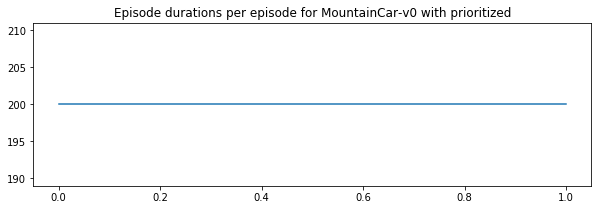


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.02it/s]

Total duration time:  1.9667425155639648


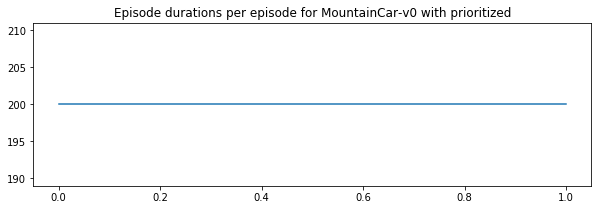


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.01it/s]

Total duration time:  1.9797089099884033


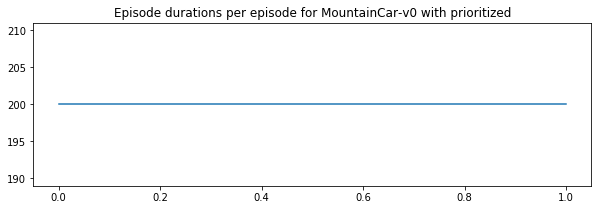


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.04it/s]

Total duration time:  1.930840253829956


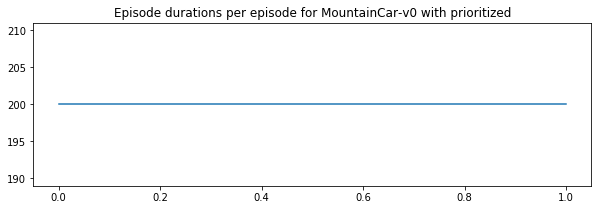


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.05it/s]

Total duration time:  1.9029061794281006


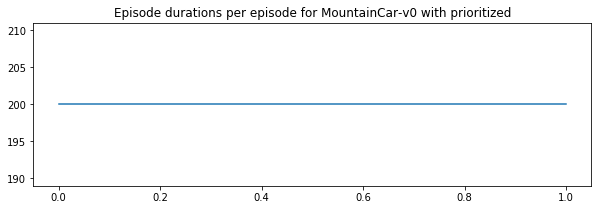


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.01it/s]

Total duration time:  1.9926731586456299


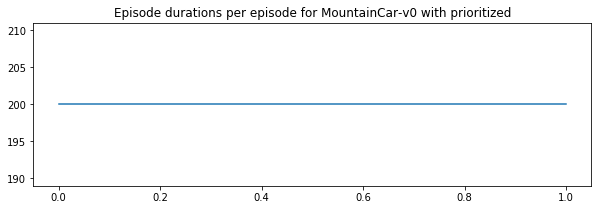


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.05it/s]

Total duration time:  1.904904842376709


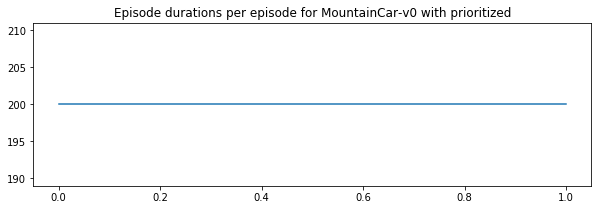


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.01it/s]

Total duration time:  1.9856650829315186


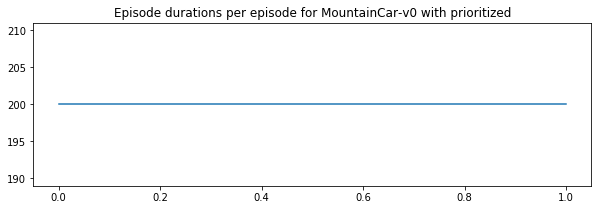


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]

Total duration time:  2.058497905731201


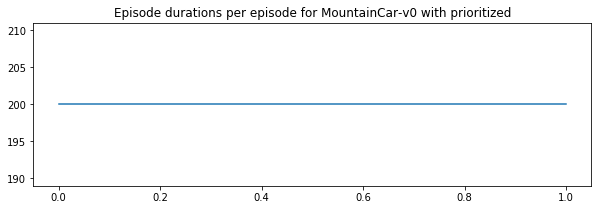


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.02it/s]

Total duration time:  1.959761381149292


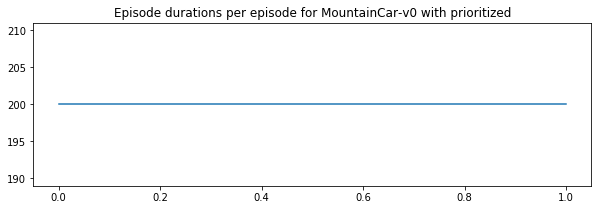


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.07it/s]

Total duration time:  1.8700499534606934


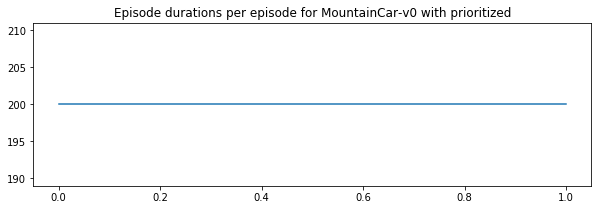


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.07it/s]

Total duration time:  1.880500316619873


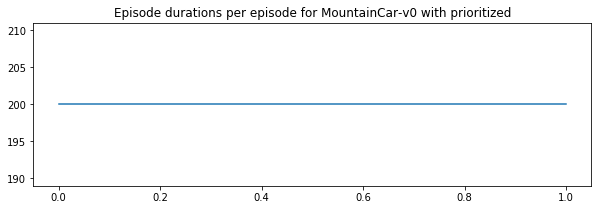


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.06it/s]

Total duration time:  1.886472225189209


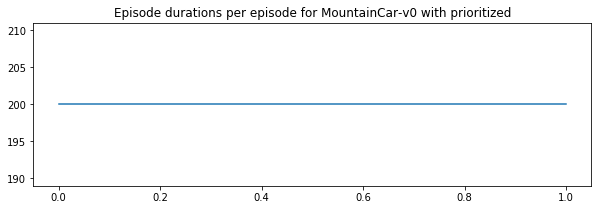


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.05it/s]

Total duration time:  1.9009315967559814


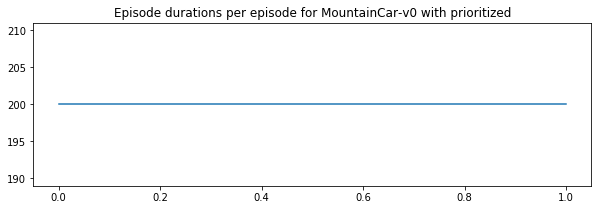


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.05it/s]

Total duration time:  1.9148828983306885


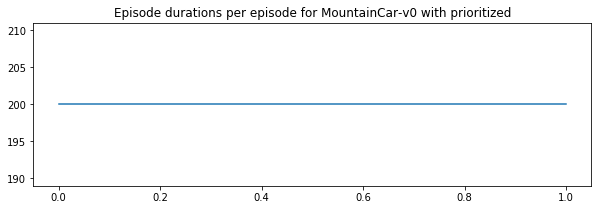


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.06it/s]

Total duration time:  1.887009859085083


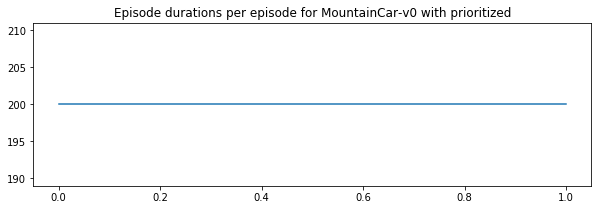


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.07it/s]

Total duration time:  1.8729655742645264


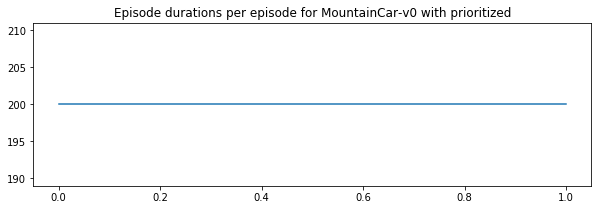


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.04it/s]

Total duration time:  1.9213757514953613


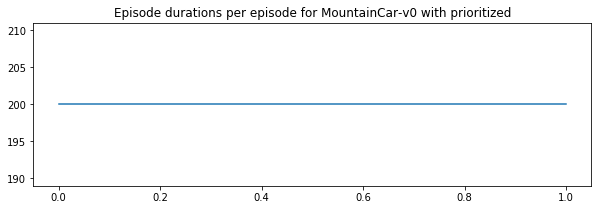


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.08it/s]

Total duration time:  1.8495755195617676


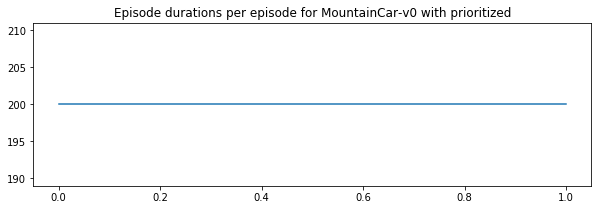


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.04it/s]

Total duration time:  1.925851821899414


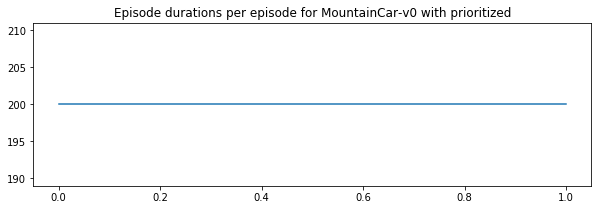


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.02it/s]

Total duration time:  1.960773229598999


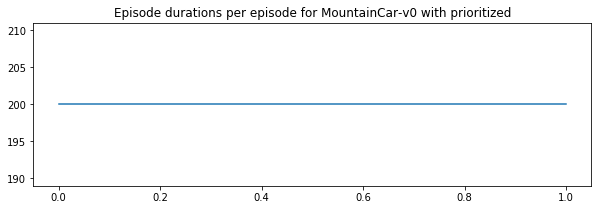


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.08it/s]

Total duration time:  1.8495705127716064


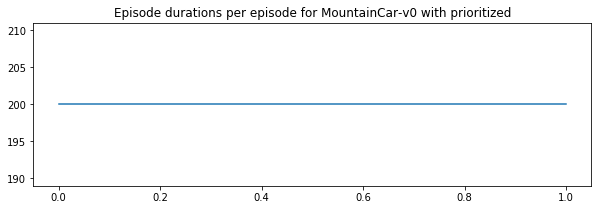


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.05it/s]

Total duration time:  1.91219162940979


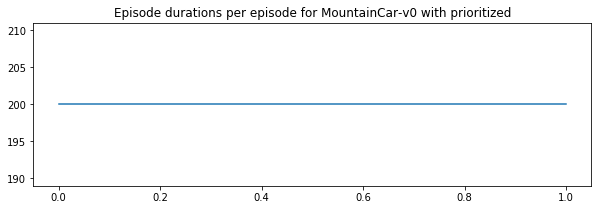


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.05it/s]

Total duration time:  1.9158787727355957


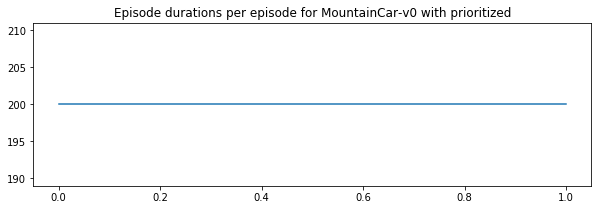


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.05it/s]

Total duration time:  1.9069030284881592


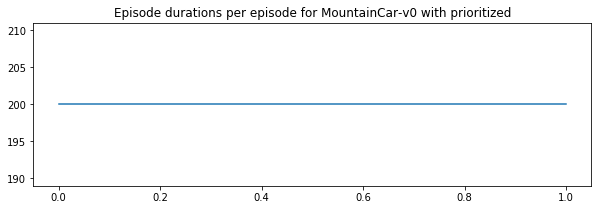


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.07it/s]

Total duration time:  1.86802077293396


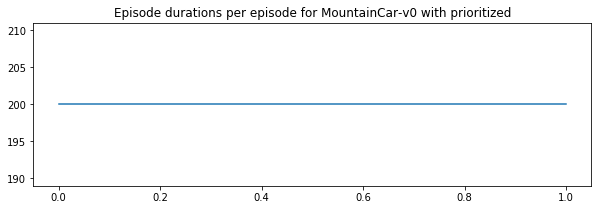


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.04it/s]

Total duration time:  1.926330327987671


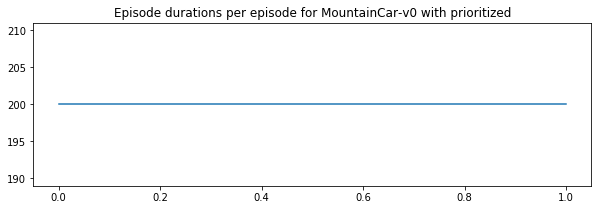


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.07it/s]

Total duration time:  1.870974063873291


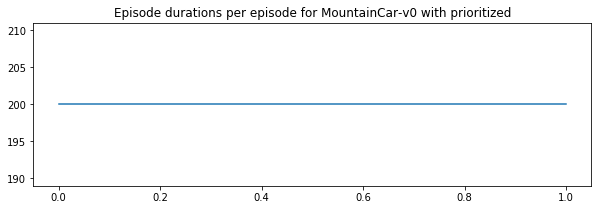


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.06it/s]

Total duration time:  1.8964803218841553


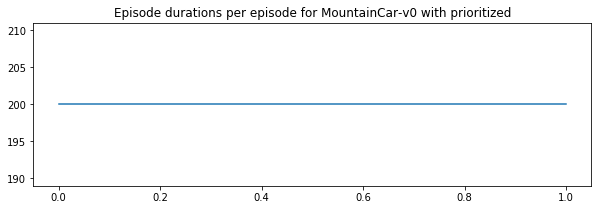


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.05it/s]

Total duration time:  1.9044878482818604


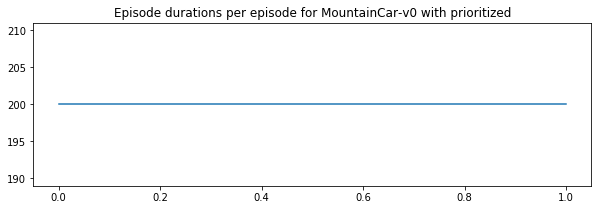


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.06it/s]

Total duration time:  1.8919434547424316


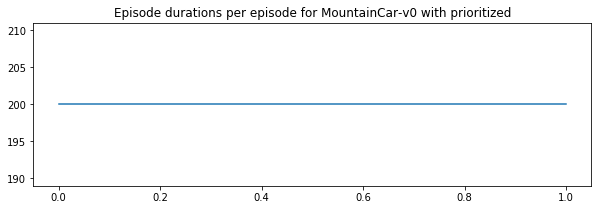


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.05s/it]

Total duration time:  2.099893093109131


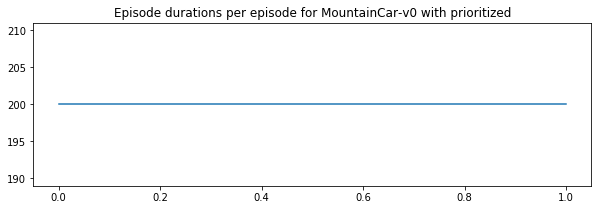


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.02s/it]

Total duration time:  2.0425126552581787


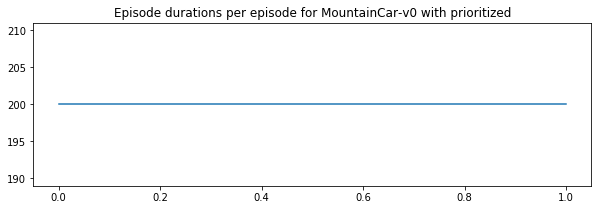


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.02it/s]

Total duration time:  1.962275505065918


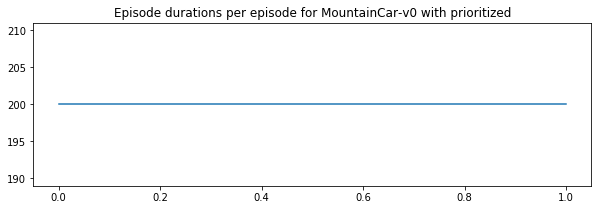


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.03it/s]

Total duration time:  1.9383389949798584


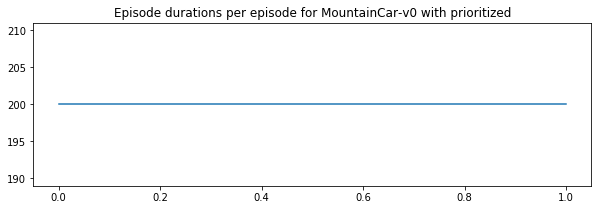


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.00it/s]

Total duration time:  1.9966967105865479


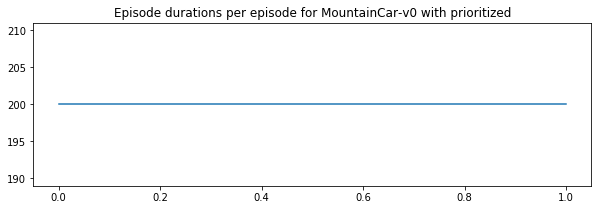


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.02it/s]

Total duration time:  1.9660377502441406


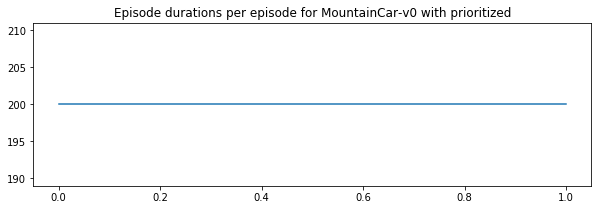


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.03it/s]

Total duration time:  1.9517817497253418


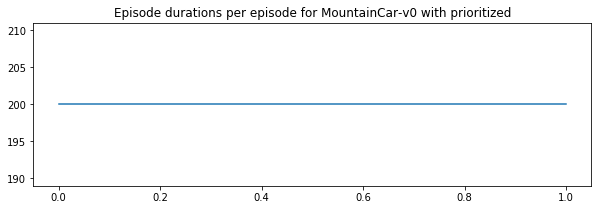


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.03it/s]

Total duration time:  1.94431734085083


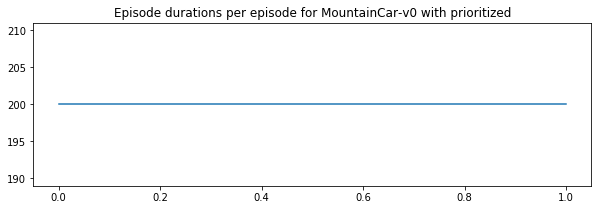


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.05it/s]

Total duration time:  1.9072773456573486


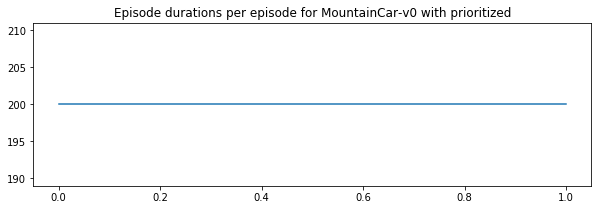


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.01it/s]

Total duration time:  1.991682767868042


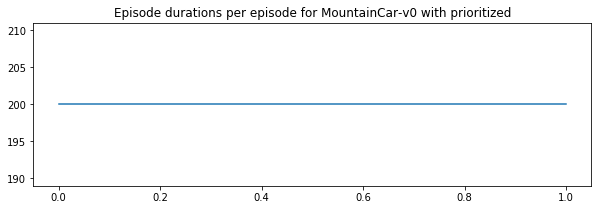


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]

Total duration time:  2.059999704360962


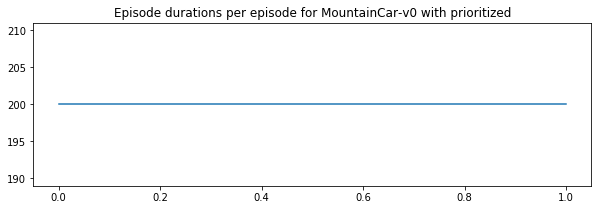


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.02it/s]

Total duration time:  1.9687390327453613


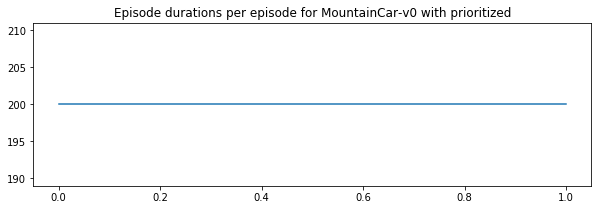


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.00s/it]

Total duration time:  2.015610694885254


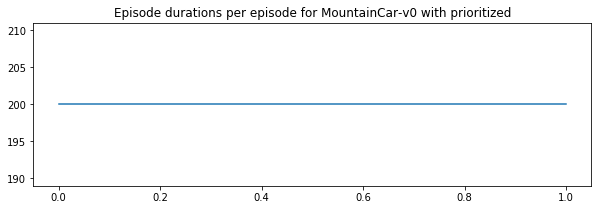


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.02it/s]

Total duration time:  1.9732224941253662


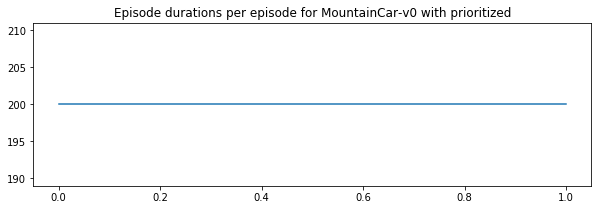


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.04it/s]

Total duration time:  1.92857027053833


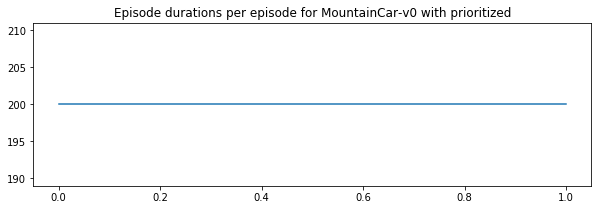


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.02it/s]

Total duration time:  1.963029384613037


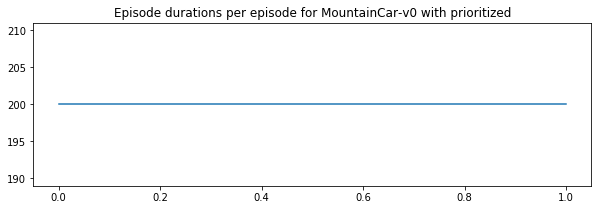


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.04it/s]

Total duration time:  1.9353437423706055


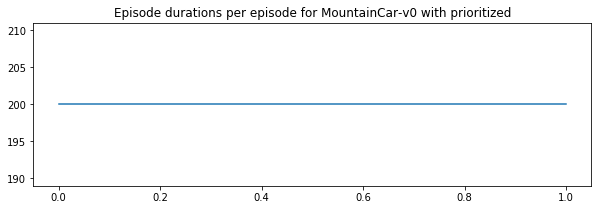


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.05s/it]

Total duration time:  2.1093618869781494


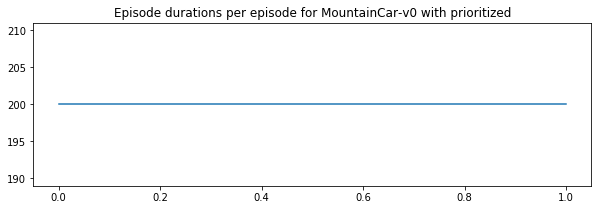


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/it]

Total duration time:  2.2739336490631104


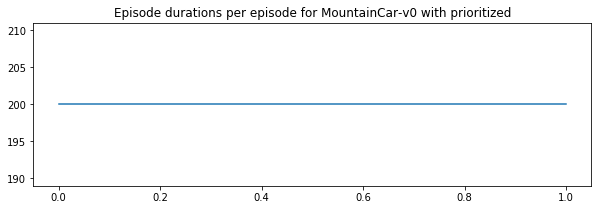


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.16s/it]

Total duration time:  2.3337624073028564


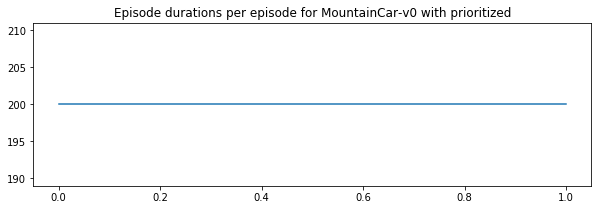


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]

Total duration time:  2.0724611282348633


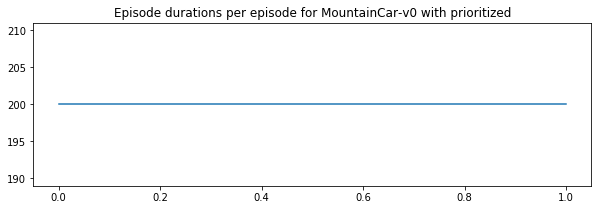


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.02s/it]

Total duration time:  2.050028085708618


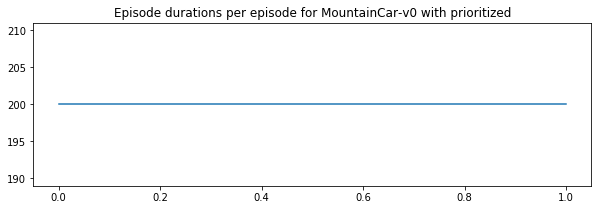


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/it]

Total duration time:  2.141277313232422


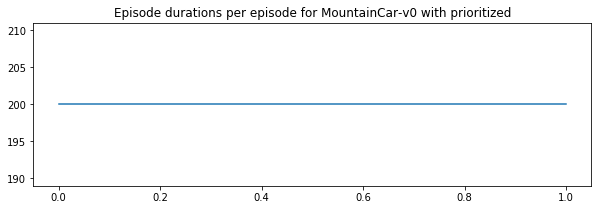


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/it]

Total duration time:  2.137286901473999


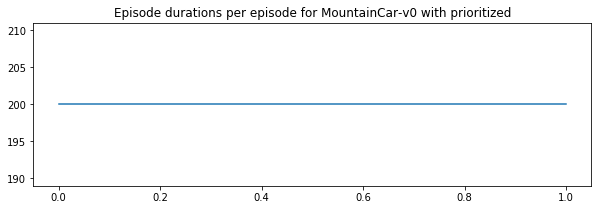


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]

Total duration time:  2.064483404159546


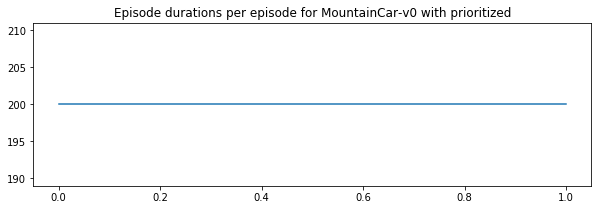


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.06s/it]

Total duration time:  2.118854284286499


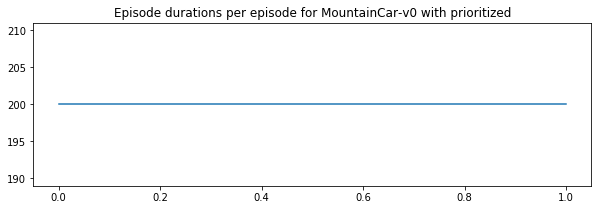


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.04s/it]

Total duration time:  2.0809366703033447


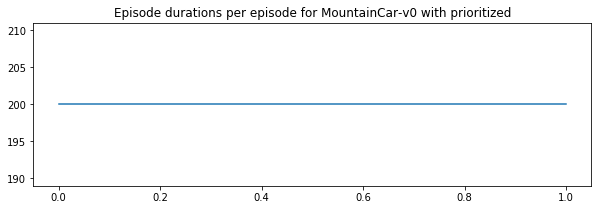


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.06s/it]

Total duration time:  2.124321699142456


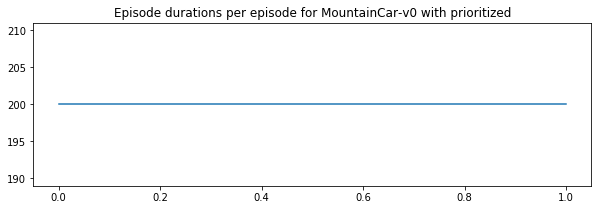


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/it]

Total duration time:  2.1407861709594727


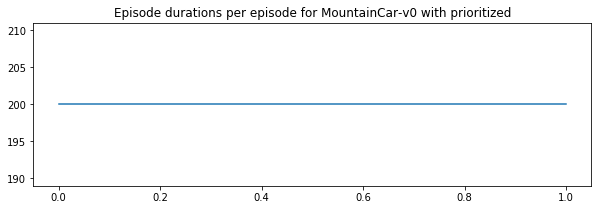


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.02s/it]

Total duration time:  2.03855299949646


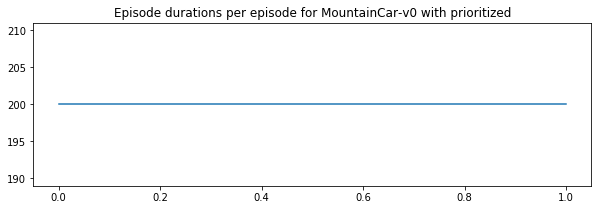


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.01it/s]

Total duration time:  1.9806883335113525


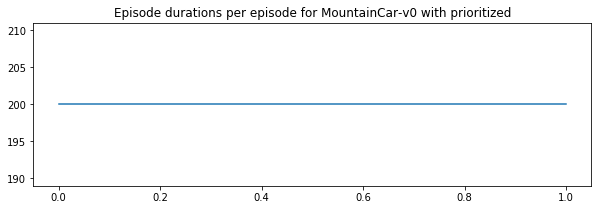


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/it]

Total duration time:  2.152552366256714


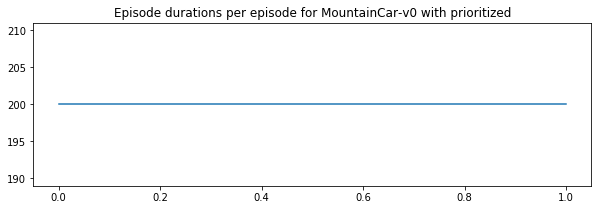


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.05s/it]

Total duration time:  2.1078941822052


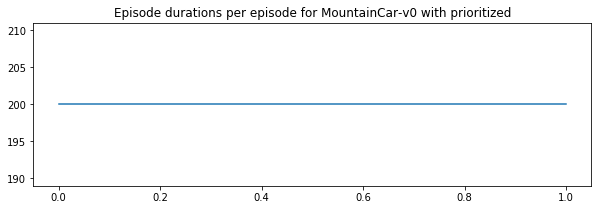


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/it]

Total duration time:  2.1991190910339355


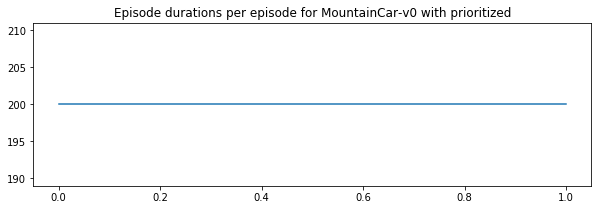


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/it]

Total duration time:  2.206103563308716


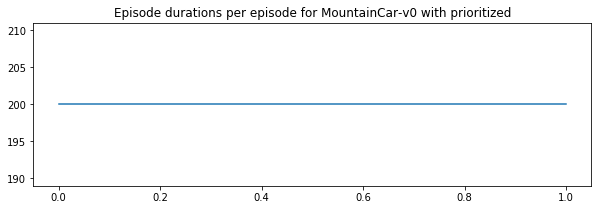


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/it]

Total duration time:  2.201622724533081


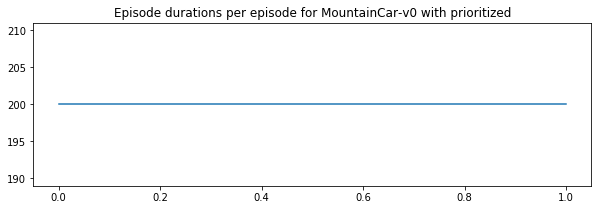


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/it]

Total duration time:  2.195146083831787


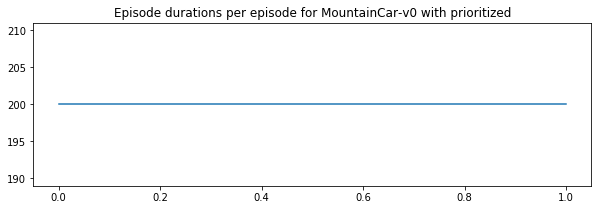


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/it]

Total duration time:  2.1412746906280518


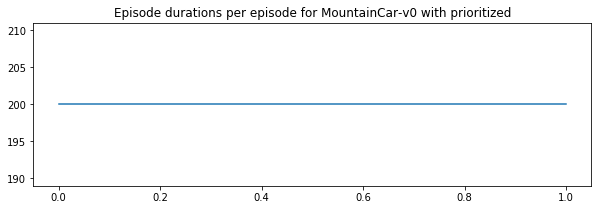


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/it]

Total duration time:  2.154242753982544


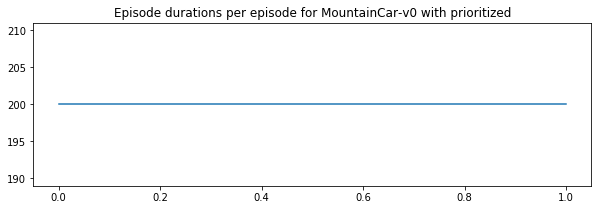


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/it]

Total duration time:  2.1397862434387207


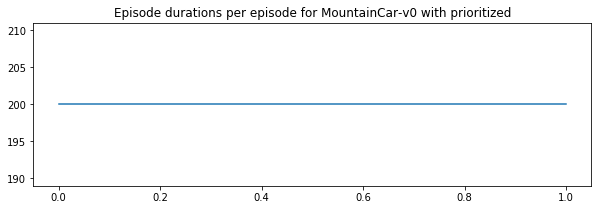


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/it]

Total duration time:  2.1522586345672607


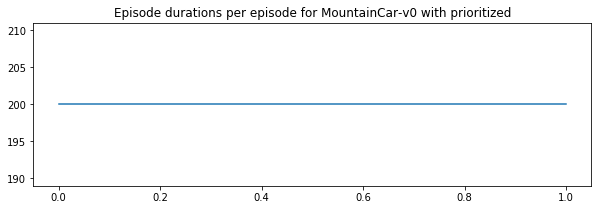


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.02s/it]

Total duration time:  2.0535008907318115


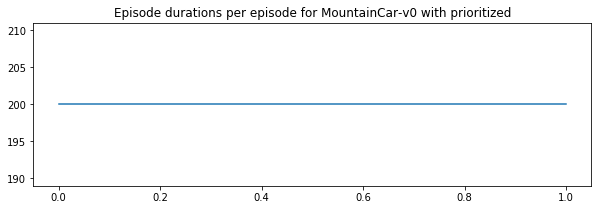


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/it]

Total duration time:  2.196636199951172


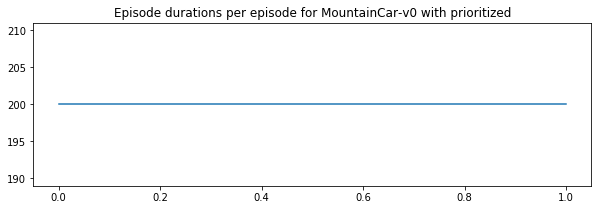


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/it]

Total duration time:  2.1617414951324463


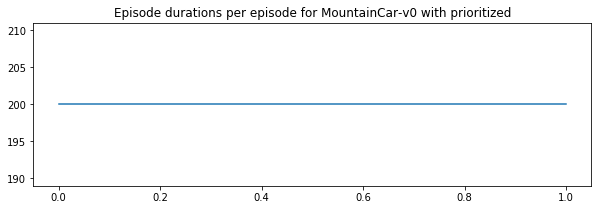


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/it]

Total duration time:  2.243004322052002


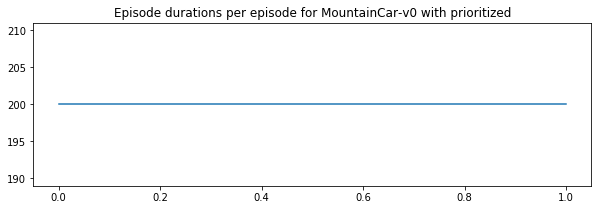


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/it]

Total duration time:  2.1602392196655273


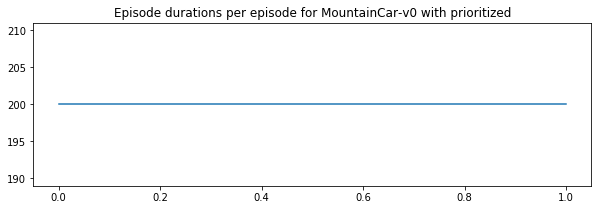


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.06s/it]

Total duration time:  2.1143486499786377


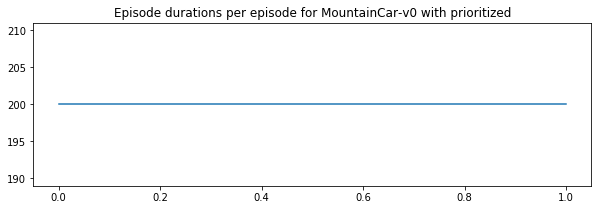


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/it]

Total duration time:  2.3277785778045654


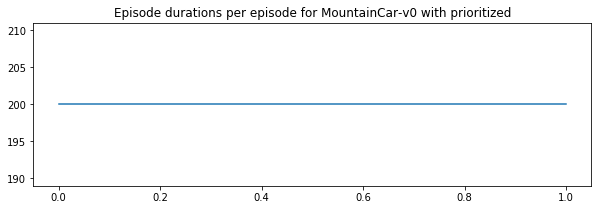


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.06s/it]

Total duration time:  2.1278343200683594


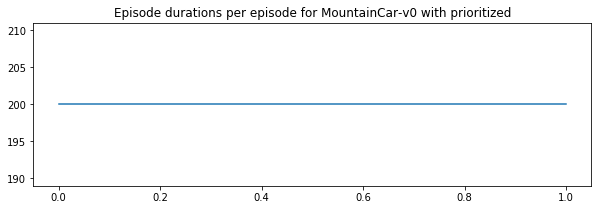


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.03it/s]

Total duration time:  1.9467685222625732


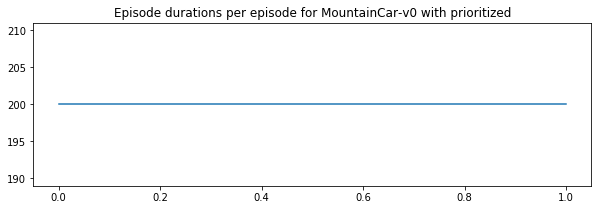


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.02it/s]

Total duration time:  1.9577813148498535


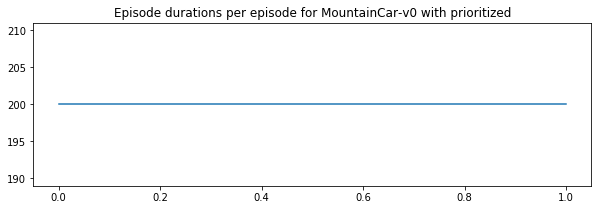


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.02s/it]

Total duration time:  2.0370633602142334


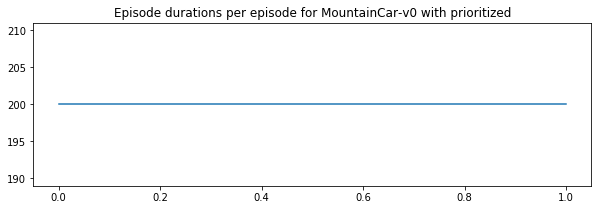


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.02s/it]

Total duration time:  2.0490431785583496


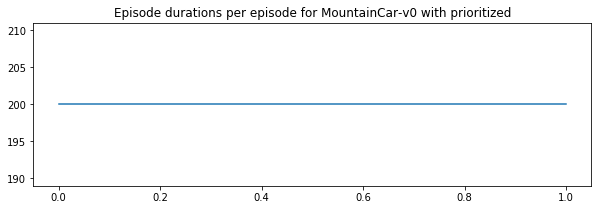


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.00s/it]

Total duration time:  2.009138345718384


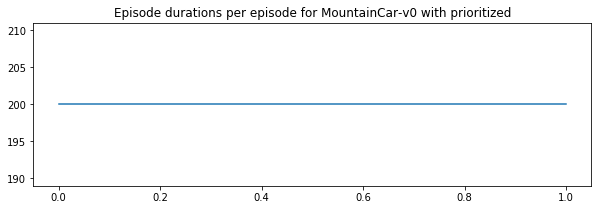


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.01s/it]

Total duration time:  2.031907796859741


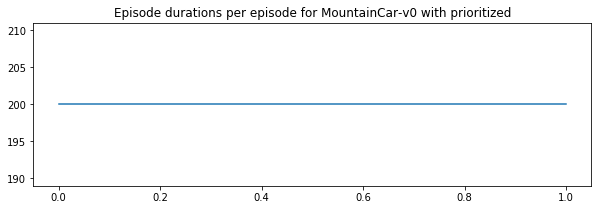


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.04s/it]

Total duration time:  2.0784430503845215


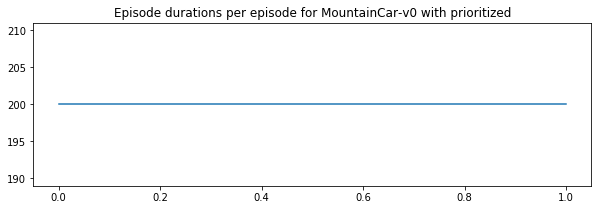


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]

Total duration time:  2.0719704627990723


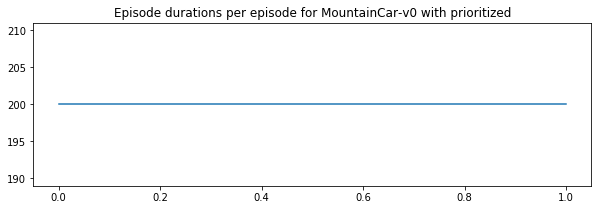


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.02it/s]

Total duration time:  1.9662306308746338


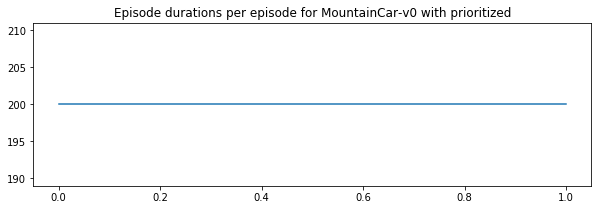


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.02it/s]

Total duration time:  1.973231554031372


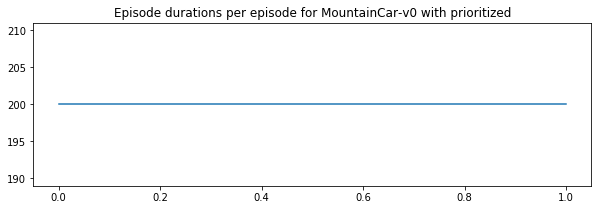


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]

Total duration time:  2.0679969787597656


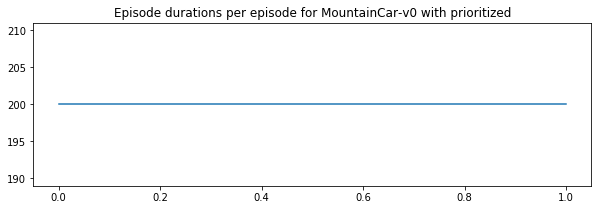


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]

Total duration time:  2.0739643573760986


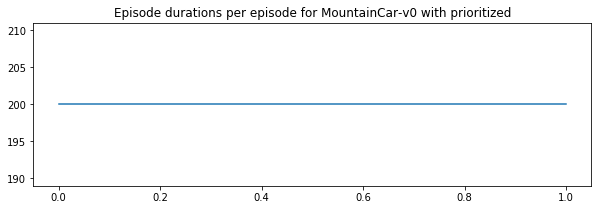


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/it]

Total duration time:  2.1432714462280273


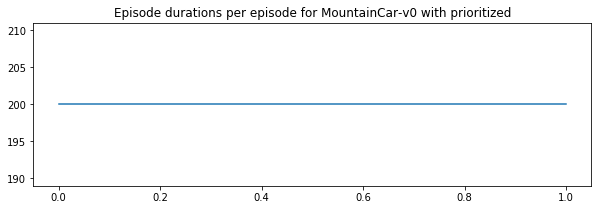


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.04s/it]

Total duration time:  2.0829482078552246


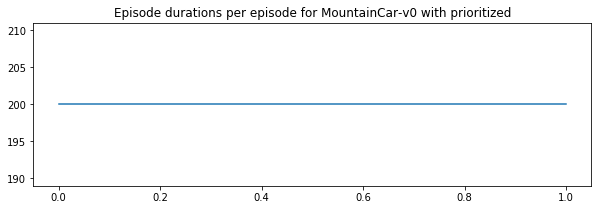


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.00s/it]

Total duration time:  2.0086309909820557


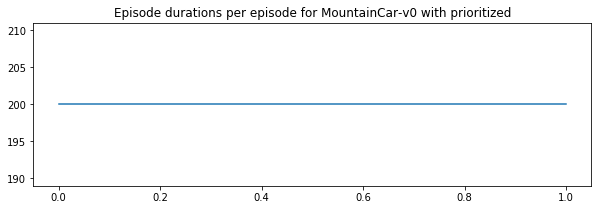


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]

Total duration time:  2.070016622543335


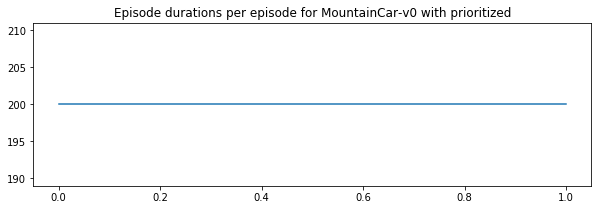


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.01it/s]

Total duration time:  1.98368501663208


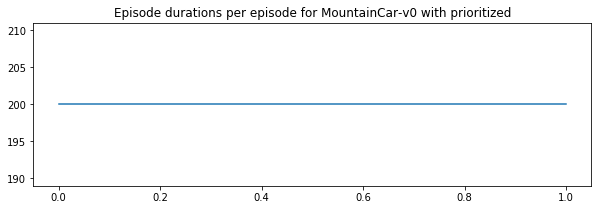


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.00it/s]

Total duration time:  2.0051610469818115


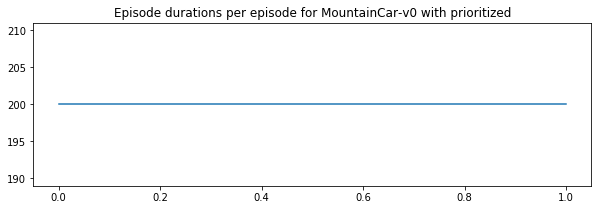


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]

Total duration time:  2.0604922771453857


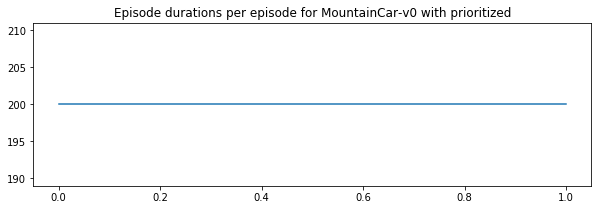


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.00s/it]

Total duration time:  2.0086448192596436


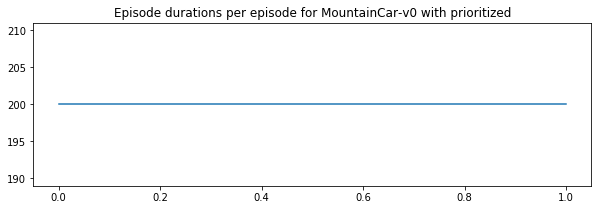


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.01it/s]

Total duration time:  1.9946413040161133


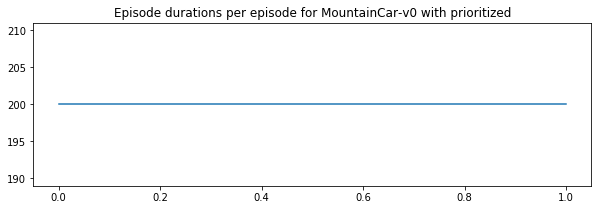


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.01it/s]

Total duration time:  1.9757192134857178


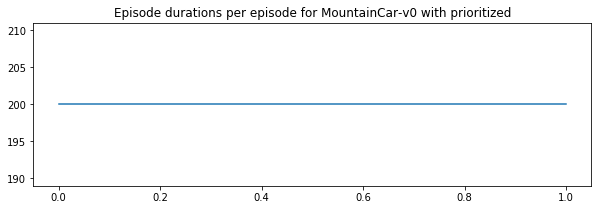


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/it]

Total duration time:  2.172192335128784


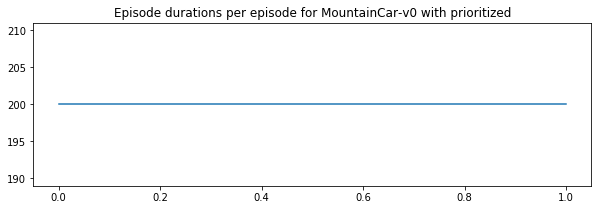


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.05s/it]

Total duration time:  2.1143484115600586


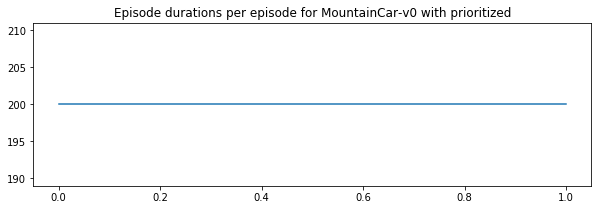


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.01it/s]

Total duration time:  1.9846947193145752


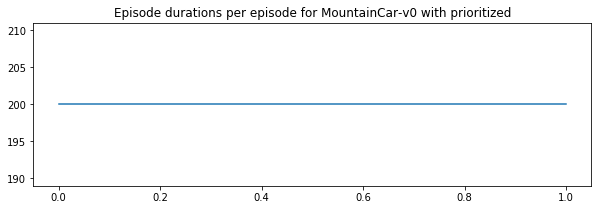


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.00s/it]

Total duration time:  2.0061447620391846


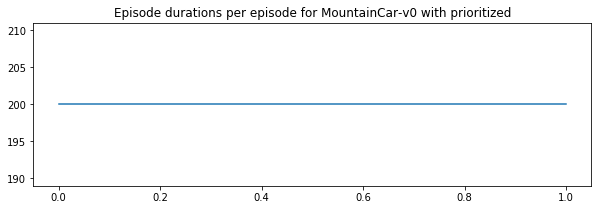


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.01s/it]

Total duration time:  2.0344760417938232


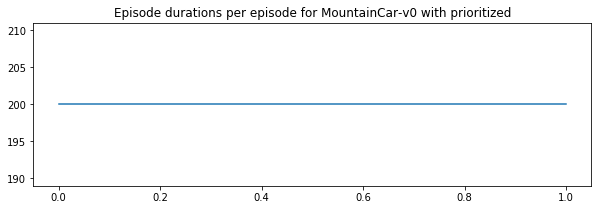


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]

Total duration time:  2.0669803619384766


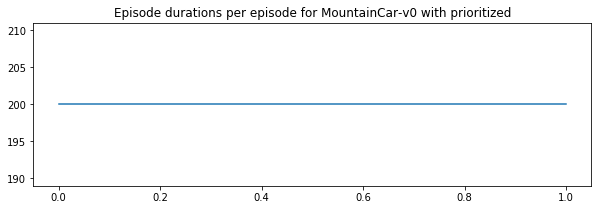


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.05it/s]

Total duration time:  1.910400152206421


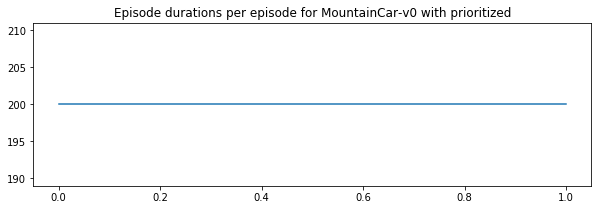


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.00s/it]

Total duration time:  2.0086307525634766


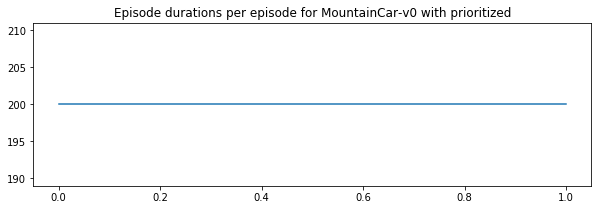


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.02it/s]

Total duration time:  1.9687669277191162


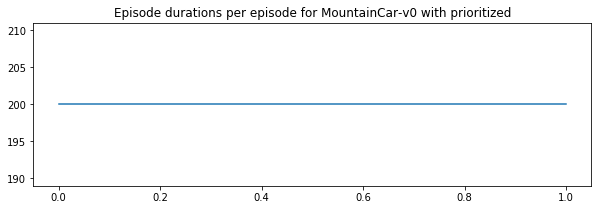


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/it]

Total duration time:  2.145265579223633


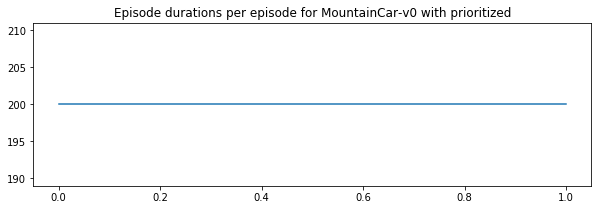


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.03it/s]

Total duration time:  1.9438035488128662


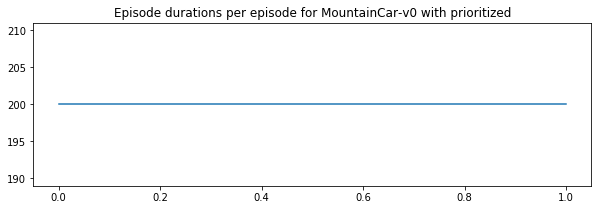


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.01s/it]

Total duration time:  2.028576612472534


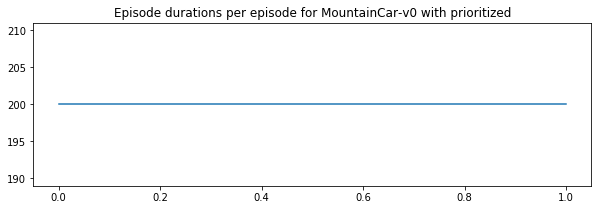


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.02it/s]

Total duration time:  1.9637508392333984


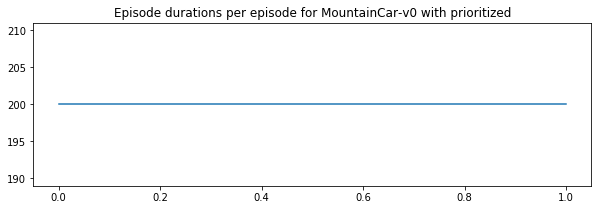


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.06it/s]

Total duration time:  1.8839623928070068


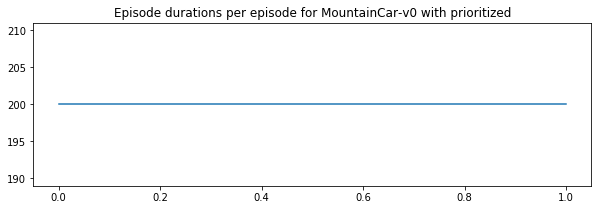


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.02it/s]

Total duration time:  1.9707202911376953


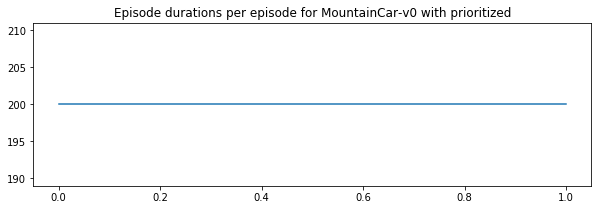


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.01it/s]

Total duration time:  1.9871954917907715


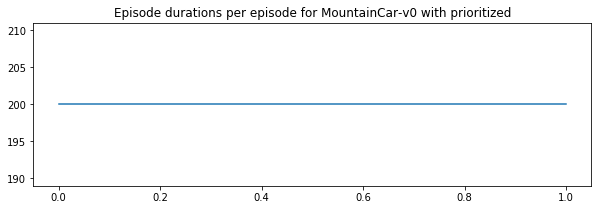


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/it]

Total duration time:  2.2494993209838867


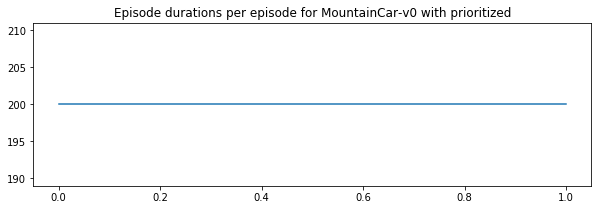


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.02it/s]

Total duration time:  1.968247890472412


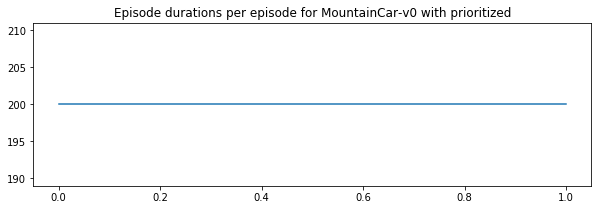


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.01it/s]

Total duration time:  1.9911963939666748


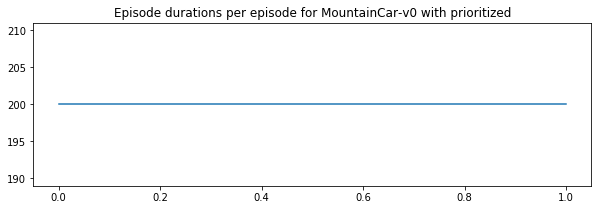


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.05it/s]

Total duration time:  1.9183769226074219


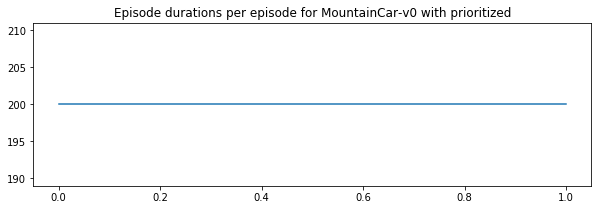


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.01it/s]

Total duration time:  1.9767162799835205


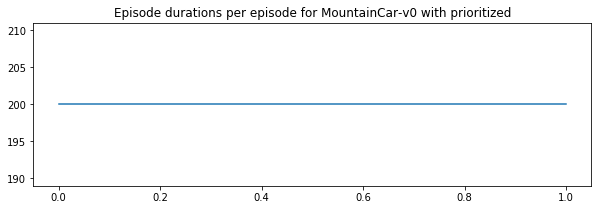


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.04it/s]

Total duration time:  1.9228723049163818


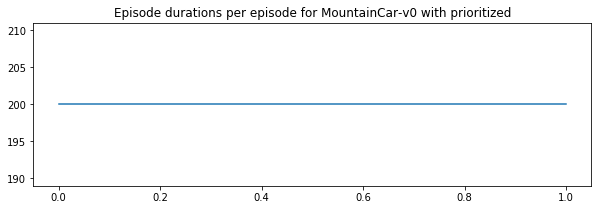


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.04it/s]

Total duration time:  1.9298253059387207


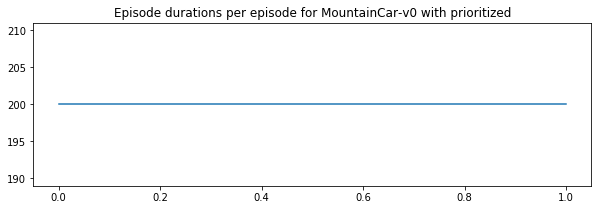


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.01it/s]

Total duration time:  1.9881887435913086


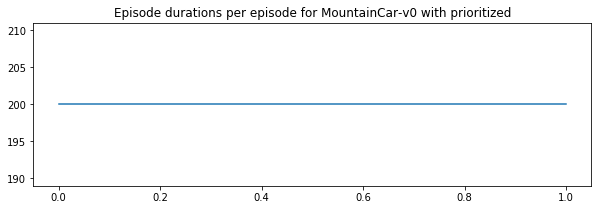


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.03it/s]

Total duration time:  1.9467973709106445


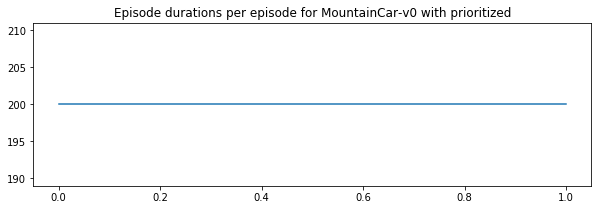


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.01s/it]

Total duration time:  2.0171260833740234


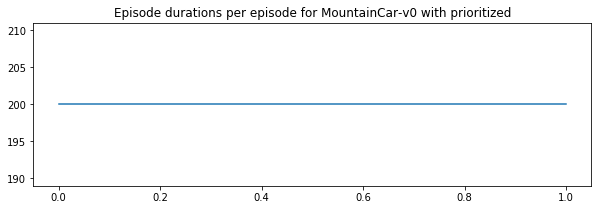


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.03it/s]

Total duration time:  1.947793960571289


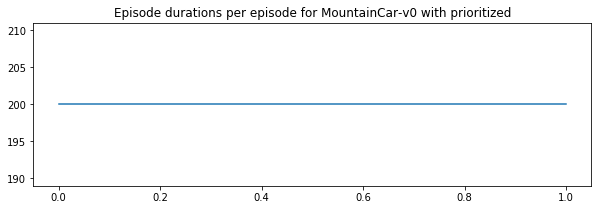


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.04it/s]

Total duration time:  1.9308404922485352


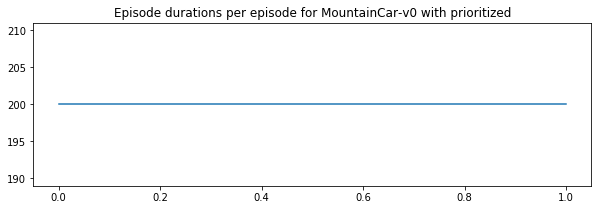


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.05it/s]

Total duration time:  1.9029309749603271


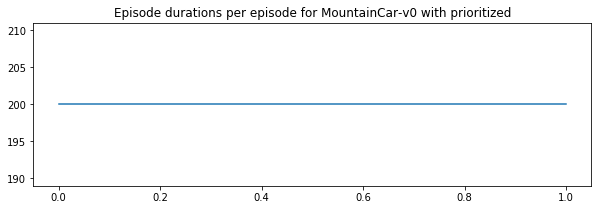


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.01it/s]

Total duration time:  1.98073148727417


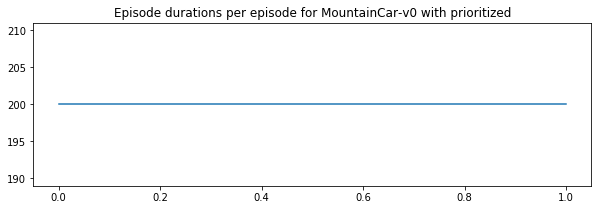


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.04it/s]

Total duration time:  1.9338312149047852


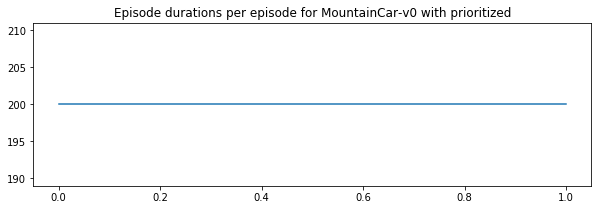


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.03it/s]

Total duration time:  1.94730544090271


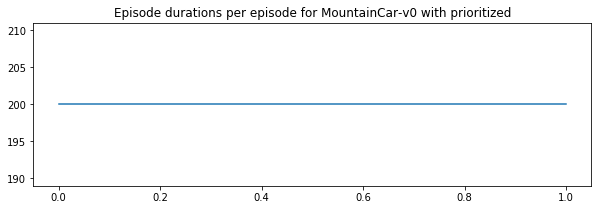


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.04it/s]

Total duration time:  1.9368228912353516


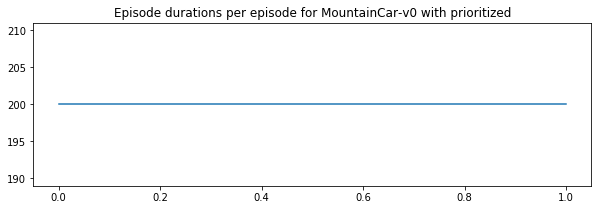


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.05it/s]

Total duration time:  1.913883924484253


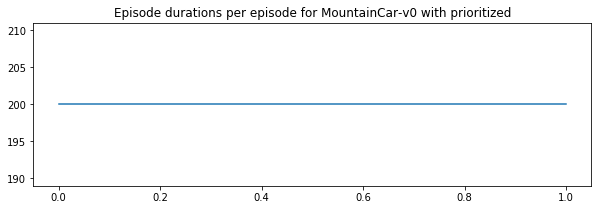


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.01s/it]

Total duration time:  2.0265839099884033


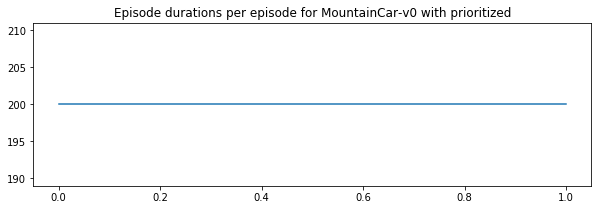


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.04it/s]

Total duration time:  1.9198682308197021


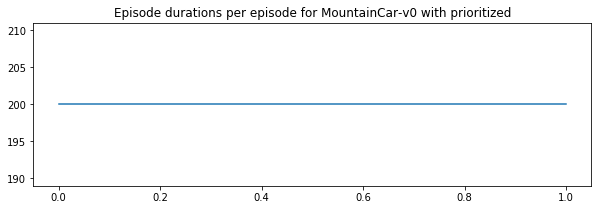


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.02it/s]

Total duration time:  1.9657440185546875


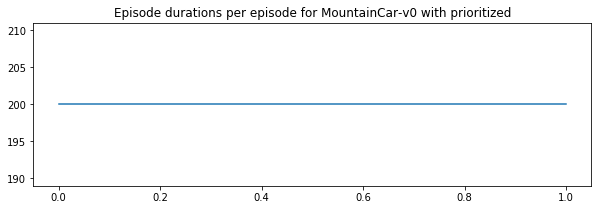


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.03it/s]

Total duration time:  1.9507858753204346


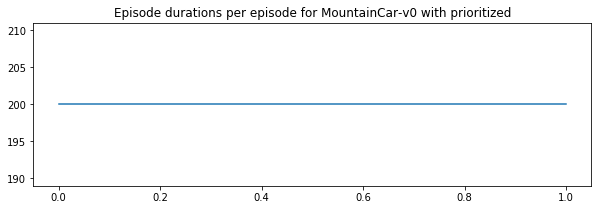


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.01s/it]

Total duration time:  2.0355591773986816


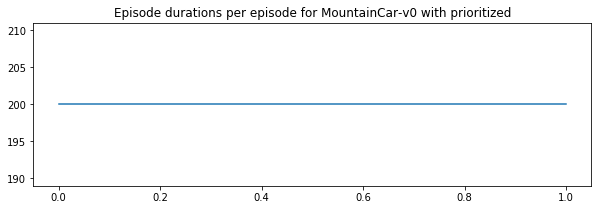


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/it]

Total duration time:  2.221576690673828


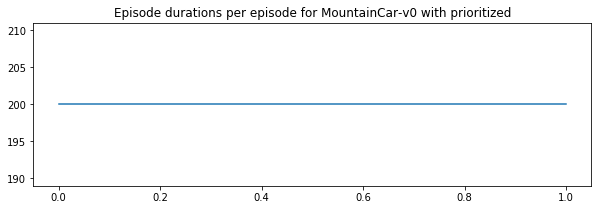


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/it]

Total duration time:  2.192117929458618


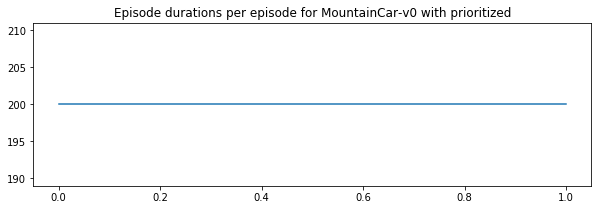


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/it]

Total duration time:  2.2654380798339844


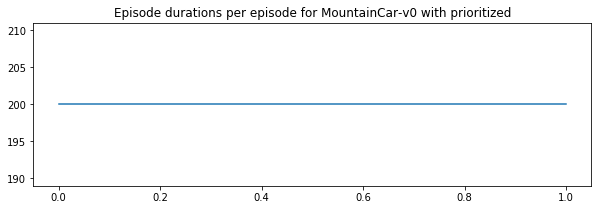


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.05s/it]

Total duration time:  2.101621627807617


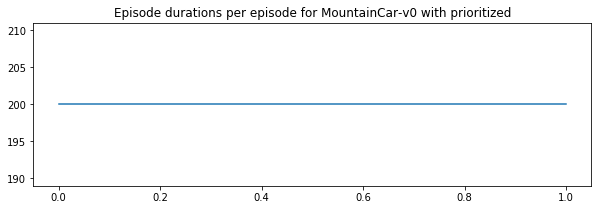


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.02s/it]

Total duration time:  2.036067008972168


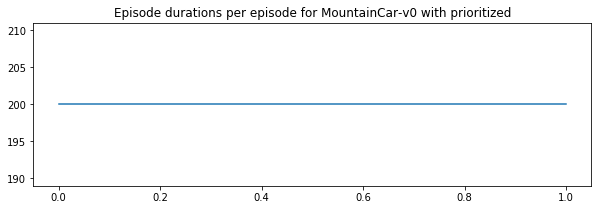


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/it]

Total duration time:  2.1434988975524902


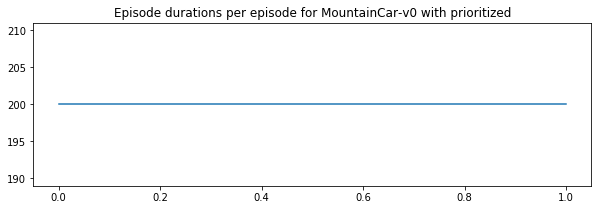


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.04s/it]

Total duration time:  2.078949451446533


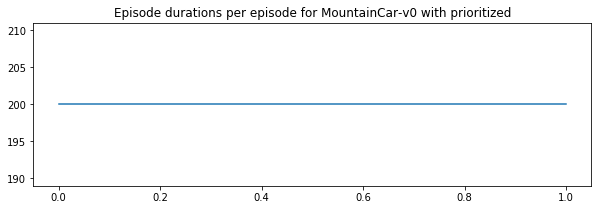


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.00it/s]

Total duration time:  1.9976425170898438


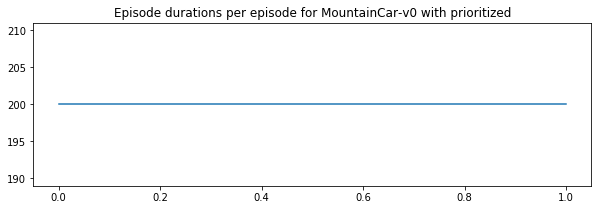


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.00s/it]

Total duration time:  2.012620449066162


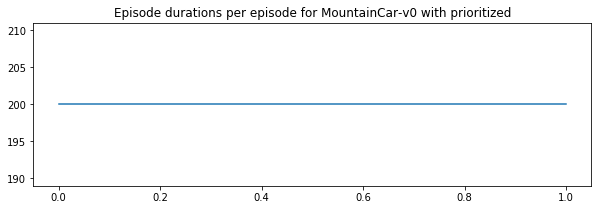


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.02s/it]

Total duration time:  6.10620903968811


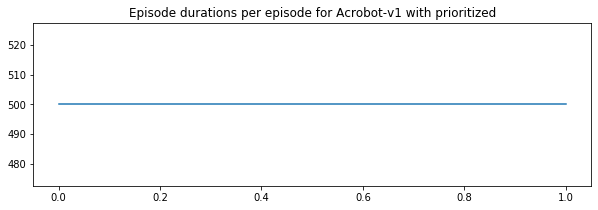


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.04s/it]

Total duration time:  6.080745697021484


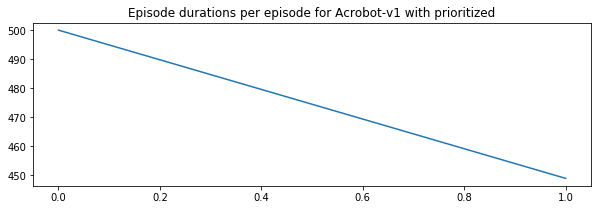


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.38s/it]

Total duration time:  4.382285118103027


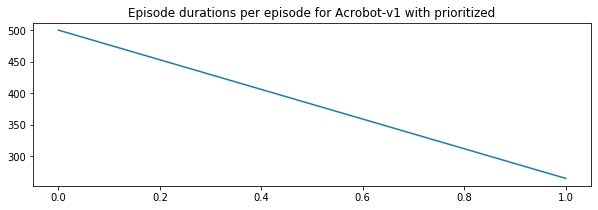


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.03s/it]

Total duration time:  6.146110773086548


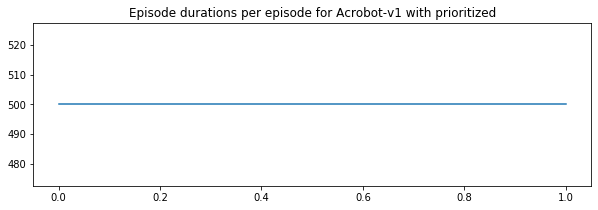


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.80s/it]

Total duration time:  5.734859943389893


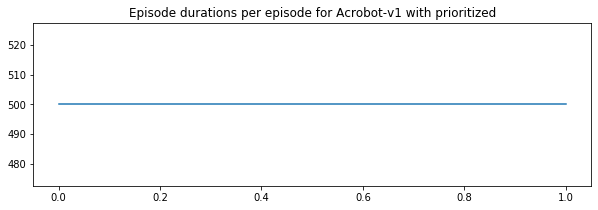


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.61s/it]

Total duration time:  5.181643486022949


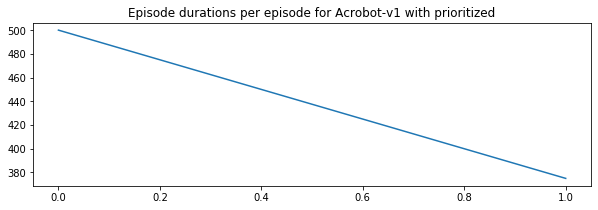


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  2.94s/it]

Total duration time:  6.080471038818359


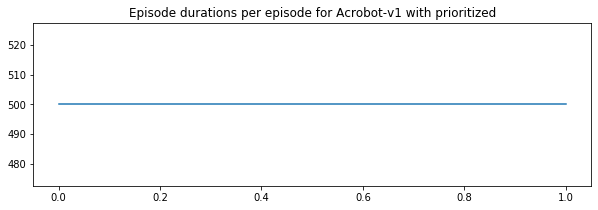


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.03s/it]

Total duration time:  6.176519155502319


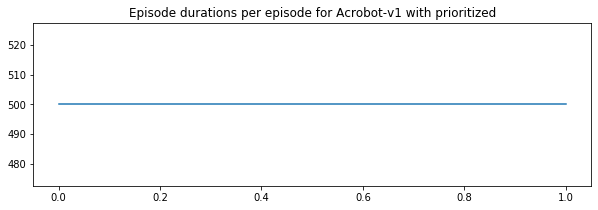


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  2.96s/it]

Total duration time:  6.111692667007446


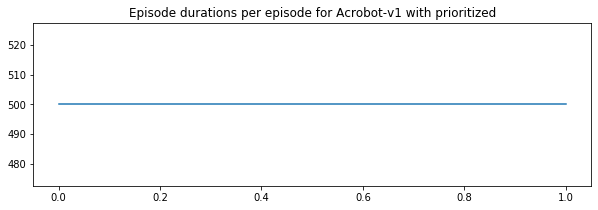


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.74s/it]

Total duration time:  5.610067844390869


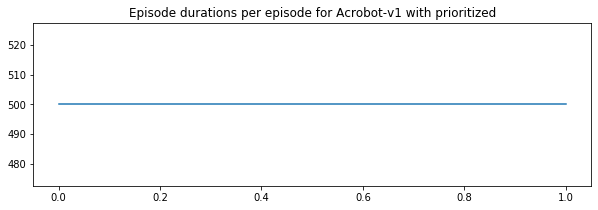


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.54s/it]

Total duration time:  4.934807777404785


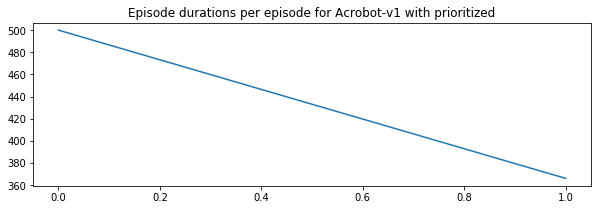


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.76s/it]

Total duration time:  5.646389484405518


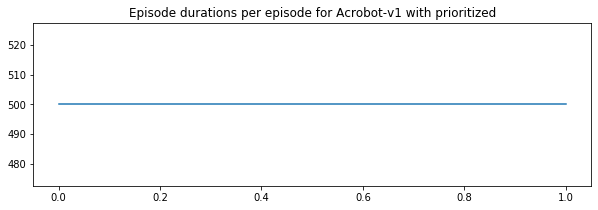


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.51s/it]

Total duration time:  4.839569807052612


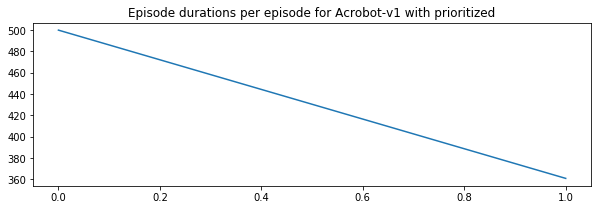


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  2.18s/it]

Total duration time:  3.8796298503875732


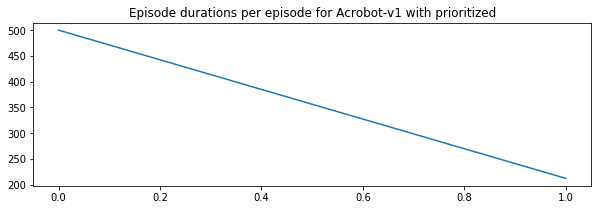


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.80s/it]

Total duration time:  5.779647588729858


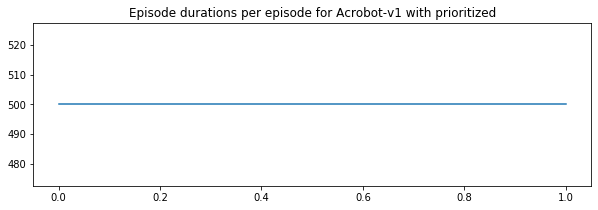


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.70s/it]

Total duration time:  5.545220851898193


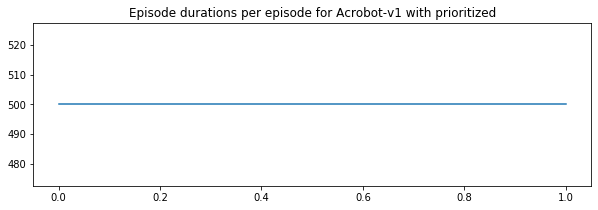


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.77s/it]

Total duration time:  5.714594125747681


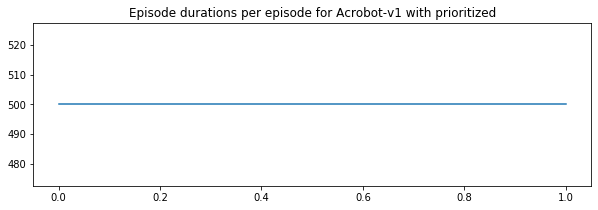


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.93s/it]

Total duration time:  5.953594923019409


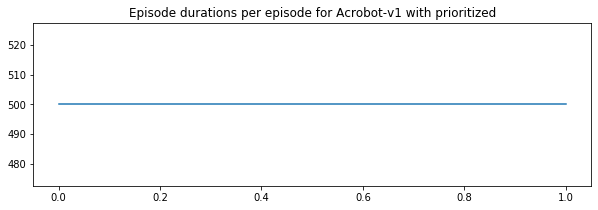


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.52s/it]

Total duration time:  4.883042573928833


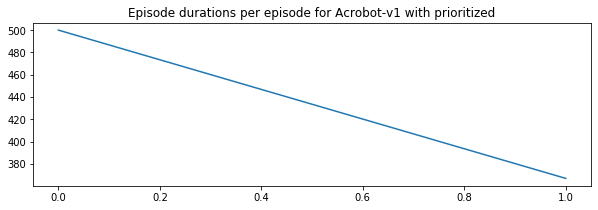


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.47s/it]

Total duration time:  5.444477081298828


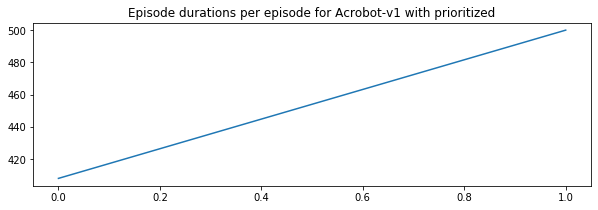


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.04s/it]

Total duration time:  6.232904434204102


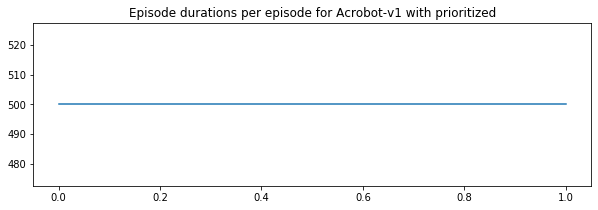


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.04s/it]

Total duration time:  6.206799030303955


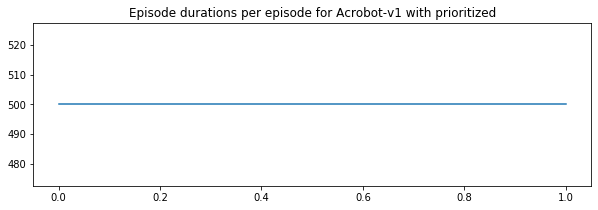


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.74s/it]

Total duration time:  5.241001129150391


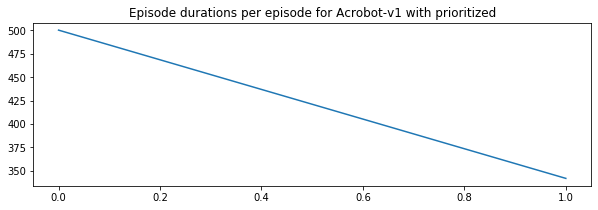


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.02s/it]

Total duration time:  6.233517646789551


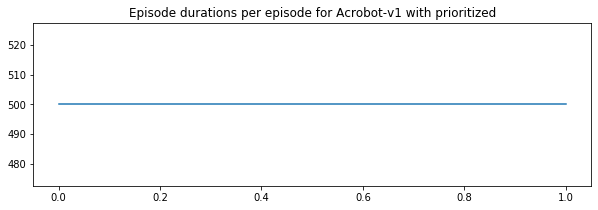


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.04s/it]

Total duration time:  6.146775007247925


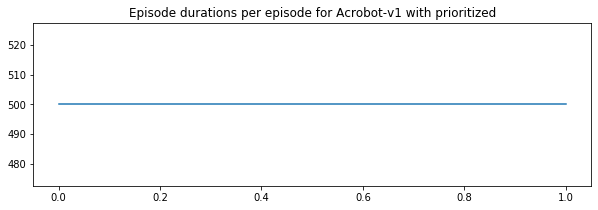


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.30s/it]

Total duration time:  4.044669151306152


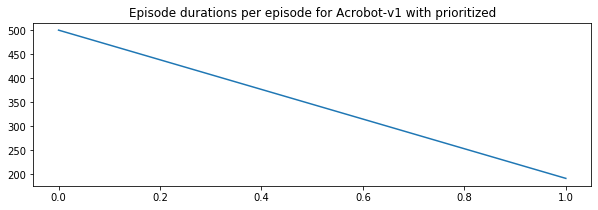


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  2.97s/it]

Total duration time:  6.14856481552124


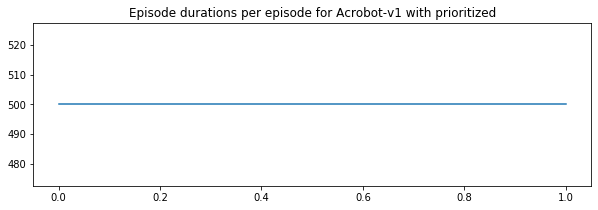


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.92s/it]

Total duration time:  5.984029531478882


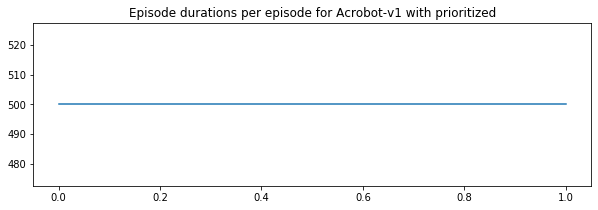


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.62s/it]

Total duration time:  4.885849714279175


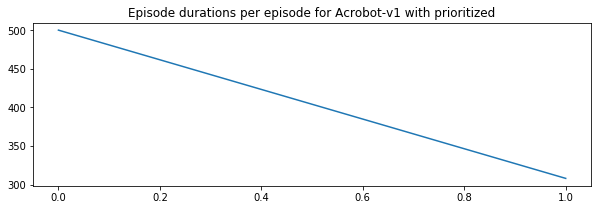


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  2.88s/it]

Total duration time:  6.020440578460693


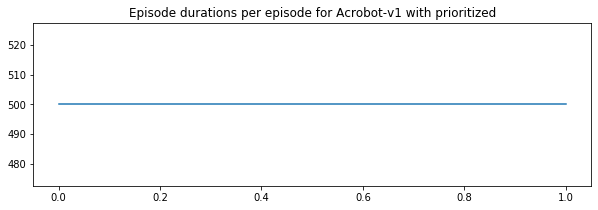


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  2.98s/it]

Total duration time:  6.073328495025635


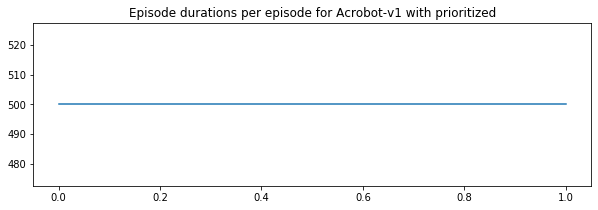


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.03s/it]

Total duration time:  6.337387800216675


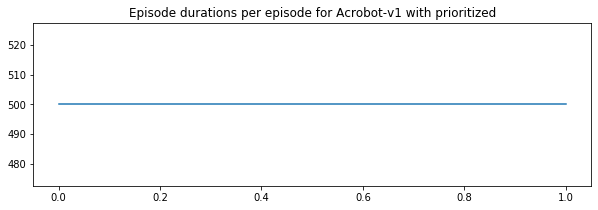


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  2.95s/it]

Total duration time:  6.034390211105347


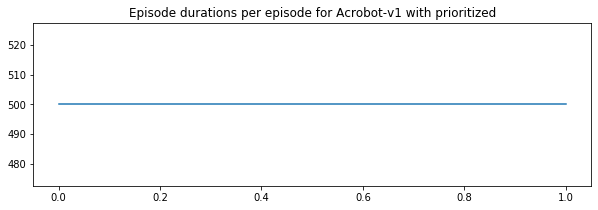


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.78s/it]

Total duration time:  5.700285196304321


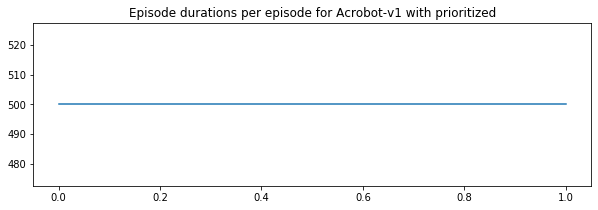


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.91s/it]

Total duration time:  5.912196397781372


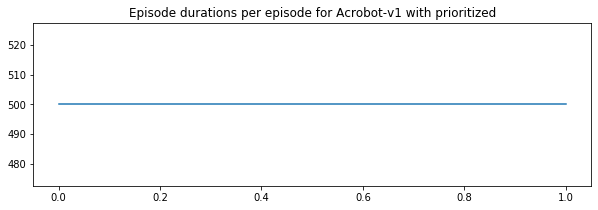


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.81s/it]

Total duration time:  5.78385591506958


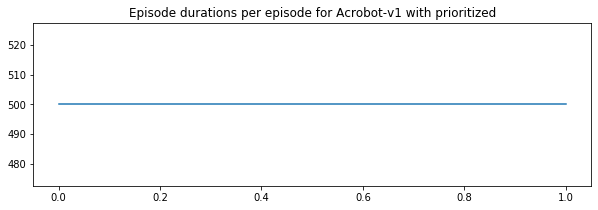


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.75s/it]

Total duration time:  5.616984844207764


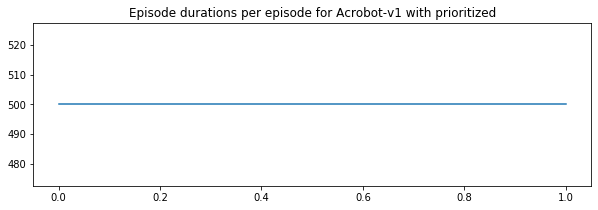


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.74s/it]

Total duration time:  5.653915166854858


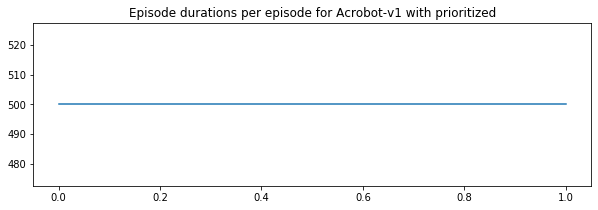


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.75s/it]

Total duration time:  5.658899307250977


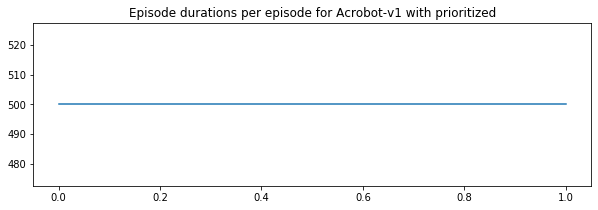


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.75s/it]

Total duration time:  5.6528332233428955


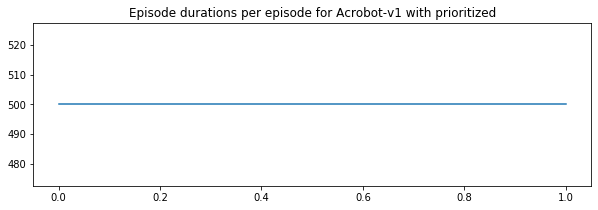


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.33s/it]

Total duration time:  4.302006244659424


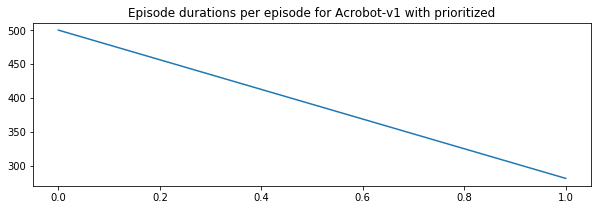


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.73s/it]

Total duration time:  5.665424346923828


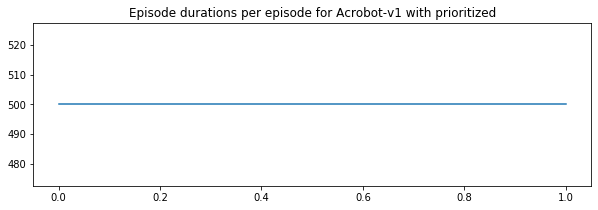


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.86s/it]

Total duration time:  5.955590486526489


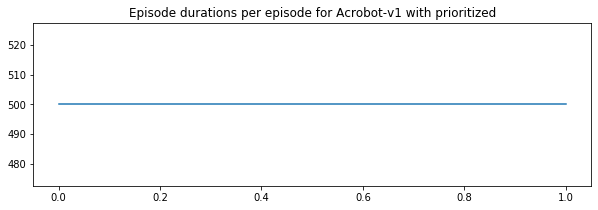


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.87s/it]

Total duration time:  5.62790846824646


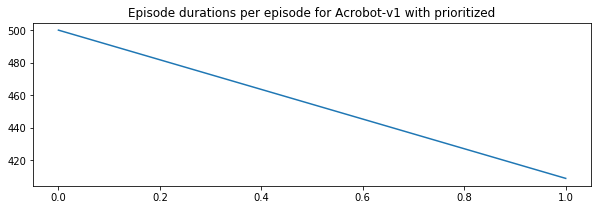


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.08s/it]

Total duration time:  6.330589532852173


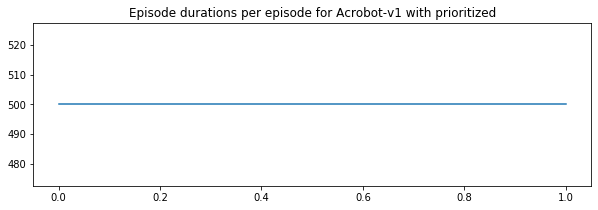


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.01s/it]

Total duration time:  6.090621709823608


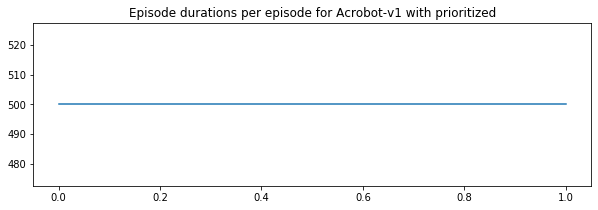


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  2.97s/it]

Total duration time:  6.010441780090332


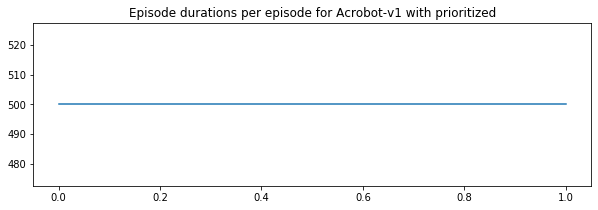


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.04s/it]

Total duration time:  6.377540826797485


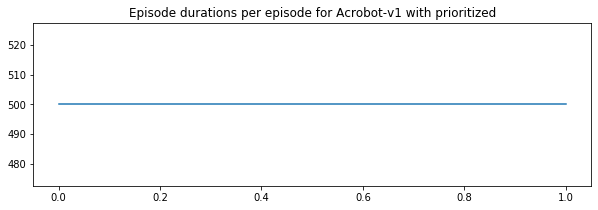


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  2.97s/it]

Total duration time:  6.092838764190674


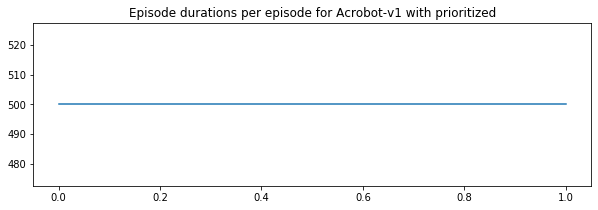


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.85s/it]

Total duration time:  5.9181811809539795


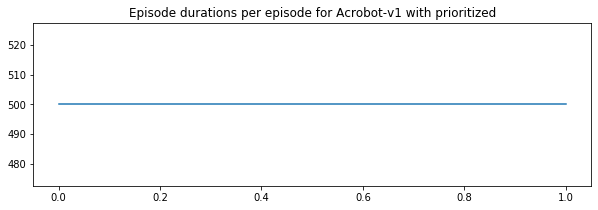


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.01s/it]

Total duration time:  6.1371002197265625


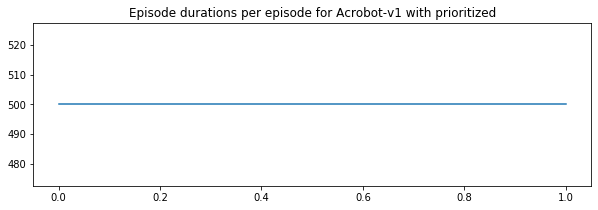


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  2.97s/it]

Total duration time:  6.0877845287323


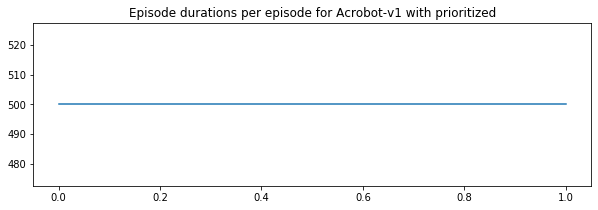


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.32s/it]

Total duration time:  4.16482949256897


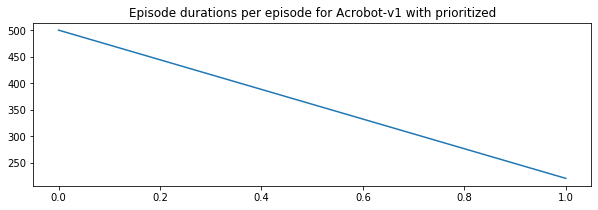


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.01s/it]

Total duration time:  6.254282236099243


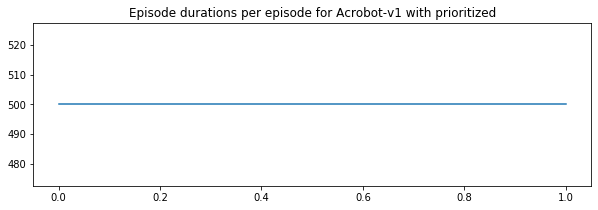


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.84s/it]

Total duration time:  5.805480241775513


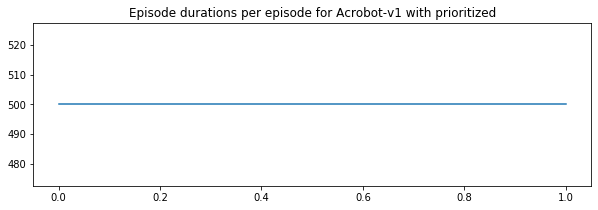


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.73s/it]

Total duration time:  5.753297805786133


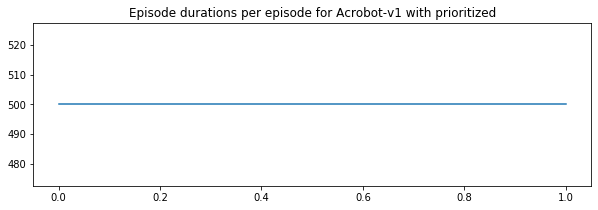


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.75s/it]

Total duration time:  5.6735076904296875


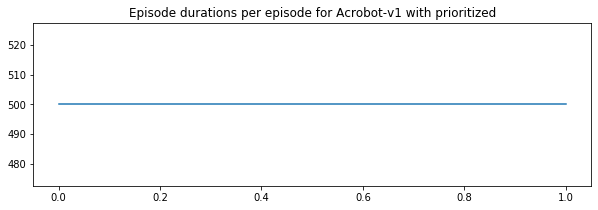


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.89s/it]

Total duration time:  5.918212413787842


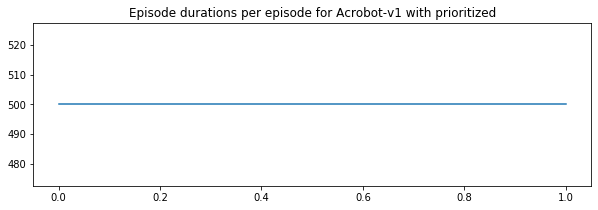


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.60s/it]

Total duration time:  4.949785232543945


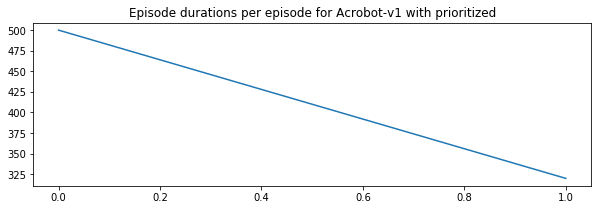


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.85s/it]

Total duration time:  5.859935283660889


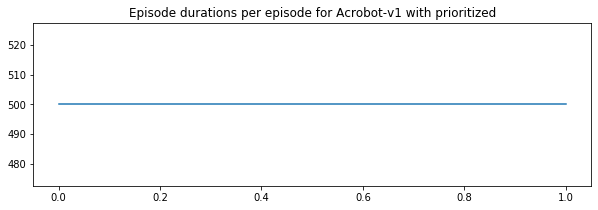


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.82s/it]

Total duration time:  5.794512033462524


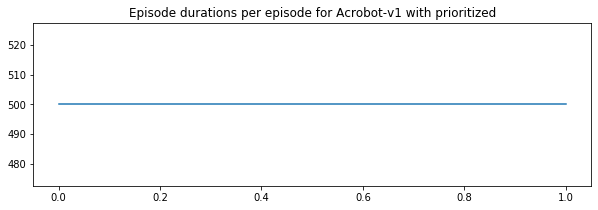


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.84s/it]

Total duration time:  5.9157116413116455


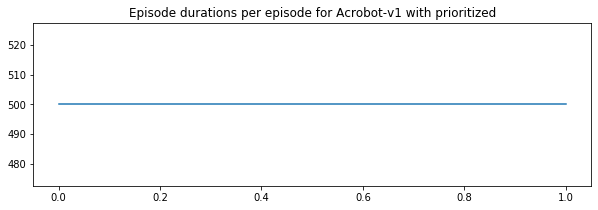


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.02s/it]

Total duration time:  6.10337495803833


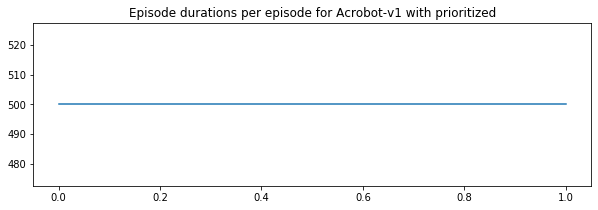


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.81s/it]

Total duration time:  5.7865588665008545


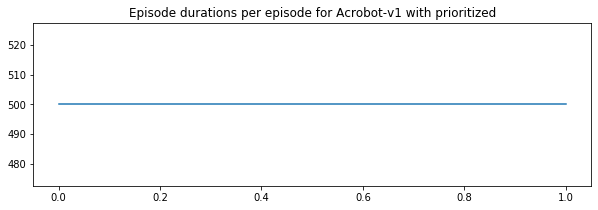


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.79s/it]

Total duration time:  5.727213382720947


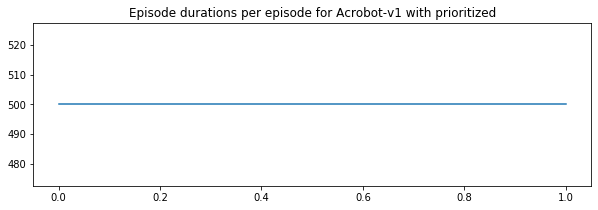


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.87s/it]

Total duration time:  5.94368314743042


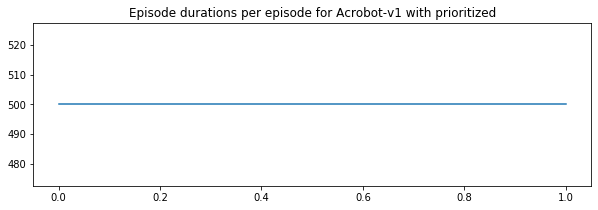


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.62s/it]

Total duration time:  4.6306235790252686


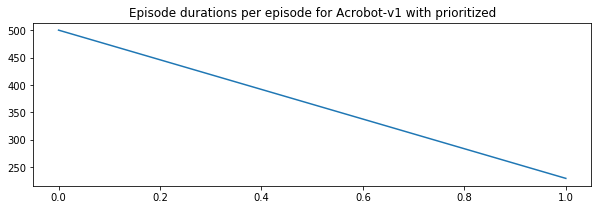


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.76s/it]

Total duration time:  5.521240234375


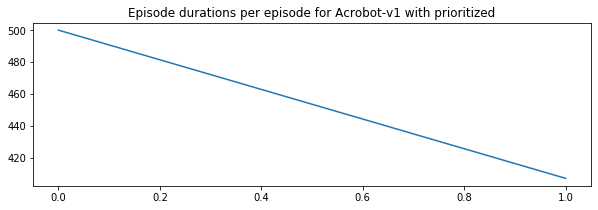


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.21s/it]

Total duration time:  6.68265962600708


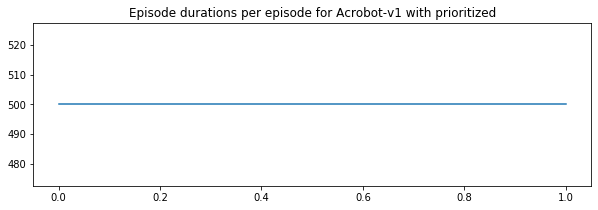


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.10s/it]

Total duration time:  6.2482240200042725


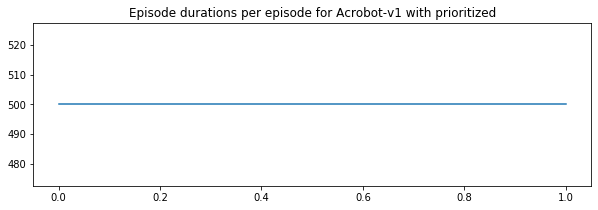


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.06s/it]

Total duration time:  6.305176019668579


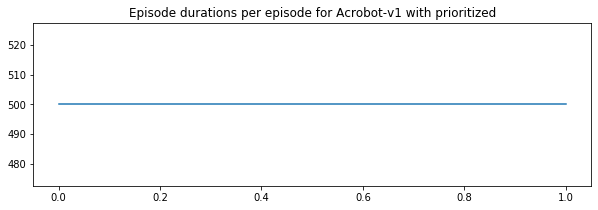


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.87s/it]

Total duration time:  5.949618816375732


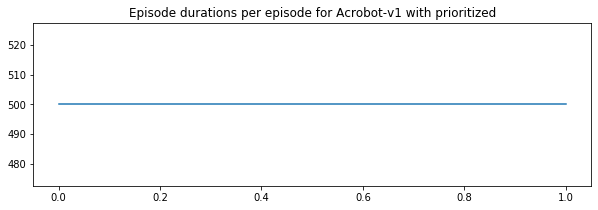


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  2.99s/it]

Total duration time:  6.265338182449341


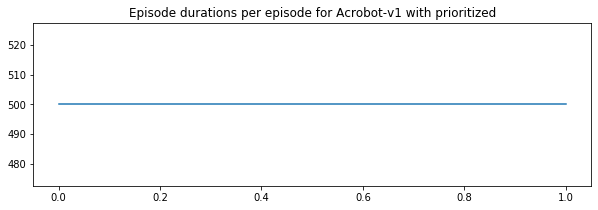


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.07s/it]

Total duration time:  6.30218243598938


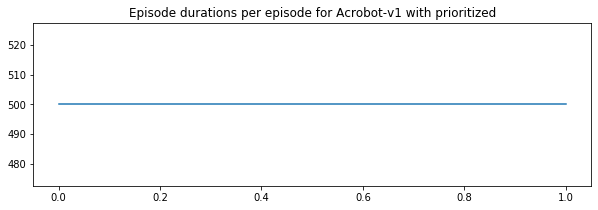


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.04s/it]

Total duration time:  6.285931587219238


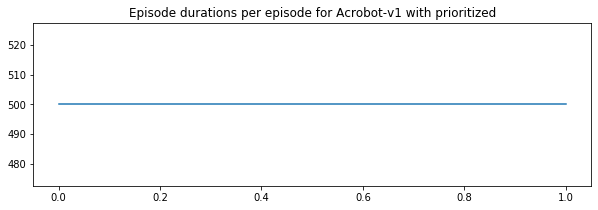


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.87s/it]

Total duration time:  5.855330467224121


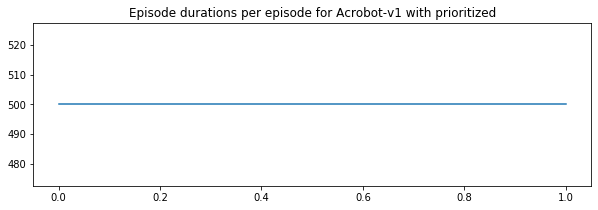


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.87s/it]

Total duration time:  5.917981386184692


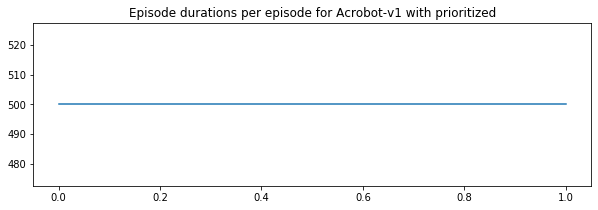


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.84s/it]

Total duration time:  5.910707235336304


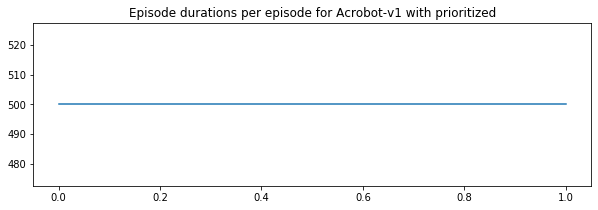


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  2.94s/it]

Total duration time:  6.041199445724487


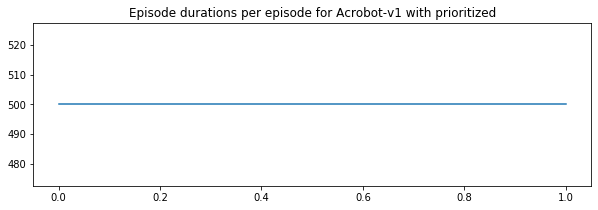


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.09s/it]

Total duration time:  6.3939361572265625


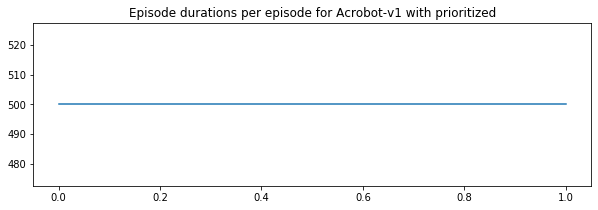


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  2.99s/it]

Total duration time:  6.191370487213135


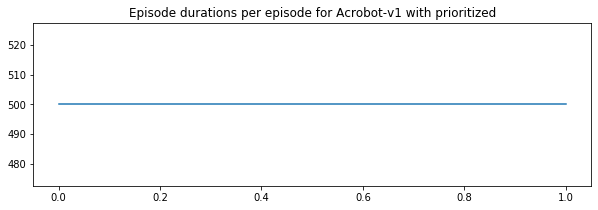


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  2.93s/it]

Total duration time:  6.083275556564331


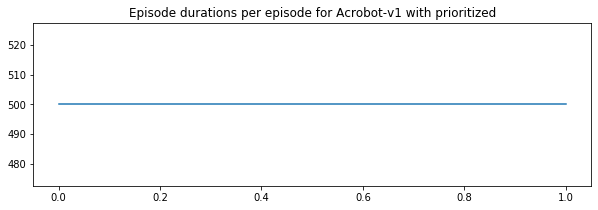


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.77s/it]

Total duration time:  5.668870210647583


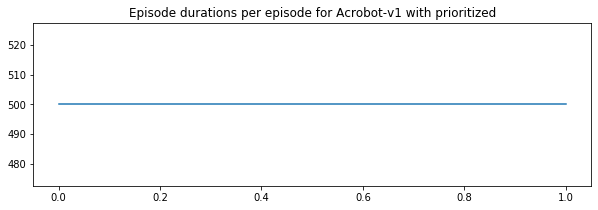


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  2.98s/it]

Total duration time:  6.319136619567871


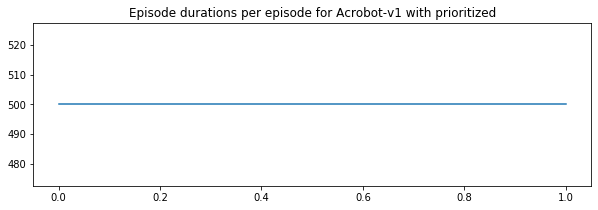


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  2.93s/it]

Total duration time:  6.075043201446533


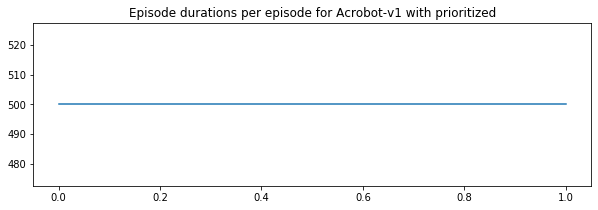


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  2.96s/it]

Total duration time:  6.059293985366821


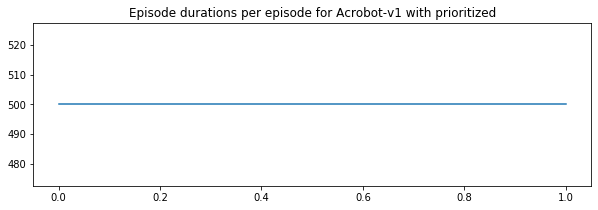


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.26s/it]

Total duration time:  5.1098644733428955


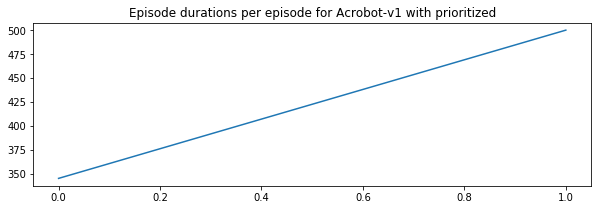


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.88s/it]

Total duration time:  5.915189981460571


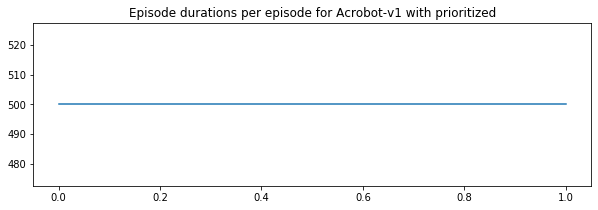


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.83s/it]

Total duration time:  5.854351997375488


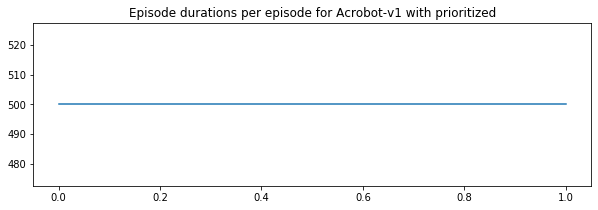


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.06s/it]

Total duration time:  6.411861181259155


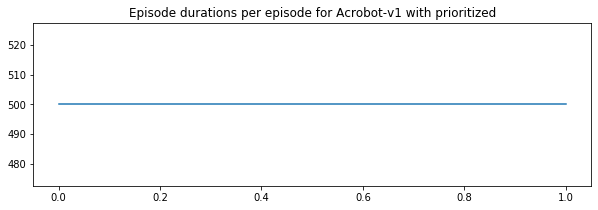


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  2.93s/it]

Total duration time:  6.073470115661621


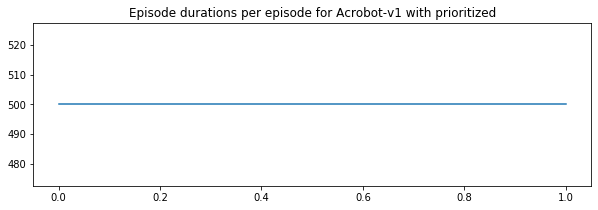


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  2.95s/it]

Total duration time:  6.040876150131226


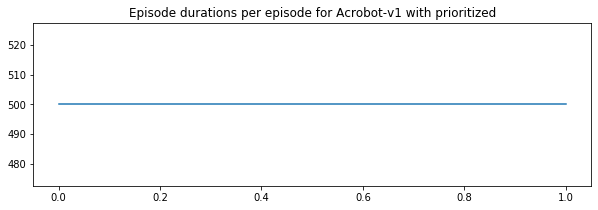


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.01s/it]

Total duration time:  6.132129430770874


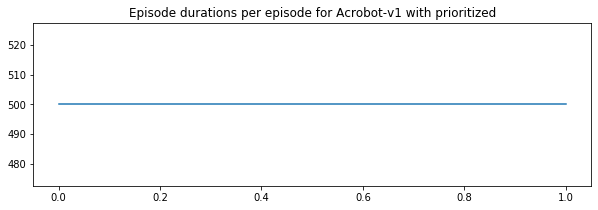


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.00s/it]

Total duration time:  6.242638349533081


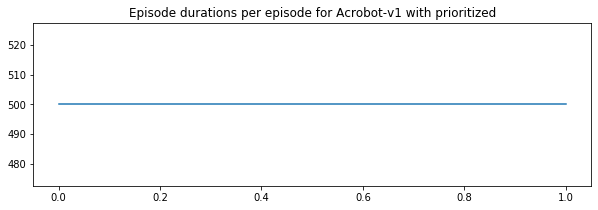


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.45s/it]

Total duration time:  4.379831314086914


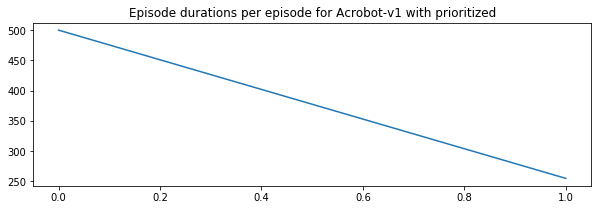


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  2.96s/it]

Total duration time:  6.052326679229736


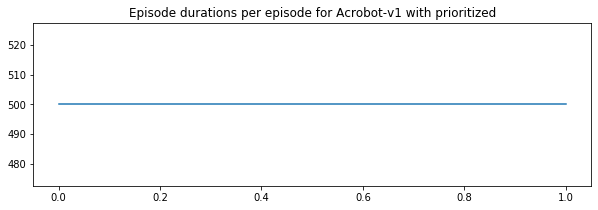


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.93s/it]

Total duration time:  3.7444982528686523


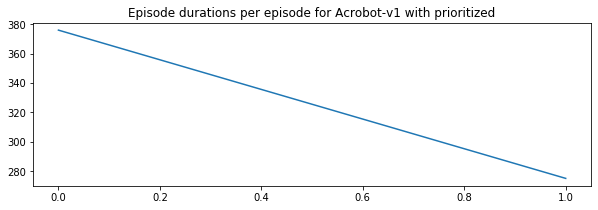


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.71s/it]

Total duration time:  5.183192729949951


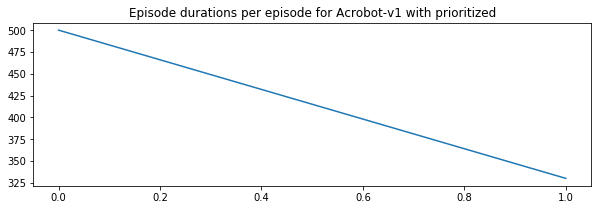


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  2.99s/it]

Total duration time:  6.149585247039795


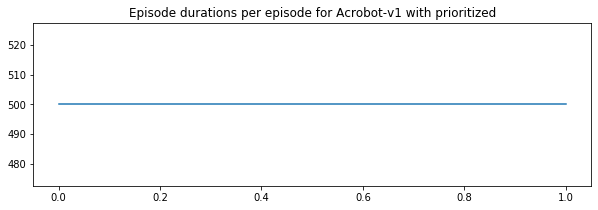


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.81s/it]

Total duration time:  5.793020009994507


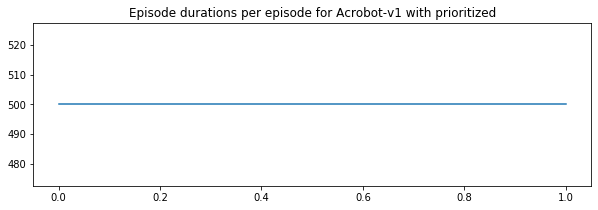


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.74s/it]

Total duration time:  5.4933435916900635


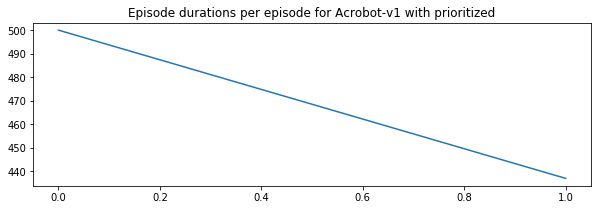


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.87s/it]

Total duration time:  5.93415379524231


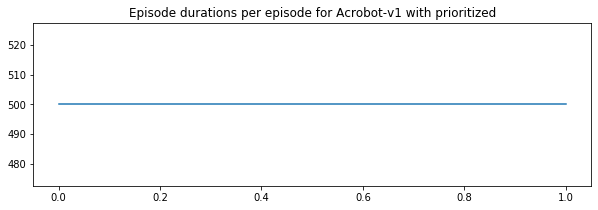


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.76s/it]

Total duration time:  5.76671290397644


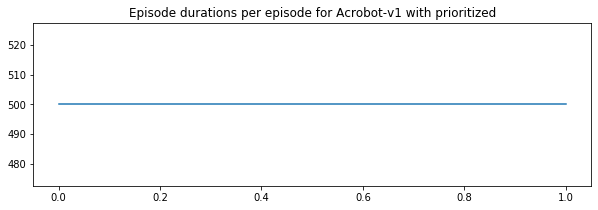


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  2.97s/it]

Total duration time:  6.062302112579346


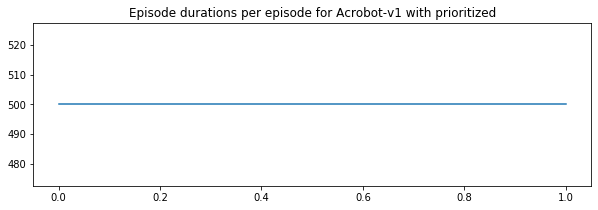


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.17s/it]

Total duration time:  6.421839952468872


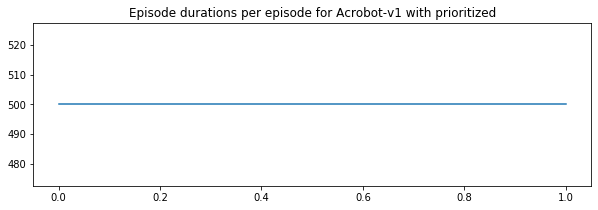


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.07s/it]

Total duration time:  6.265756845474243


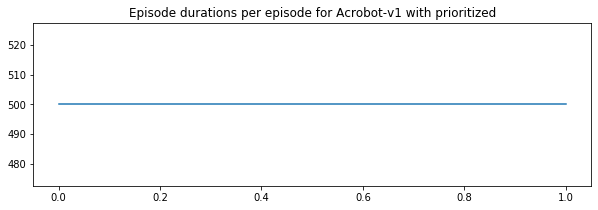


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.10s/it]

Total duration time:  6.342046499252319


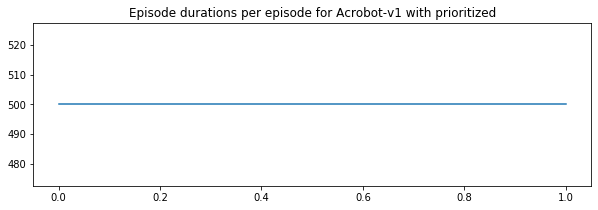


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  2.95s/it]

Total duration time:  6.084295272827148


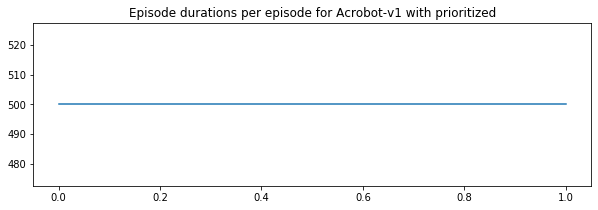


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.42s/it]

Total duration time:  4.334930896759033


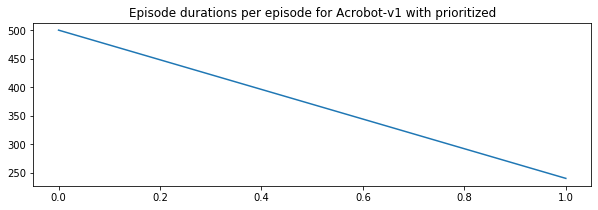


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.02s/it]

Total duration time:  6.267853021621704


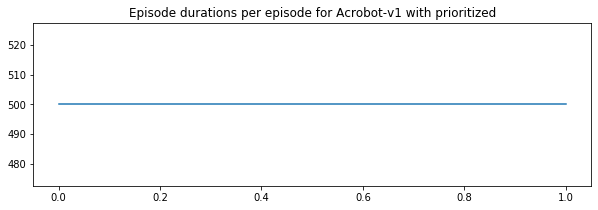


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.28s/it]

Total duration time:  6.559467315673828


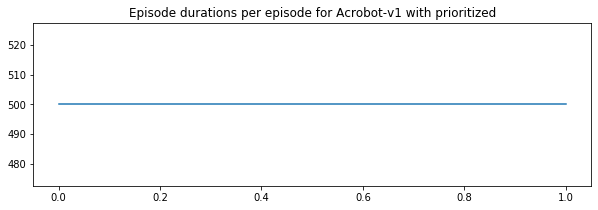


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.83s/it]

Total duration time:  5.725696563720703


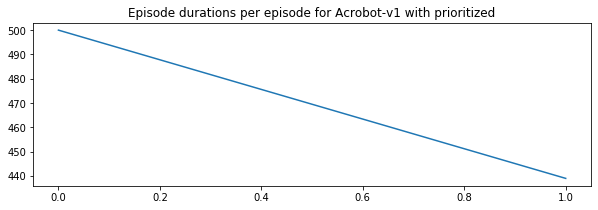


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]

Total duration time:  5.042065858840942


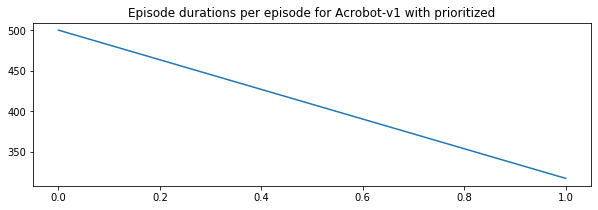


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.08s/it]

Total duration time:  6.3919291496276855


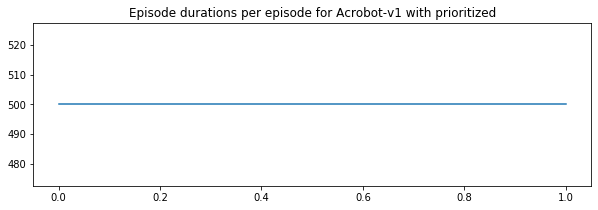


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.55s/it]

Total duration time:  4.592722177505493


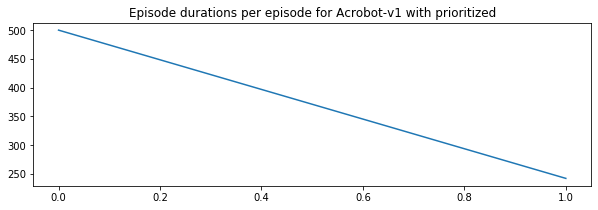


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.18s/it]

Total duration time:  6.523151397705078


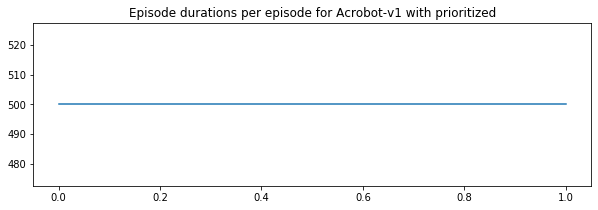


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.18s/it]

Total duration time:  6.56320858001709


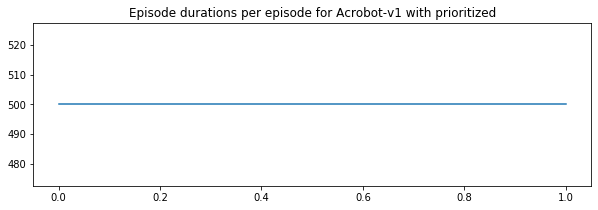


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.00s/it]

Total duration time:  6.252792119979858


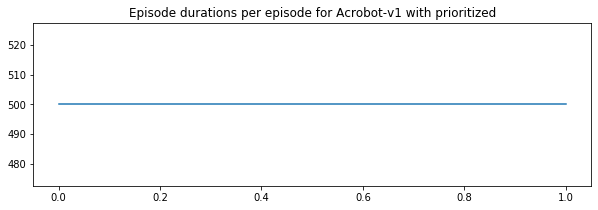


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  2.94s/it]

Total duration time:  6.057873010635376


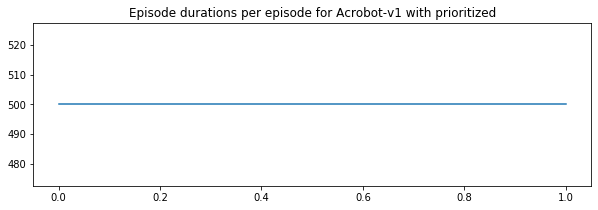


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.92s/it]

Total duration time:  5.949618577957153


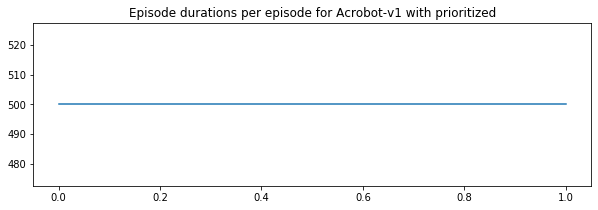


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.70s/it]

Total duration time:  5.592138290405273


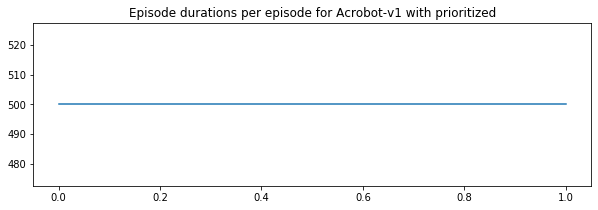


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.75s/it]

Total duration time:  5.5387122631073


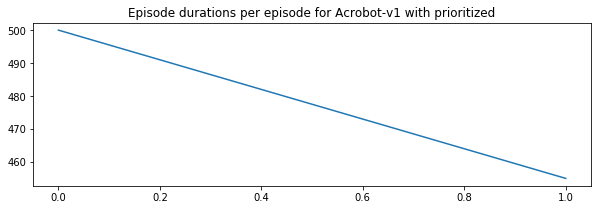


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  2.97s/it]

Total duration time:  6.14558219909668


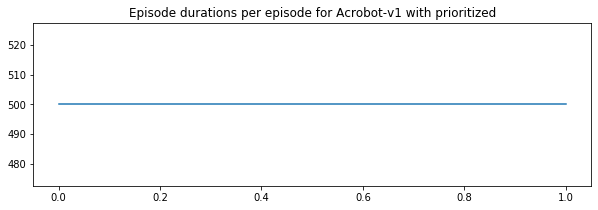


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  2.93s/it]

Total duration time:  6.0268895626068115


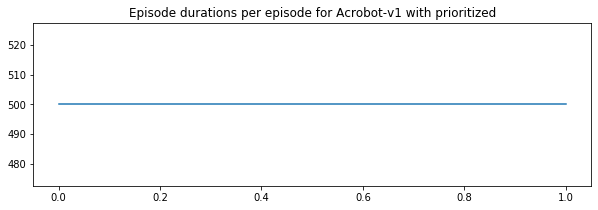


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  2.90s/it]

Total duration time:  6.049842119216919


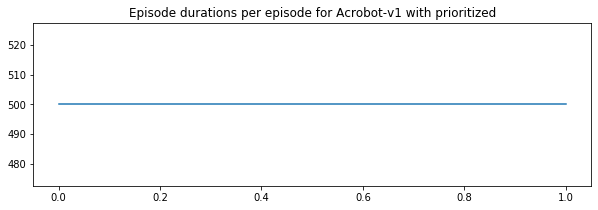


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  2.91s/it]

Total duration time:  6.03637433052063


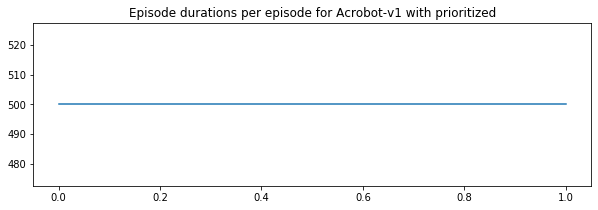


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.83s/it]

Total duration time:  5.856371164321899


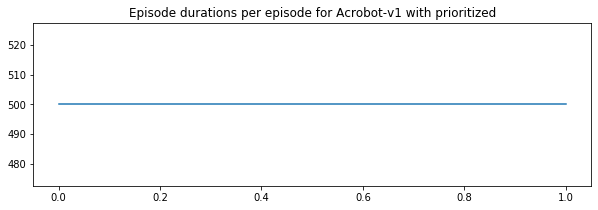


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.78s/it]

Total duration time:  5.708277463912964


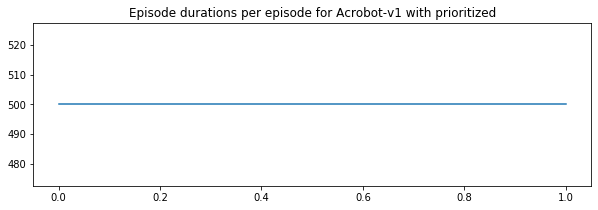


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.79s/it]

Total duration time:  5.747662305831909


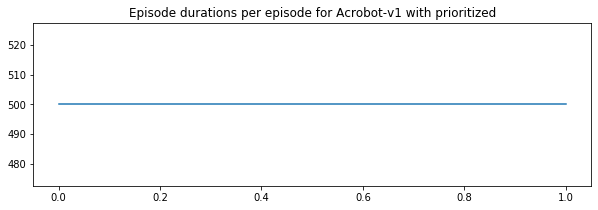


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.77s/it]

Total duration time:  5.768605947494507


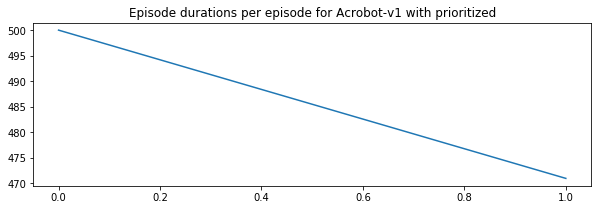


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.88s/it]

Total duration time:  5.909158706665039


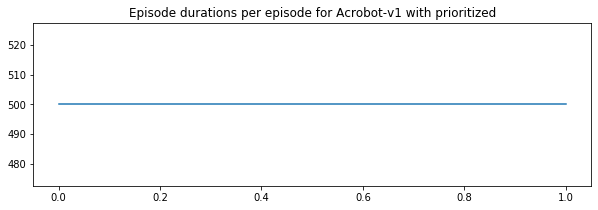


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.90s/it]

Total duration time:  5.871877670288086


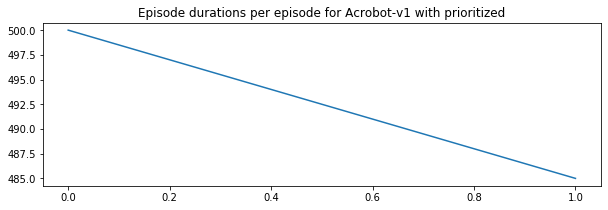


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.75s/it]

Total duration time:  5.630965709686279


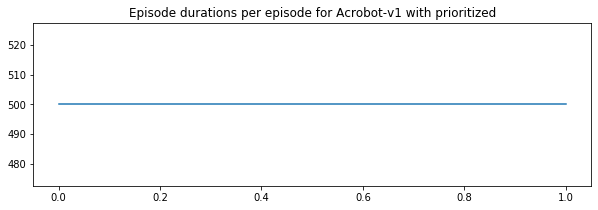


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.48s/it]

Total duration time:  4.489503860473633


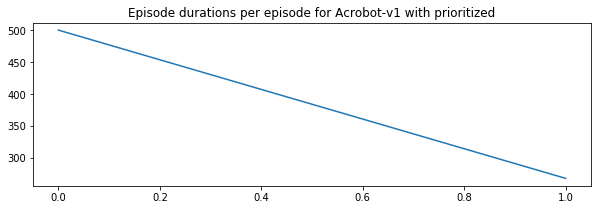


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.64s/it]

Total duration time:  5.181164503097534


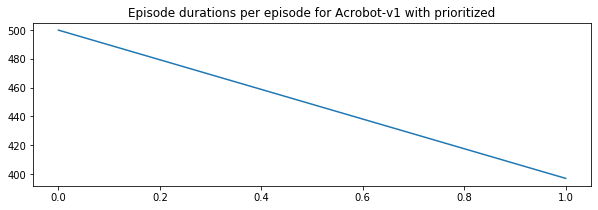


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.75s/it]

Total duration time:  5.533721685409546


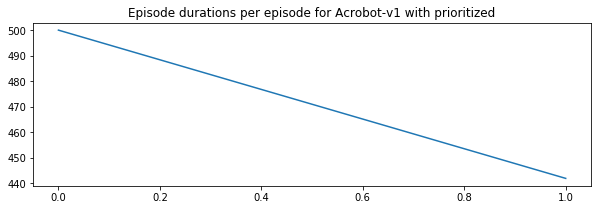


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.87s/it]

Total duration time:  5.967536449432373


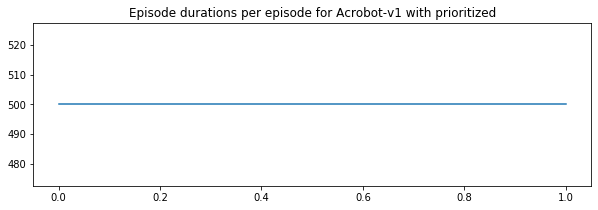


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  2.27s/it]

Total duration time:  4.000319719314575


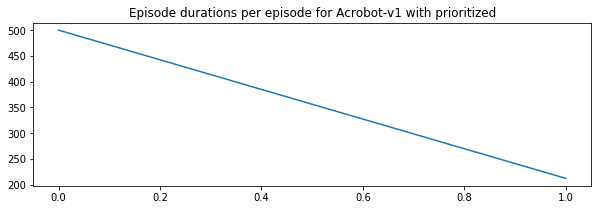


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.85s/it]

Total duration time:  5.8713059425354


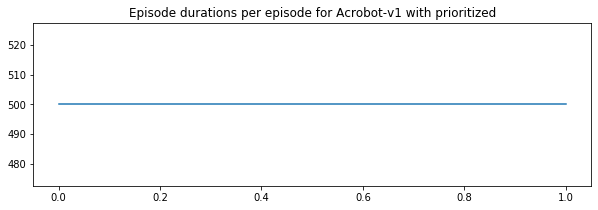


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]

Total duration time:  5.173172235488892


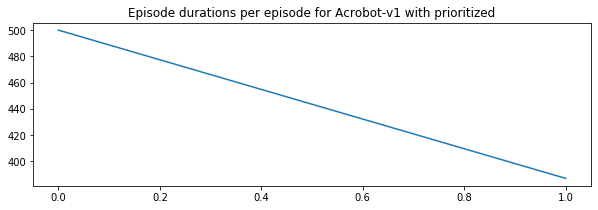


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.83s/it]

Total duration time:  5.83540153503418


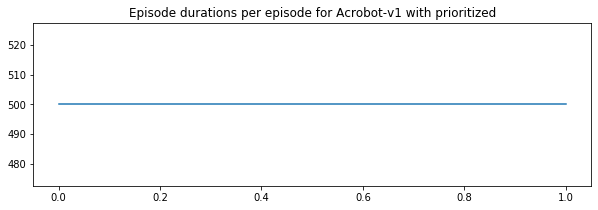


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.68s/it]

Total duration time:  5.544203519821167


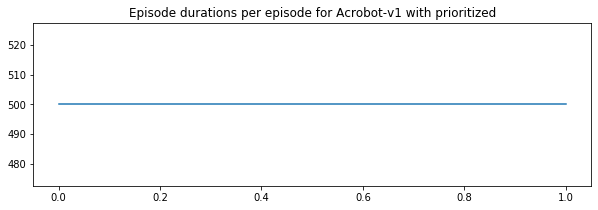


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.47s/it]

Total duration time:  4.734389066696167


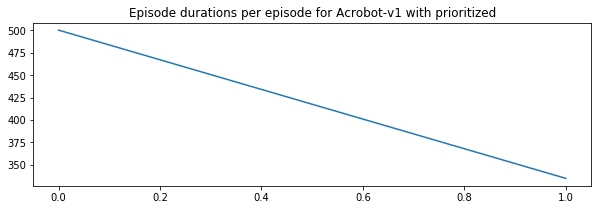


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.84s/it]

Total duration time:  5.80420446395874


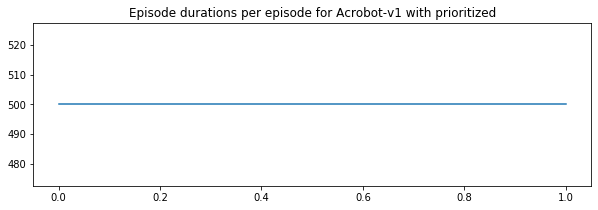


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.49s/it]

Total duration time:  4.683995723724365


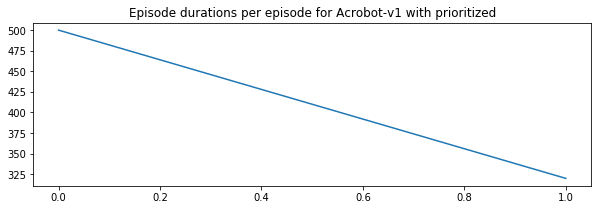


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.88s/it]

Total duration time:  5.859380483627319


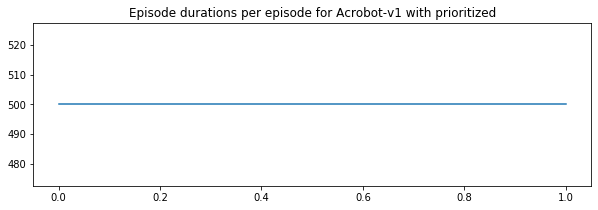


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.85s/it]

Total duration time:  5.8404221534729


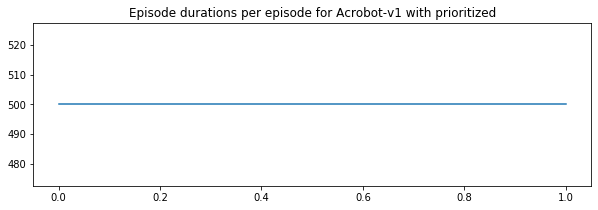


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.79s/it]

Total duration time:  5.759603977203369


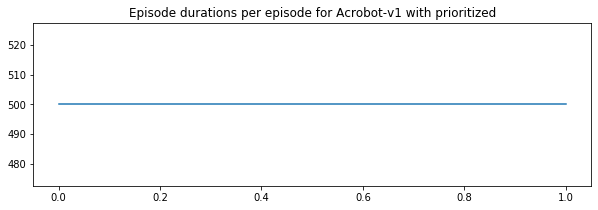


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.08s/it]

Total duration time:  6.202420234680176


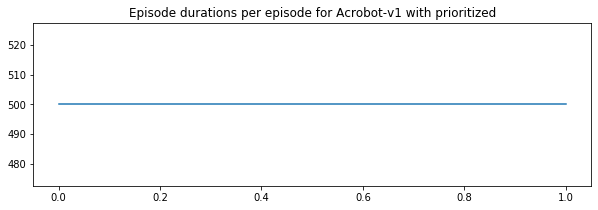


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.55s/it]

Total duration time:  4.705420732498169


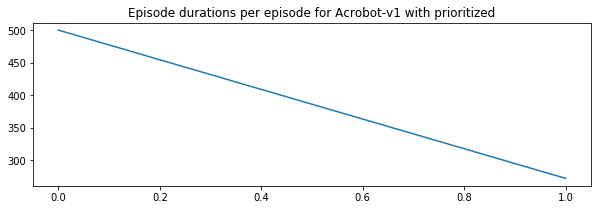


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.01s/it]

Total duration time:  6.141584634780884


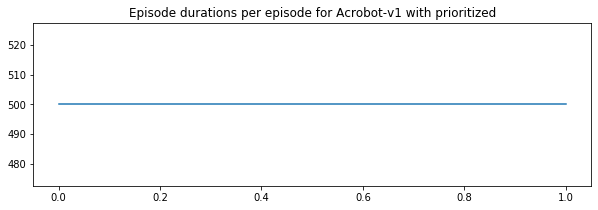


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.21s/it]

Total duration time:  6.57243013381958


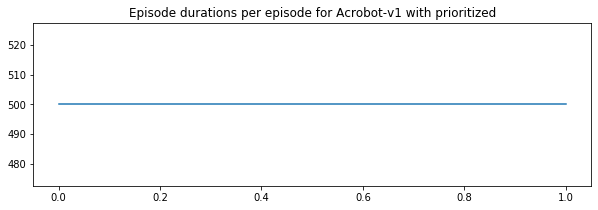


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.01s/it]

Total duration time:  6.119152784347534


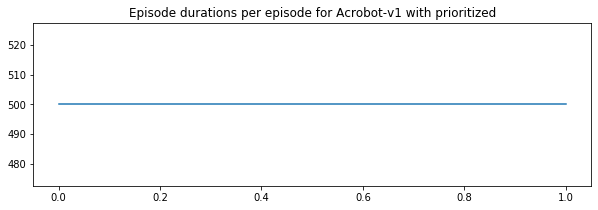


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.35s/it]

Total duration time:  4.4286792278289795


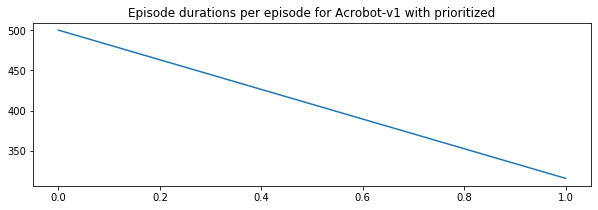


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  2.16s/it]

Total duration time:  3.7564845085144043


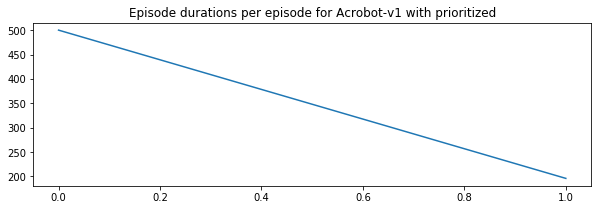


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.81s/it]

Total duration time:  5.807001829147339


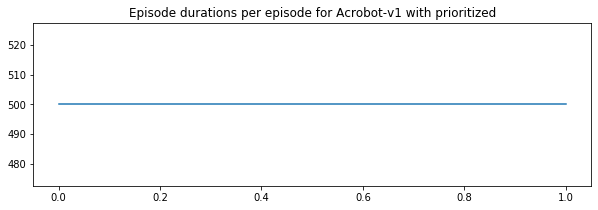


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.83s/it]

Total duration time:  5.699270725250244


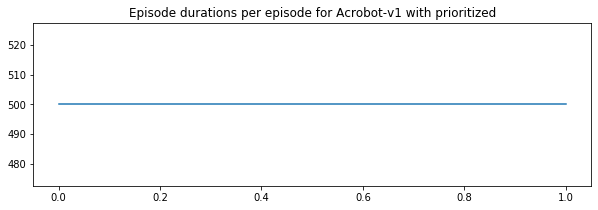


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  2.87s/it]

Total duration time:  6.024540901184082


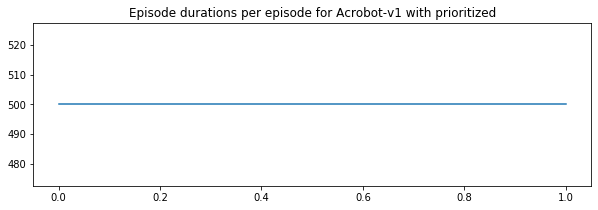


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  2.92s/it]

Total duration time:  6.052342414855957


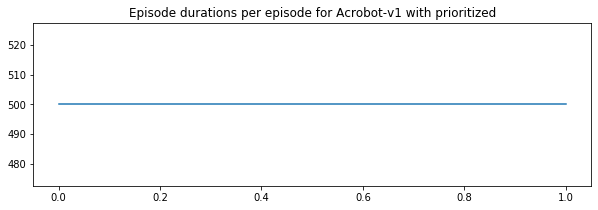


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.77s/it]

Total duration time:  5.750157117843628


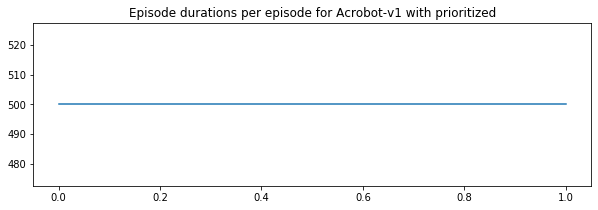


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  2.99s/it]

Total duration time:  6.252131700515747


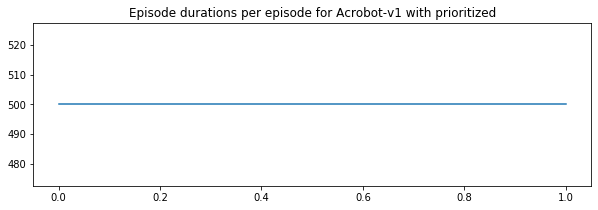


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.05s/it]

Total duration time:  6.2637903690338135


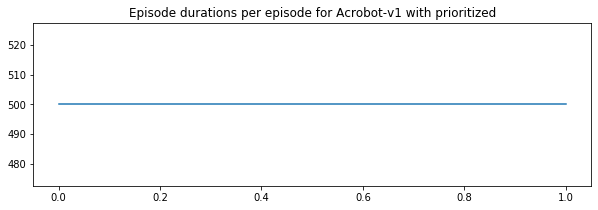


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.02s/it]

Total duration time:  6.201422452926636


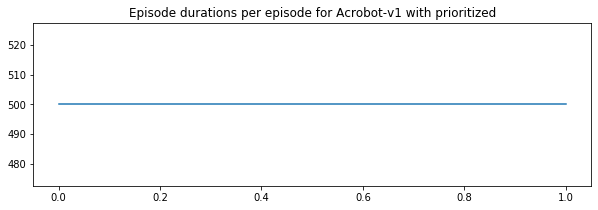


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.84s/it]

Total duration time:  5.903219223022461


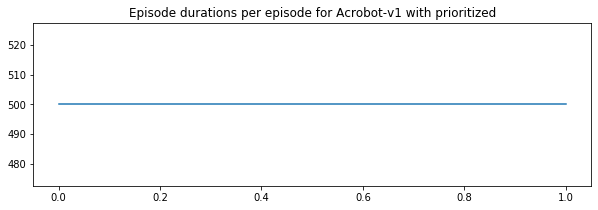


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  2.95s/it]

Total duration time:  6.0677807331085205


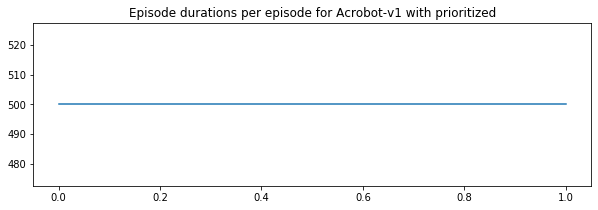


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  2.97s/it]

Total duration time:  6.045101642608643


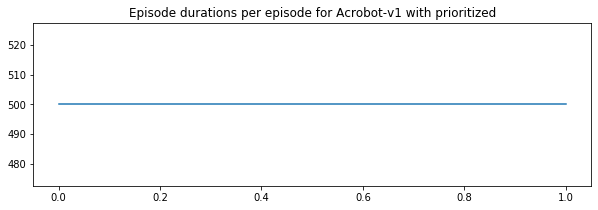


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.91s/it]

Total duration time:  5.906185150146484


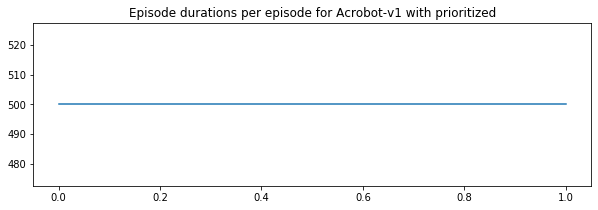


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.80s/it]

Total duration time:  5.75963568687439


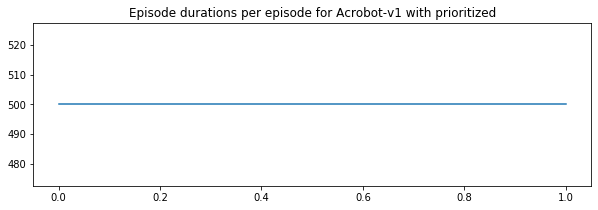


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.81s/it]

Total duration time:  5.792052984237671


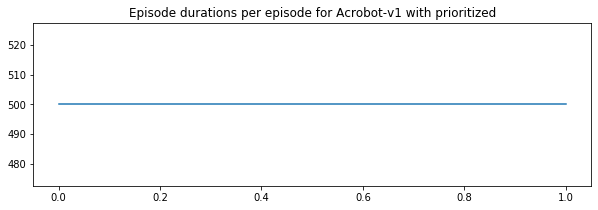


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.79s/it]

Total duration time:  5.738182783126831


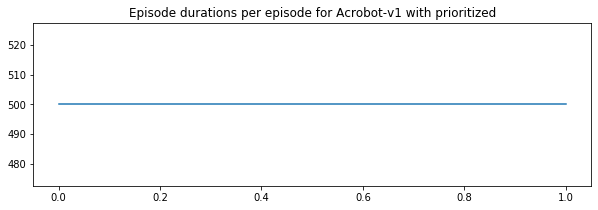


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.73s/it]

Total duration time:  5.260925531387329


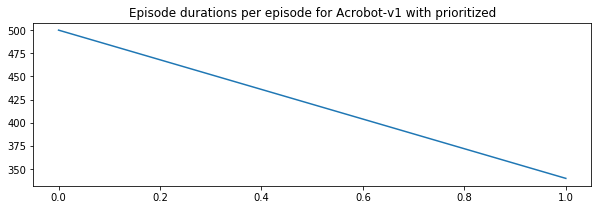


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  2.99s/it]

Total duration time:  6.241071462631226


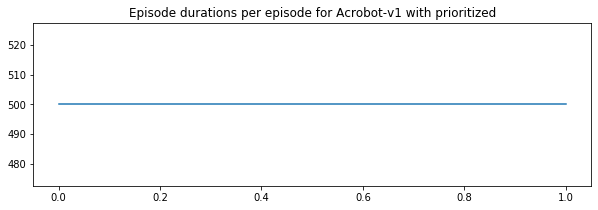


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.83s/it]

Total duration time:  5.843878984451294


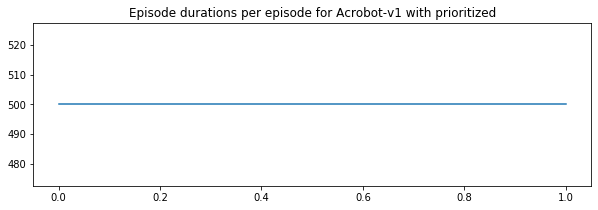


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.78s/it]

Total duration time:  5.704288721084595


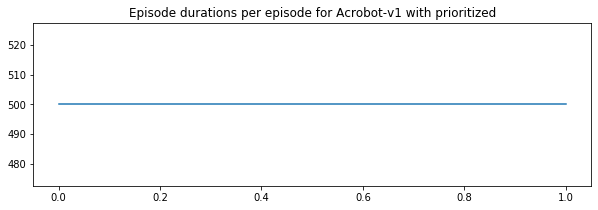


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.52s/it]

Total duration time:  4.943803548812866


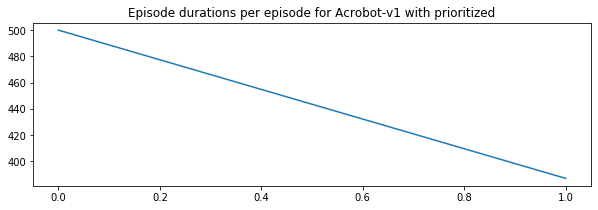


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.79s/it]

Total duration time:  5.678042411804199


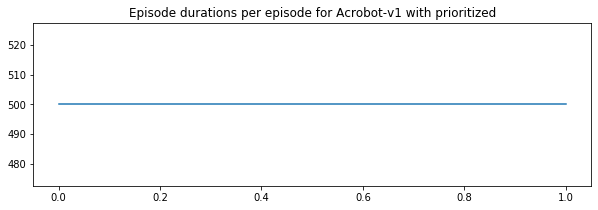


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.53s/it]

Total duration time:  4.866994380950928


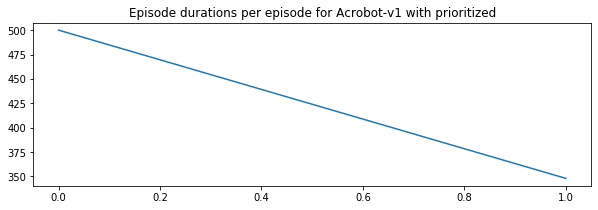


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.80s/it]

Total duration time:  5.754322052001953


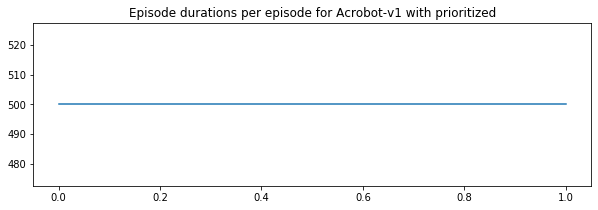


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.68s/it]

Total duration time:  5.513906002044678


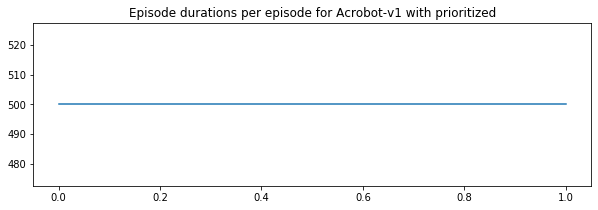


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.76s/it]

Total duration time:  5.676842451095581


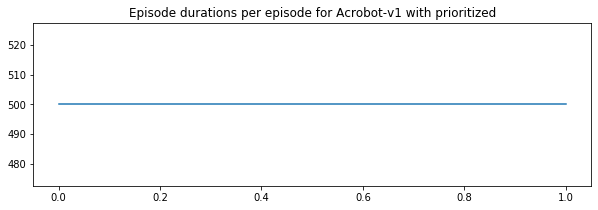


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.76s/it]

Total duration time:  5.669870138168335


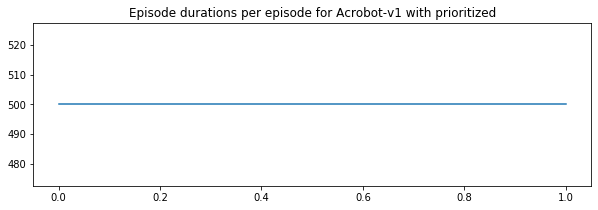


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.82s/it]

Total duration time:  5.842568635940552


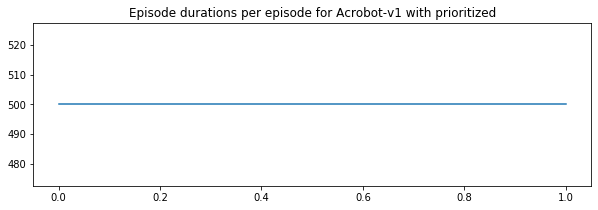


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.74s/it]

Total duration time:  5.627485990524292


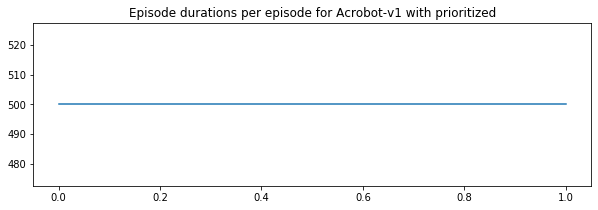


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.74s/it]

Total duration time:  5.627475023269653


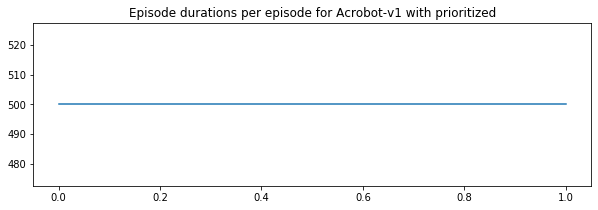


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.33s/it]

Total duration time:  4.298056602478027


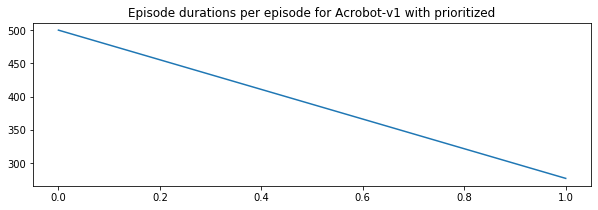


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.02s/it]

Total duration time:  6.160566329956055


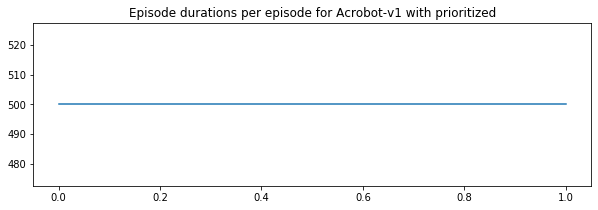


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.03s/it]

Total duration time:  6.280210971832275


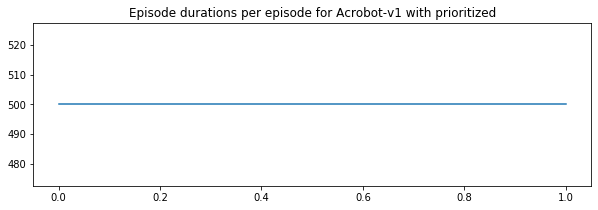


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.91s/it]

Total duration time:  5.963961124420166


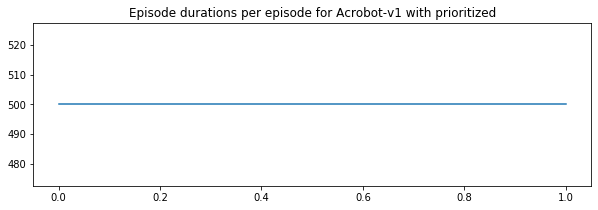


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.89s/it]

Total duration time:  6.002971172332764


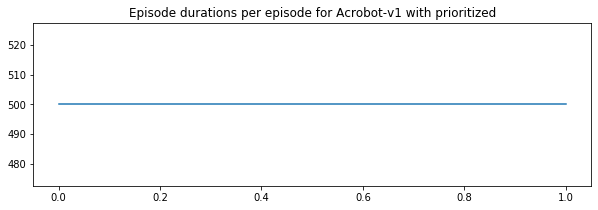


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.76s/it]

Total duration time:  5.665381669998169


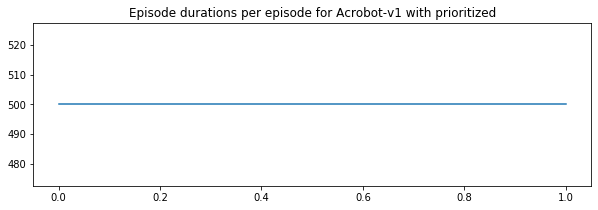


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.79s/it]

Total duration time:  5.713467121124268


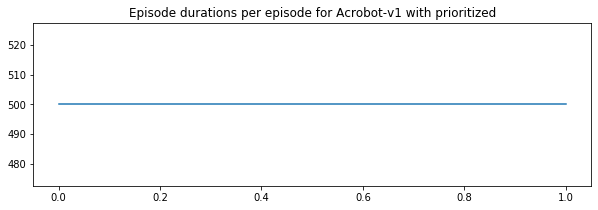


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.80s/it]

Total duration time:  5.75224494934082


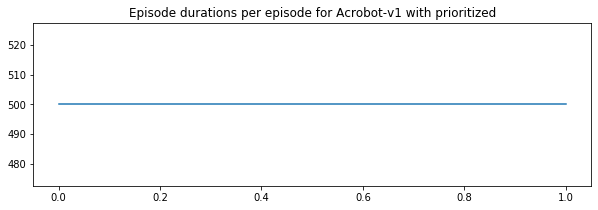


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.50s/it]

Total duration time:  4.471553564071655


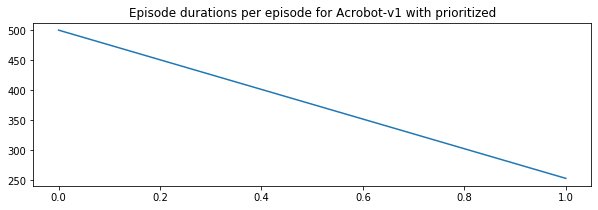


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.70s/it]

Total duration time:  5.632968187332153


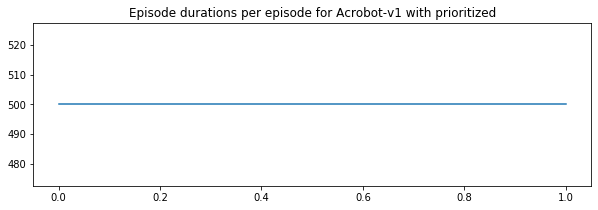


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.77s/it]

Total duration time:  5.746662616729736


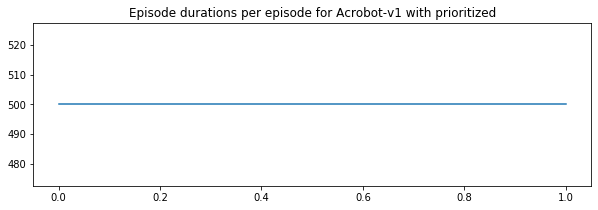


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.74s/it]

Total duration time:  5.594620227813721


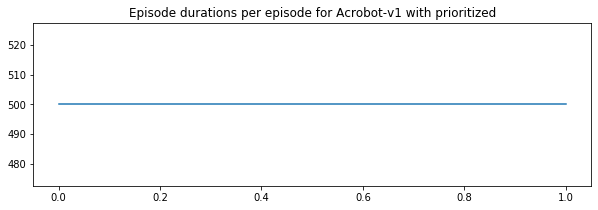


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.91s/it]

Total duration time:  5.969507694244385


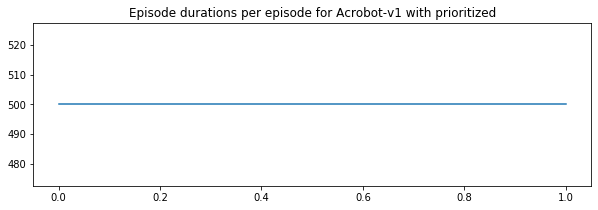


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.83s/it]

Total duration time:  5.825055122375488


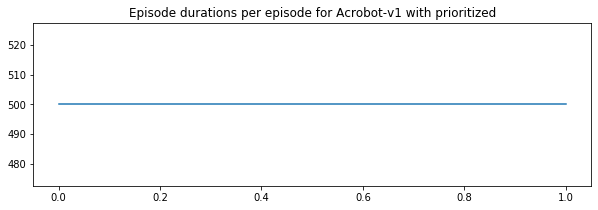


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.82s/it]

Total duration time:  5.842421054840088


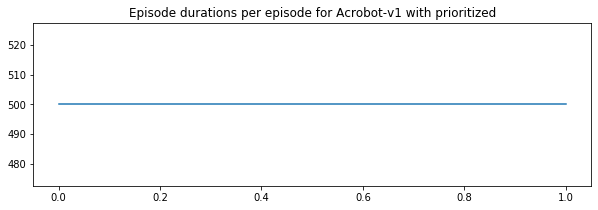


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.08s/it]

Total duration time:  6.306182384490967


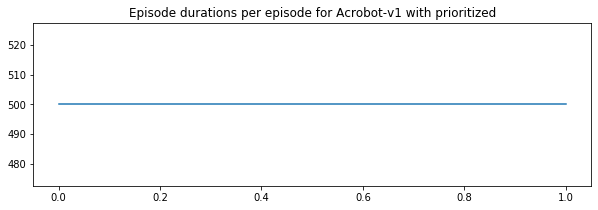


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.10s/it]

Total duration time:  6.340712785720825


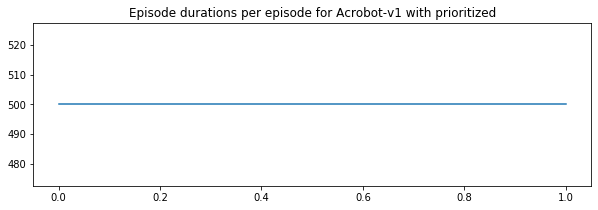


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.95s/it]

Total duration time:  5.869355201721191


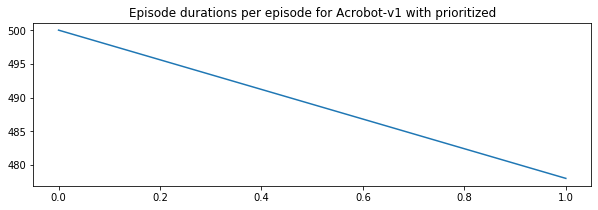


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.81s/it]

Total duration time:  5.8573737144470215


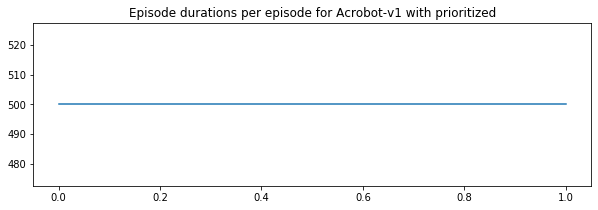


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.95s/it]

Total duration time:  5.947890758514404


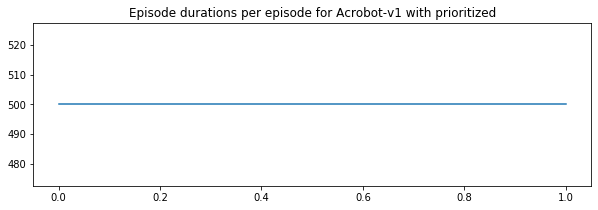


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.74s/it]

Total duration time:  5.6743505001068115


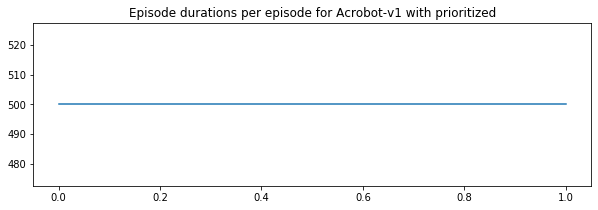


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.92s/it]

Total duration time:  5.976140022277832


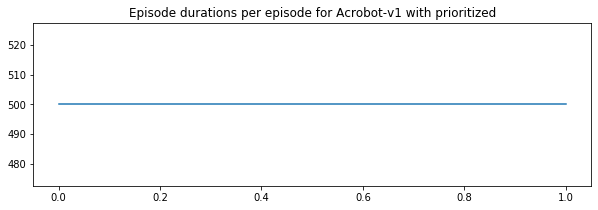


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.85s/it]

Total duration time:  5.911412477493286


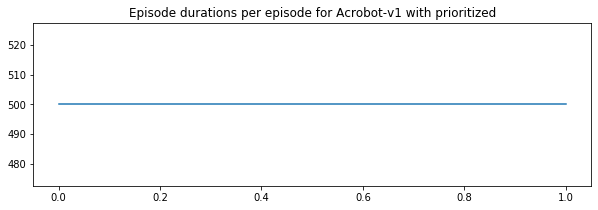


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.01s/it]

Total duration time:  6.140584230422974


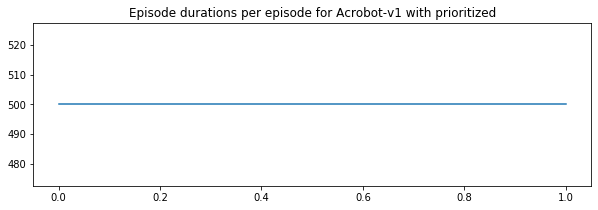


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.97s/it]

Total duration time:  5.94311261177063


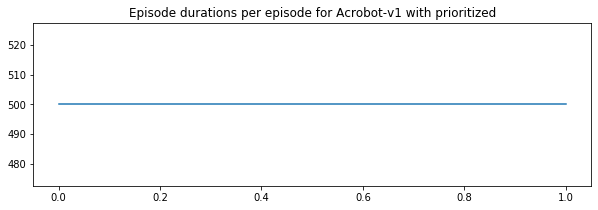


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.51s/it]

Total duration time:  4.741047620773315


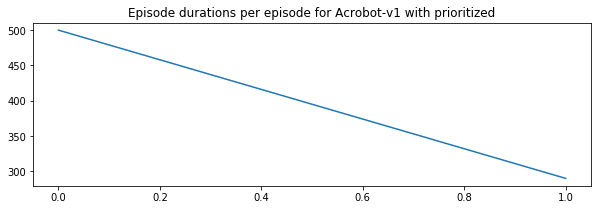


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.81s/it]

Total duration time:  5.450465440750122


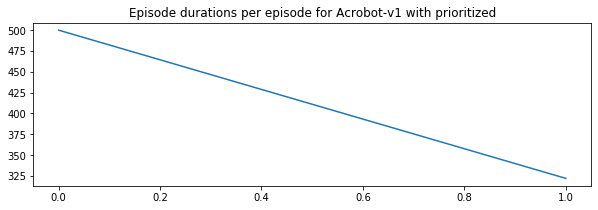


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.18s/it]

Total duration time:  6.517812252044678


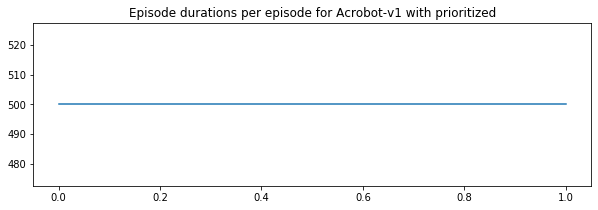


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.20s/it]

Total duration time:  6.494640111923218


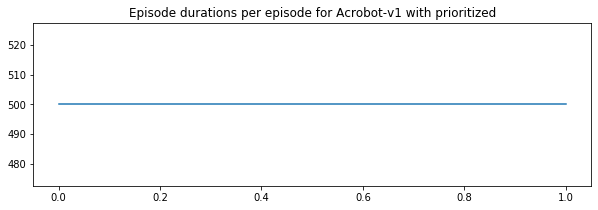


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.85s/it]

Total duration time:  5.885788917541504


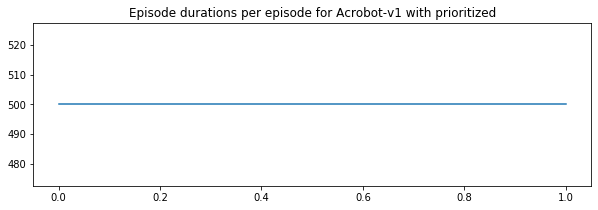


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.08s/it]

Total duration time:  6.204008340835571


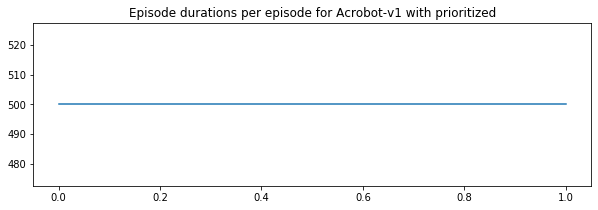


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.03s/it]

Total duration time:  6.184974908828735


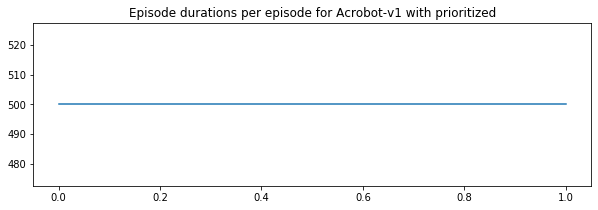


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.62s/it]

Total duration time:  4.894964933395386


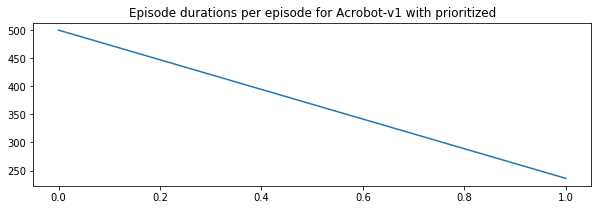


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.21s/it]

Total duration time:  6.124726057052612


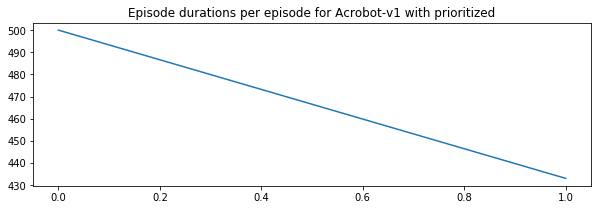


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.89s/it]

Total duration time:  5.905733823776245


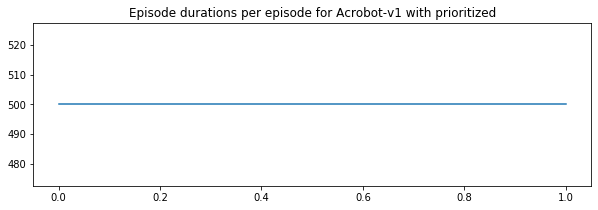


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.79s/it]

Total duration time:  5.709766387939453


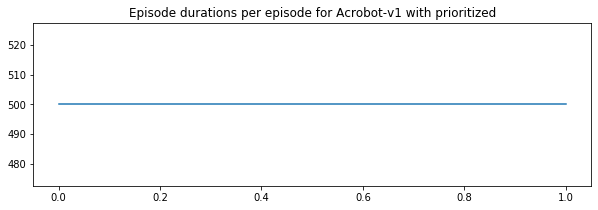


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.75s/it]

Total duration time:  5.656686305999756


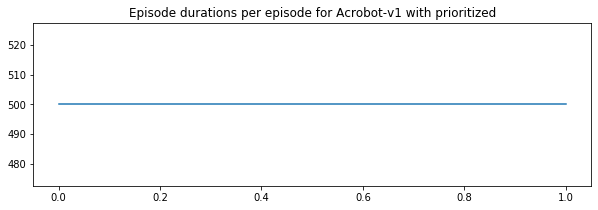


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.78s/it]

Total duration time:  5.684790134429932


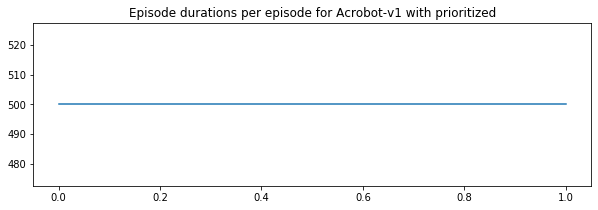


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.78s/it]

Total duration time:  5.668354272842407


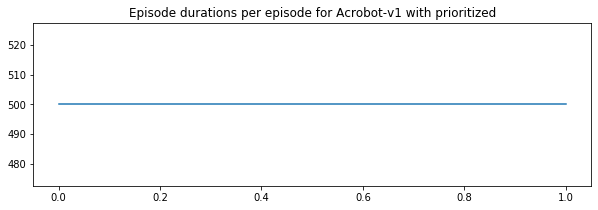


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.74s/it]

Total duration time:  5.6459527015686035


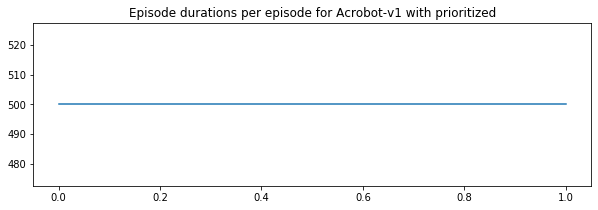


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  2.99s/it]

Total duration time:  6.118167877197266


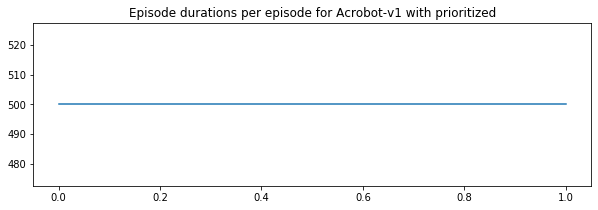


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.70s/it]

Total duration time:  5.569147348403931


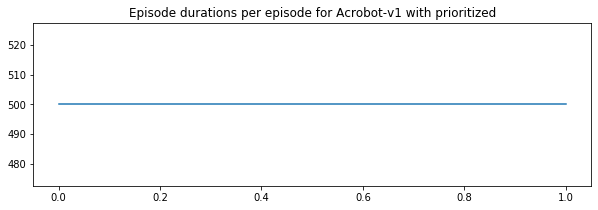


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.68s/it]

Total duration time:  5.49483585357666


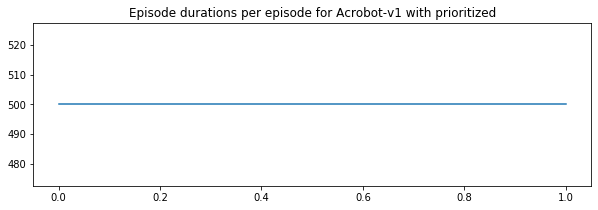


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.73s/it]

Total duration time:  5.614007472991943


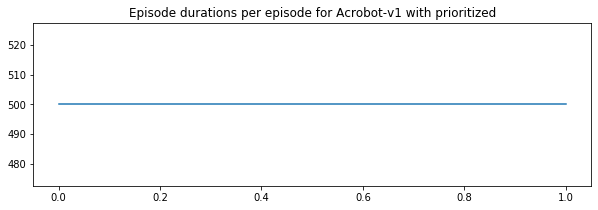


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.75s/it]

Total duration time:  5.633619546890259


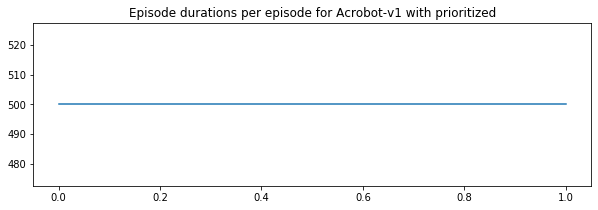


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.81s/it]

Total duration time:  5.733180522918701


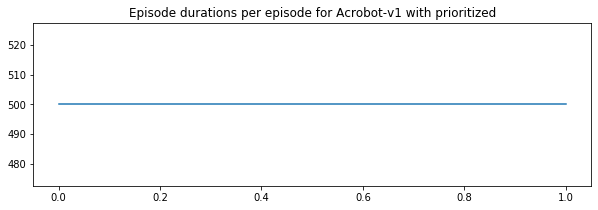


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.79s/it]

Total duration time:  5.728733777999878


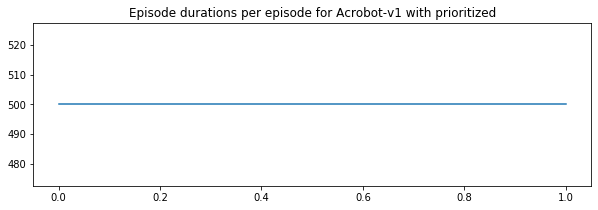


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.61s/it]

Total duration time:  5.332004070281982


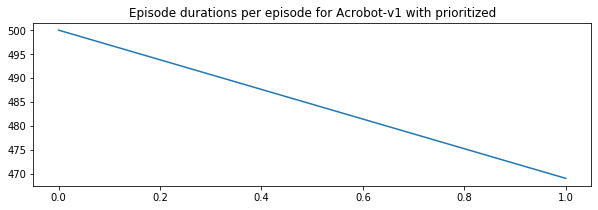


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.79s/it]

Total duration time:  5.8852691650390625


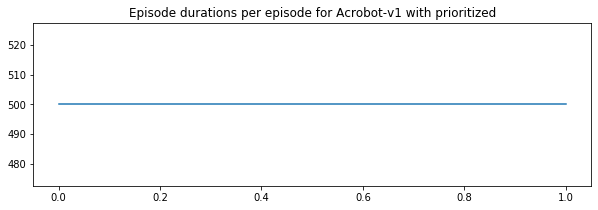


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.82s/it]

Total duration time:  5.795552968978882


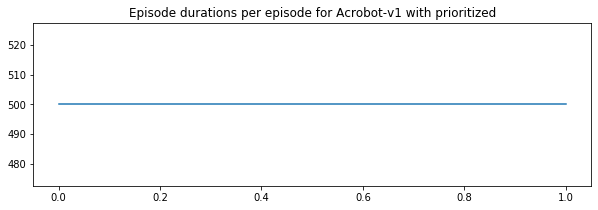


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.69s/it]

Total duration time:  5.526770353317261


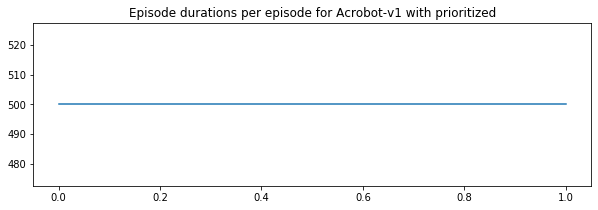


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.84s/it]

Total duration time:  5.913724422454834


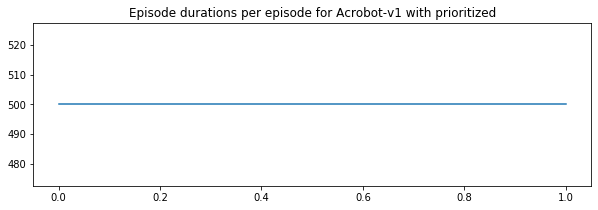


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.77s/it]

Total duration time:  5.679845333099365


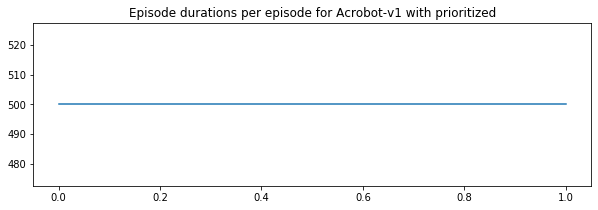


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.71s/it]

Total duration time:  5.619506597518921


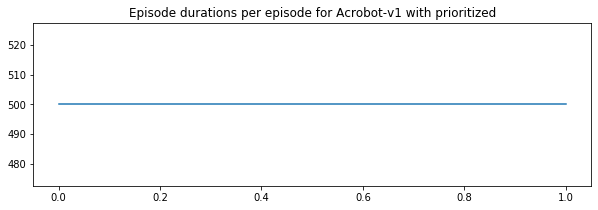


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.05s/it]

Total duration time:  6.201458215713501


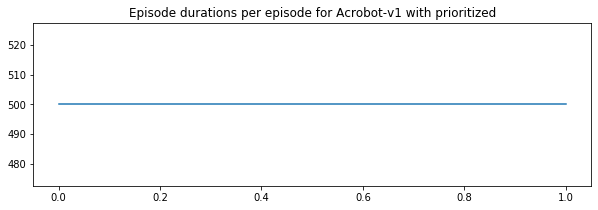


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.89s/it]

Total duration time:  5.879811763763428


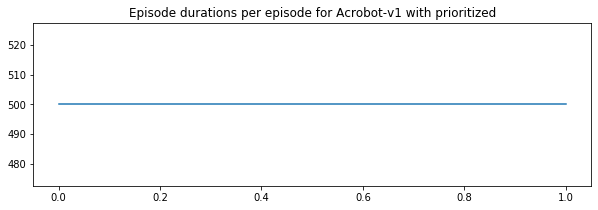

NameError: name 'pickle' is not defined

In [53]:
#Fixed Hyperparameters
num_episodes = 2
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
buffer_size = 10000

#Parameters for selective
episodic_buffer_size = 12000

#Parameters for hindsight
k = 4
env_name = env.unwrapped.spec.id
bigger_buffer_size = 10000 * k

all_durations = []
all_info = []
memory_method = 2
beta_max_iter = env._max_episode_steps

for env in [env_acrobot]: #[env_cartpole, env_car, env_acrobot]:
    env_name = env.unwrapped.spec.id
    #if env_name == "MountainCar-v0":
    #    num_episodes = 1500
    #else:
    #    num_episodes = 1000
    
    #Parameters for network, e.g. hidden dim
    num_input = len(env.observation_space.sample())
    num_hidden = 128
    num_output = env.action_space.n

    for seed in [7,25]:#,17,50,60]:
        random.seed(seed)
        torch.manual_seed(seed)
        env.seed(seed)
        np.random.seed(seed) 
    
        for beta_start in [0,0.2,0.4]:
            for beta_end in [0.6,0.8,1.0]:
                for prioritized_replay_alpha in [0.4,0.6,0.8]:

                    if memory_method == 1:  #Uniform
                        memory = ReplayMemory(buffer_size)
                        train_func = train #Uniform
                        select_action_func = select_action #epsilon greedy

                    elif memory_method == 2:   #Prioritzed
                        memory = PrioritizedReplayBuffer(buffer_size, alpha=prioritized_replay_alpha)
                        train_func = train_prioritized #Prioritized Replay
                        select_action_func = select_action #epsilon greedy

                    elif memory_method == 3:   #Selective
                        memory = SelectiveReplayMemory(buffer_size,episodic_buffer_size)
                        train_func = train #same way as uniform
                        select_action_func = select_action #epsilon greedy

                    elif memory_method == 4: #Hindsight
                        num_input = 2 * num_input
                        memory = HindsightReplayMemory(bigger_buffer_size,k,env_name)
                        train_func = train #same way as uniform
                        select_action_func = select_action #epsilon greedy

                    #Initialize model
                    model = QNetwork(device,num_input,num_hidden,num_output)
                    model = model.to(device)

                    #Running
                    start_time = time.time()
                    episode_durations = run_episodes(train_func,select_action_func, model, memory, env, num_episodes, batch_size, discount_factor, learn_rate,
                                                    beta_max_iter,beta_start,beta_end)
                    end_time = time.time()

                    print("Total duration time: ", str(end_time - start_time))
                    
                    all_durations.append(episode_durations)

                    all_info.append( (env_name,"num_episodes: " + str(num_episodes), "seed: " + str(seed), 
                                    "beta_start: " + str(beta_start),"beta_end: " + str(beta_end),"beta max iter: " + str(beta_max_iter)) )

                    #fig = plt.figure(figsize=(10,3))
                    #plt.plot(smooth(episode_durations, 1))
                    #plt.title('Episode durations per episode for ' + env_name + " with " + memory.name)
                    #plt.show()
                
pickle_action( [all_durations,all_info],"PER_hyper_results.p",action="w")

#### Selective


In [71]:
#Fixed Hyperparameters
num_episodes = 1
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
buffer_size = 10000

#Parameters for schedule of beta and alpha for prioritized replay
beta_max_iter = 1000
beta_start = 0.4
beta_end = 1.0
prioritized_replay_alpha = 0.6
#prioritized_replay_eps=1e-6 Set default in the training function

#Parameters for selective
episodic_buffer_size = 12000

#Parameters for hindsight
k = 4
env_name = env.unwrapped.spec.id
bigger_buffer_size = 10000 * k

all_durations = []
all_info = []
memory_method = 3

for env in [env_acrobot]: #[env_cartpole, env_car, env_acrobot]:
    env_name = env.unwrapped.spec.id
    
    #Parameters for network, e.g. hidden dim
    num_input = len(env.observation_space.sample())
    num_hidden = 128
    num_output = env.action_space.n

    for seed in [7,25]:#,17,50,60]:
        random.seed(seed)
        torch.manual_seed(seed)
        env.seed(seed)
        np.random.seed(seed) 
        
        for episodic_buffer_size in [buffer_size + 5000, buffer_size * 2, buffer_size * 4, buffer_size * 6]:

            if memory_method == 1:  #Uniform
                memory = ReplayMemory(buffer_size)
                train_func = train #Uniform
                select_action_func = select_action #epsilon greedy

            elif memory_method == 2:   #Prioritzed
                memory = PrioritizedReplayBuffer(buffer_size, alpha=prioritized_replay_alpha)
                train_func = train_prioritized #Prioritized Replay
                select_action_func = select_action #epsilon greedy

            elif memory_method == 3:   #Selective
                memory = SelectiveReplayMemory(buffer_size,episodic_buffer_size)
                train_func = train #same way as uniform
                select_action_func = select_action #epsilon greedy

            elif memory_method == 4: #Hindsight
                num_input = 2 * num_input
                memory = HindsightReplayMemory(bigger_buffer_size,k,env_name)
                train_func = train #same way as uniform
                select_action_func = select_action #epsilon greedy

            #Initialize model
            model = QNetwork(device,num_input,num_hidden,num_output)
            model = model.to(device)

            #Running
            start_time = time.time()
            episode_durations = run_episodes(train_func,select_action_func, model, memory, env, num_episodes, batch_size, discount_factor, learn_rate,
                                                    beta_max_iter,beta_start,beta_end)
            end_time = time.time()

            print("Total duration time: ", str(end_time - start_time))
                    
            all_durations.append(episode_durations)

            all_info.append( (env_name,"num_episodes: " + str(num_episodes), "seed: " + str(seed),"normal buffer size: " + str(buffer_size), 
                            "episodic buffer size: " + str(episodic_buffer_size)) ) 

            #fig = plt.figure(figsize=(10,3))
            #plt.plot(smooth(episode_durations, 1))
            #plt.title('Episode durations per episode for ' + env_name + " with " + memory.name)
            #plt.show()
                
pickle_action( [all_durations,all_info],"SER_hyper_results.p",action="w")


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]

Total duration time:  0.7998313903808594



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.23it/s]

Total duration time:  0.8178133964538574



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]

Total duration time:  0.8671901226043701



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]

Total duration time:  0.8636913299560547



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]

Total duration time:  0.849729061126709



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]

Total duration time:  0.8302972316741943



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]

Total duration time:  0.8636915683746338



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]

Total duration time:  0.8407528400421143


#### Hindsight

In [78]:
#Fixed Hyperparameters
num_episodes = 1
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
buffer_size = 10000

#Parameters for schedule of beta and alpha for prioritized replay
beta_max_iter = 1000
beta_start = 0.4
beta_end = 1.0
prioritized_replay_alpha = 0.6
#prioritized_replay_eps=1e-6 Set default in the training function

#Parameters for selective
episodic_buffer_size = 12000

#Parameters for hindsight
k = 4
bigger_buffer_size = 10000 * k
env_name = env.unwrapped.spec.id

all_durations = []
all_info = []
memory_method = 4

for env in [env_acrobot]: #[env_cartpole, env_car, env_acrobot]:
    env_name = env.unwrapped.spec.id
    
    #Parameters for network, e.g. hidden dim
    num_input = 2 * len(env.observation_space.sample())
    num_hidden = 128
    num_output = env.action_space.n
    
    for seed in [7,25]:#,17,50,60]:
        random.seed(seed)
        torch.manual_seed(seed)
        env.seed(seed)
        np.random.seed(seed) 
        
        for k in [2,4,6]:
            for bigger_buffer_size  in [int(buffer_size*(0.5*k)),buffer_size*k, buffer_size*2*k]:

                if memory_method == 1:  #Uniform
                    memory = ReplayMemory(buffer_size)
                    train_func = train #Uniform
                    select_action_func = select_action #epsilon greedy

                elif memory_method == 2:   #Prioritzed
                    memory = PrioritizedReplayBuffer(buffer_size, alpha=prioritized_replay_alpha)
                    train_func = train_prioritized #Prioritized Replay
                    select_action_func = select_action #epsilon greedy

                elif memory_method == 3:   #Selective
                    memory = SelectiveReplayMemory(buffer_size,episodic_buffer_size)
                    train_func = train #same way as uniform
                    select_action_func = select_action #epsilon greedy

                elif memory_method == 4: #Hindsight
                    #num_input = 2 * num_input
                    memory = HindsightReplayMemory(bigger_buffer_size,k,env_name)
                    train_func = train #same way as uniform
                    select_action_func = select_action #epsilon greedy

                #Initialize model
                model = QNetwork(device,num_input,num_hidden,num_output)
                model = model.to(device)

                #Running
                start_time = time.time()
                episode_durations = run_episodes(train_func,select_action_func, model, memory, env, num_episodes, batch_size, discount_factor, learn_rate,
                                                        beta_max_iter,beta_start,beta_end)
                end_time = time.time()

                print("Total duration time: ", str(end_time - start_time))

                all_durations.append(episode_durations)

                all_info.append( (env_name,"num_episodes: " + str(num_episodes), "seed: " + str(seed),
                                  "normal buffer size: " + str(buffer_size),
                                "bigger buffer size: " + str(bigger_buffer_size), "k: " + str(k)) ) 

                #fig = plt.figure(figsize=(10,3))
                #plt.plot(smooth(episode_durations, 1))
                #plt.title('Episode durations per episode for ' + env_name + " with " + memory.name)
                #plt.show()
                
pickle_action( [all_durations,all_info],"HER_hyper_results.p",action="w")


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]

Total duration time:  1.2017617225646973



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]

Total duration time:  1.2257227897644043



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]

Total duration time:  1.2905502319335938



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]

Total duration time:  1.1569063663482666



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]

Total duration time:  1.2870678901672363



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]

Total duration time:  1.2960567474365234



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]

Total duration time:  1.2686092853546143



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]

Total duration time:  1.2546463012695312



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]

Total duration time:  1.226243257522583



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]

Total duration time:  1.1838352680206299



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]

Total duration time:  1.229712724685669



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]

Total duration time:  1.1898188591003418



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]

Total duration time:  1.269606590270996



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]

Total duration time:  1.2027850151062012



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]

Total duration time:  1.2197399139404297



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]

Total duration time:  1.1559100151062012



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]

Total duration time:  1.210763931274414



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]

Total duration time:  1.1549122333526611


### Full runs everything

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [10:26<00:00,  3.27it/s]


Total duration time:  626.465662240982


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [43:55<00:00,  1.24s/it]


Total duration time:  2635.668287754059


 24%|██████████████████▊                                                            | 477/2000 [15:21<58:32,  2.31s/it]

KeyboardInterrupt: 

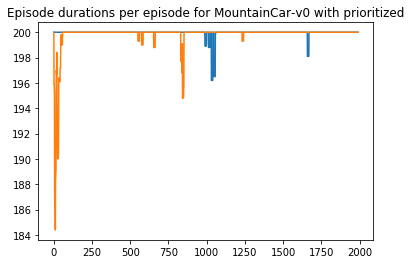

In [28]:
#Hyperparameters
num_episodes = 2000
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
buffer_size = 10000

#Parameters for network, e.g. hidden dim
num_input = len(env.observation_space.sample())
num_hidden = 128
num_output = env.action_space.n

#Parameters for schedule of beta and alpha for prioritized replay
beta_max_iter = 1000
beta_start = 0.4
beta_end = 1.0
prioritized_replay_alpha = 0.6
#prioritized_replay_eps=1e-6 Set default in the training function

#Parameters for selective
episodic_buffer_size = 12000

#Parameters for hindsight
num_policy_hidden = 128
k = 4
env_name = env.unwrapped.spec.id
bigger_buffer_size = 10000 * k

all_results = []
for memory_method in [1,2,3]:
    #Picking the memory type
    #memory_method = 4

    if memory_method == 1:  #Uniform
        memory = ReplayMemory(buffer_size)
        train_func = train #Uniform
        select_action_func = select_action #epsilon greedy

    elif memory_method == 2:   #Prioritzed
        memory = PrioritizedReplayBuffer(buffer_size, alpha=prioritized_replay_alpha)
        train_func = train_prioritized #Prioritized Replay
        select_action_func = select_action #epsilon greedy

    elif memory_method == 3:   #Selective
        memory = SelectiveReplayMemory(buffer_size,episodic_buffer_size)
        train_func = train #same way as uniform
        select_action_func = select_action #epsilon greedy

    elif memory_method == 4: #Hindsight
        num_input = 2 * num_input
        memory = HindsightReplayMemory(bigger_buffer_size,k,env_name)
        train_func = train #same way as uniform
        select_action_func = select_action #epsilon greedy

    #Initialize model
    model = QNetwork(device,num_input,num_hidden,num_output)
    model = model.to(device)

    #Running
    start_time = time.time()
    episode_durations = run_episodes(train_func,select_action_func, model, memory, env, num_episodes, batch_size, discount_factor, learn_rate,
                                    beta_max_iter,beta_start,beta_end)
    end_time = time.time()

    print("Total duration time: ", str(end_time - start_time))
    all_results.append(episode_durations)
    fig = plt.figure(figsize=(13,7))
    plt.plot(smooth(episode_durations, 10))
    plt.title('Episode durations per episode for ' + env_name + " with " + memory.name)
    plt.show()

Text(0.5, 1.0, 'Episode durations per episode for MountainCar-v0 with hindsight')

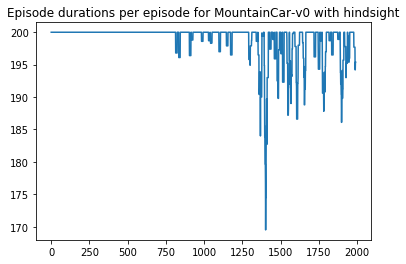

In [24]:
f
plt.plot(smooth(episode_durations, 10))
hindsight_car = episode_durations[0]
plt.title('Episode durations per episode for ' + env_name + " with " + memory.name)

Text(0.5, 1.0, 'Episode durations per episode for MountainCar-v0 with Uniform')

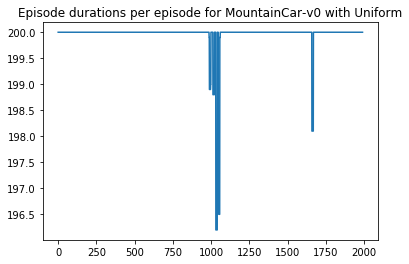

In [32]:
plt.plot(smooth(all_results[0], 10))
plt.title('Episode durations per episode for ' + env_name + " with Uniform" )

Text(0.5, 1.0, 'Episode durations per episode for MountainCar-v0 with prioritized')

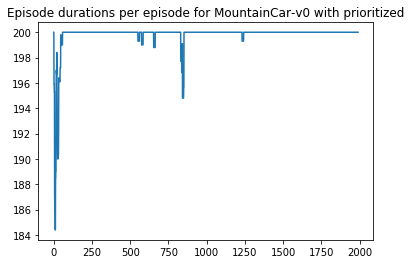

In [34]:
plt.plot(smooth(all_results[1], 10))
plt.title('Episode durations per episode for ' + env_name + " with prioritized")